In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline
%config InlineBackend.figure_format = "retina"
%reload_ext nb_black

<IPython.core.display.Javascript object>

# ResNet

## Import

In [2]:
import sys

sys.path.insert(0, "../src")

<IPython.core.display.Javascript object>

In [4]:
import os
import tempfile
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

sns.set()

import scipy
from sklearn import metrics
from sklearn import model_selection

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchcontrib
from torch.optim.swa_utils import AveragedModel, SWALR, update_bn

torch.backends.cudnn.benchmark = True

import albumentations as A
from iterstrat import ml_stratifiers

import dataset
import engine
import models
import optimizers
import utils

<IPython.core.display.Javascript object>

In [5]:
SEED = 42
utils.seed_everything(SEED)
DEVICE = torch.device("cuda" if torch.cuda.is_available else "cpu")

<IPython.core.display.Javascript object>

## Data

In [6]:
DATA_PATH = Path("../input")
df = pd.read_csv(DATA_PATH / "train.csv")
df.head()

id  digit letter  0  1  2  3  4  5  6  ...  774  775  776  777  778  779  \
0   1      5      L  1  1  1  4  3  0  0  ...    2    1    0    1    2    4   
1   2      0      B  0  4  0  0  4  1  1  ...    0    3    0    1    4    1   
2   3      4      L  1  1  2  2  1  1  1  ...    3    3    3    0    2    0   
3   4      9      D  1  2  0  2  0  4  0  ...    3    3    2    0    1    4   
4   5      6      A  3  0  2  4  0  3  0  ...    4    4    3    2    1    3   

   780  781  782  783  
0    4    4    3    4  
1    4    2    1    2  
2    3    0    2    2  
3    0    0    1    1  
4    4    3    1    2  

[5 rows x 787 columns]

<IPython.core.display.Javascript object>

## Model

In [7]:
def init_cnn(m):
    if getattr(m, "bias", None) is not None:
        nn.init.constant_(m.bias, 0)
    if isinstance(m, (nn.Conv2d, nn.Linear)):
        nn.init.kaiming_normal_(m.weight)
    for l in m.children():
        init_cnn(l)

<IPython.core.display.Javascript object>

### Swish

In [8]:
sigmoid = torch.nn.Sigmoid()


class Swish(torch.autograd.Function):
    @staticmethod
    def forward(ctx, i):
        result = i * sigmoid(i)
        ctx.save_for_backward(i)
        return result

    @staticmethod
    def backward(ctx, grad_output):
        i = ctx.saved_tensors[0]
        sigmoid_i = sigmoid(i)
        return grad_output * (sigmoid_i * (1 + i * (1 - sigmoid_i)))


swish = Swish.apply


class Swish_module(nn.Module):
    def forward(self, x):
        return swish(x)


swish_layer = Swish_module()


def relu_fn(x):
    """ Swish activation function """
    # return x * torch.sigmoid(x)
    return swish_layer(x)

<IPython.core.display.Javascript object>

### ResNet

In [9]:
def conv3x3(in_planes, out_planes, stride=1):
    return nn.Conv2d(
        in_planes, out_planes, kernel_size=3, stride=stride, padding=1, bias=False
    )


class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_planes, planes, stride=1):
        super(BasicBlock, self).__init__()
        self.conv1 = conv3x3(in_planes, planes, stride)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = conv3x3(planes, planes)
        self.bn2 = nn.BatchNorm2d(planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion * planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(
                    in_planes,
                    self.expansion * planes,
                    kernel_size=1,
                    stride=stride,
                    bias=False,
                ),
                nn.BatchNorm2d(self.expansion * planes),
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out


class PreActBlock(nn.Module):
    """Pre-activation version of the BasicBlock"""

    expansion = 1

    def __init__(self, in_planes, planes, stride=1):
        super(PreActBlock, self).__init__()
        self.bn1 = nn.BatchNorm2d(in_planes)
        self.conv1 = conv3x3(in_planes, planes, stride)
        self.bn2 = nn.BatchNorm2d(planes)
        self.conv2 = conv3x3(planes, planes)

        if stride != 1 or in_planes != self.expansion * planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(
                    in_planes,
                    self.expansion * planes,
                    kernel_size=1,
                    stride=stride,
                    bias=False,
                )
            )
        else:
            self.shortcut = nn.Sequential()

    def forward(self, x):
        x = F.relu(self.bn1(x))
        shortcut = self.shortcut(x)
        x = self.conv1(x)
        out = self.conv2(F.relu(self.bn2(x)))
        out += shortcut
        return out


class Bottleneck(nn.Module):
    """Pre-activation version of the original Bottleneck module."""

    expansion = 4

    def __init__(self, in_planes, planes, stride=1):
        super(Bottleneck, self).__init__()
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(
            planes, planes, kernel_size=3, stride=stride, padding=1, bias=False
        )
        self.bn2 = nn.BatchNorm2d(planes)
        self.conv3 = nn.Conv2d(
            planes, self.expansion * planes, kernel_size=1, bias=False
        )
        self.bn3 = nn.BatchNorm2d(self.expansion * planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion * planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(
                    in_planes,
                    self.expansion * planes,
                    kernel_size=1,
                    stride=stride,
                    bias=False,
                ),
                nn.BatchNorm2d(self.expansion * planes),
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = F.relu(self.bn2(self.conv2(out)))
        out = self.bn3(self.conv3(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out

<IPython.core.display.Javascript object>

In [10]:
class ResNet(nn.Module):
    def __init__(self, block, num_blocks, num_classes=10):
        super(ResNet, self).__init__()
        self.in_planes = 64

        self.conv1 = conv3x3(1, 64)
        self.bn1 = nn.BatchNorm2d(64)
        self.layer1 = self._make_layer(block, 64, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 128, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 256, num_blocks[2], stride=2)
        self.layer4 = self._make_layer(block, 512, num_blocks[3], stride=2)
        self.linear = nn.Linear(1024 * block.expansion, num_classes)
        init_cnn(self)

    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1] * (num_blocks - 1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride))
            self.in_planes = planes * block.expansion
        return nn.Sequential(*layers)

    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x)))
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        avg_feats = F.adaptive_avg_pool2d(x, output_size=1)
        max_feats = F.adaptive_max_pool2d(x, output_size=1)
        x = torch.cat([avg_feats, max_feats], dim=1)
        x = x.view(x.size(0), -1)
        x = self.linear(x)
        return x


def ResNet18():
    return ResNet(PreActBlock, [2, 2, 2, 2])


def ResNet34():
    return ResNet(BasicBlock, [3, 4, 6, 3])


def ResNet50():
    return ResNet(Bottleneck, [3, 4, 6, 3])


def ResNet101():
    return ResNet(Bottleneck, [3, 4, 23, 3])


def ResNet152():
    return ResNet(Bottleneck, [3, 8, 36, 3])

<IPython.core.display.Javascript object>

### XResNet

In [11]:
def conv(ni, nf, kernel_size=3, stride=1, bias=False):
    """Creats a convolutional layer for `XResNet`"""
    return nn.Conv2d(
        ni,
        nf,
        kernel_size=kernel_size,
        stride=stride,
        padding=kernel_size // 2,
        bias=bias,
    )


def conv_layer(ni, nf, ks=3, stride=1, zero_bn=False, act=True):
    """Creates a convolutional block for `XResNet`."""
    bn = nn.BatchNorm2d(nf)
    nn.init.constant_(bn.weight, 0.0 if zero_bn else 1.0)
    layers = [
        conv(ni, nf, ks, stride=stride),
        bn,
    ]
    if act:
        layers.append(nn.ReLU(inplace=True))
    return nn.Sequential(*layers)


class XResBlock(nn.Module):
    """Creates the standard `XResNet` block."""

    def __init__(self, expansion, ni, nh, stride=1):
        super(XResBlock, self).__init__()
        ni, nf = ni * expansion, nh * expansion
        layers = [conv_layer(ni, nh, 1)]
        layers += (
            [conv_layer(nh, nf, 3, stride=stride, zero_bn=True, act=False)]
            if expansion == 1
            else [
                conv_layer(nh, nh, 3, stride=stride),
                conv_layer(nh, nf, 1, zero_bn=True, act=False),
            ]
        )
        self.convs = nn.Sequential(*layers)
        self.idconv = nn.Identity() if ni == nf else conv_layer(ni, nf, 1)
        self.pool = nn.Identity() if stride == 1 else nn.AvgPool2d(2, ceil_mode=True)

    def forward(self, x):
        return F.relu(self.convs(x) + self.pool(self.idconv(x)))

<IPython.core.display.Javascript object>

In [12]:
class XResNet(nn.Sequential):
    def __init__(self, expansion, layers, num_classes=10):
        #         stem = [conv_layer(1, 16), conv_layer(16, 32), conv_layer(32, 64)]
        stem = [
            conv_layer(1, 64),
        ]

        block_szs = [64 // expansion, 64, 128, 256, 512]
        blocks = [
            self._make_layer(
                expansion,
                block_szs[i],
                block_szs[i + 1],
                blocks=l,
                stride=1 if i == 0 else 2,
            )
            for i, l in enumerate(layers)
        ]
        super().__init__(
            *stem,
            *blocks,
            nn.AdaptiveAvgPool2d(1),
            nn.Flatten(),
            nn.Linear(block_szs[-1] * expansion, num_classes),
        )
        init_cnn(self)

    def _make_layer(self, expansion, ni, nf, blocks, stride):
        return nn.Sequential(
            *[
                XResBlock(expansion, ni if i == 0 else nf, nf, stride if i == 0 else 1)
                for i in range(blocks)
            ]
        )


def XResNet18(**kwargs):
    return XResNet(1, [2, 2, 2, 2], **kwargs)


def XResNet34(**kwargs):
    return XResNet(1, [3, 4, 6, 3], **kwargs)


def XResNet50(**kwargs):
    return XResNet(4, [3, 4, 6, 3], **kwargs)


def XResNet101(**kwargs):
    return XResNet(4, [3, 4, 23, 3], **kwargs)


def XResNet152(**kwargs):
    return XResNet(4, [3, 8, 36, 3], **kwargs)

<IPython.core.display.Javascript object>

## Train

In [16]:
def get_model(model_name):
    """Get model."""
    if model_name == "resnet18":
        model = ResNet18()
    elif model_name == "resnet34":
        model = ResNet34()
    elif model_name == "resnet50":
        model = ResNet50()
    elif model_name == "resnet101":
        model = ResNet101()
    elif model_name == "xresnet18":
        model = XResNet18()
    elif model_name == "xresnet34":
        model = XResNet34()
    elif model_name == "xresnet50":
        model = XResNet50()
    elif model_name == "efficientnetb0":
        model = models.EfficientNetB0()
    else:
        raise RuntimeError("Unknown model name:", model_name)

    return model


def get_optimizer(optim_name, model, lr, wd, skip_list=["bias", "bn"]):
    """Get optimizer."""
    params = []
    exclude_params = []
    for name, param in model.named_parameters():
        if not param.requires_grad:
            continue
        elif any(skip in name for skip in skip_list):
            exclude_params.append(param)
        else:
            params.append(param)
    optim_params = [
        {"params": params, "weight_decay": wd},
        {"params": exclude_params, "weight_decay": 0.0},
    ]
    if optim_name == "radam":
        optimizer = optimizers.RAdam(optim_params, lr=lr)
    elif optim_name == "adam":
        optimizer = torch.optim.Adam(optim_params, lr=lr)
    else:
        raise RuntimeError("Unknown optimizer:", optim_name)

    return optimizer

<IPython.core.display.Javascript object>

In [17]:
def run(
    model_name,
    optim_name,
    epochs,
    lr,
    wd,
    augs=None,
    label_smooth=True,
    mixup=False,
    cutmix=False,
    device=DEVICE,
    swa=False,
    swa_lr=4e-4,
):
    oof = np.zeros((len(df), 10))
    targs = np.zeros(len(df))

    for fold in range(5):
        train_indices = np.load(DATA_PATH / f"train_idx-fold{fold}.npy")
        valid_indices = np.load(DATA_PATH / f"valid_idx-fold{fold}.npy")
        train_dataset = dataset.EMNISTDataset(df, train_indices, augs=augs)
        valid_dataset = dataset.EMNISTDataset(df, valid_indices)
        train_loader = torch.utils.data.DataLoader(
            train_dataset, batch_size=64, shuffle=True, num_workers=4, pin_memory=True
        )
        valid_loader = torch.utils.data.DataLoader(
            valid_dataset, batch_size=256, num_workers=4, pin_memory=True
        )

        model = get_model(model_name).to(device)
        optimizer = get_optimizer(optim_name, model, lr, wd)
        scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=epochs)
        scaler = torch.cuda.amp.GradScaler()

        if swa:
            swa_start = int(epochs * 0.75)
            steps_per_epoch = len(train_dataset) // 64
            optimizer = torchcontrib.optim.SWA(
                optimizer,
                swa_start=swa_start * steps_per_epoch,
                swa_freq=steps_per_epoch,
                swa_lr=swa_lr,
            )

        train_accuracies = []
        valid_accuracies = []

        for epoch in range(epochs):
            # Train
            train_loss, train_accuracy = engine.train(
                train_loader,
                model,
                optimizer,
                device,
                scaler,
                label_smooth=label_smooth,
                mixup=mixup,
                cutmix=cutmix,
            )
            train_accuracies.append(train_accuracy)
            scheduler.step()

            # Validate
            valid_probs, valid_targs, valid_loss, valid_accuracy = engine.evaluate(
                valid_loader, model, device
            )
            valid_accuracies.append(valid_accuracy)
            if epoch % 10 == 0:
                print(
                    f"Epoch={epoch}, Train loss={train_loss:.5f}, Valid loss={valid_loss:.5f}, Train Accuracy={train_accuracy:.5f}, Validation Accuracy={valid_accuracy:.5f}"
                )

        if swa:
            optimizer.swap_swa_sgd()
            optimizer.bn_update(train_loader, model, device)

        valid_probs, valid_targs, valid_loss, valid_accuracy = engine.evaluate(
            valid_loader, model, device
        )
        print(
            f"Fold={fold}, Valid loss={valid_loss:.5f}, Valid Accuracy={valid_accuracy:.5f}"
        )

        # oof prediction
        oof[valid_indices] = scipy.special.softmax(valid_probs, axis=1)
        targs[valid_indices] = valid_targs

        # Save model
        checkpoint = (
            f"./models/swa_{model_name}_fold{fold}.pth"
            if swa
            else f"./models/{model_name}_fold{fold}.pth"
        )
        torch.save(model.state_dict(), checkpoint)

        # Plot training curve
        rng = np.arange(len(train_accuracies))
        plt.plot(rng, train_accuracies, label="Train")
        plt.plot(rng, valid_accuracies, label="Validation")
        plt.title(f"Training curve for fold{fold}")
        plt.ylabel("Accuracy")
        plt.xlabel("Epoch")
        plt.legend()
        plt.show()

    # Confusion matrix
    conf = metrics.confusion_matrix(targs, np.argmax(oof, axis=1))
    plt.figure(figsize=(9, 7))
    sns.heatmap(conf, cmap="coolwarm", annot=True, fmt="d")
    plt.ylabel("True")
    plt.xlabel("Predicted")
    plt.show()

    # Classification report
    print(metrics.classification_report(targs, np.argmax(oof, axis=1)))

    return oof, targs

<IPython.core.display.Javascript object>

In [18]:
def plot_cosine_annealing(lr, epochs):
    optimizer = torch.optim.SGD([torch.tensor(1)], lr=lr)
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=epochs)

    lrs = []
    for _ in range(epochs):
        optimizer.step()
        lrs.append(scheduler.get_last_lr())
        scheduler.step()

    plt.plot(lrs)
    plt.axvline(x=int(0.75 * epochs), color="red")
    plt.show()

<IPython.core.display.Javascript object>

## 1.0

Epoch=0, Train loss=6.91973, Valid loss=8118.68703, Train Accuracy=0.10613, Validation Accuracy=0.10024
Epoch=10, Train loss=2.95821, Valid loss=1215.03387, Train Accuracy=0.18735, Validation Accuracy=0.11491
Epoch=20, Train loss=2.48288, Valid loss=1.87936, Train Accuracy=0.25956, Validation Accuracy=0.42543
Epoch=30, Train loss=2.26061, Valid loss=2.23030, Train Accuracy=0.37623, Validation Accuracy=0.48411
Epoch=40, Train loss=2.17843, Valid loss=1.70252, Train Accuracy=0.37396, Validation Accuracy=0.49633
Epoch=50, Train loss=2.04682, Valid loss=1.26328, Train Accuracy=0.41665, Validation Accuracy=0.65770
Epoch=60, Train loss=2.14560, Valid loss=1.32239, Train Accuracy=0.37559, Validation Accuracy=0.74328
Epoch=70, Train loss=1.99306, Valid loss=1.08517, Train Accuracy=0.42412, Validation Accuracy=0.74817
Epoch=80, Train loss=1.49899, Valid loss=0.85143, Train Accuracy=0.67522, Validation Accuracy=0.78973
Epoch=90, Train loss=2.00820, Valid loss=1.31516, Train Accuracy=0.44180, Val

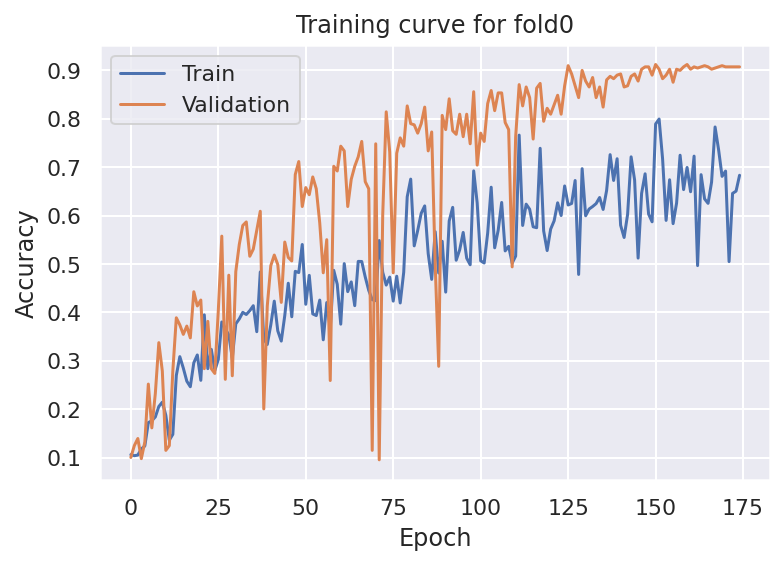

Epoch=0, Train loss=6.47939, Valid loss=1020.96630, Train Accuracy=0.09670, Validation Accuracy=0.09512
Epoch=10, Train loss=2.47352, Valid loss=2.27136, Train Accuracy=0.25438, Validation Accuracy=0.31951
Epoch=20, Train loss=2.40365, Valid loss=1.93785, Train Accuracy=0.24833, Validation Accuracy=0.31463
Epoch=30, Train loss=2.14151, Valid loss=1.50368, Train Accuracy=0.38619, Validation Accuracy=0.51707
Epoch=40, Train loss=1.78036, Valid loss=1.20998, Train Accuracy=0.54924, Validation Accuracy=0.65366
Epoch=50, Train loss=2.18643, Valid loss=3.65350, Train Accuracy=0.35778, Validation Accuracy=0.43659
Epoch=60, Train loss=2.08120, Valid loss=1.23950, Train Accuracy=0.42232, Validation Accuracy=0.69756
Epoch=70, Train loss=1.80749, Valid loss=1.79076, Train Accuracy=0.51248, Validation Accuracy=0.59024
Epoch=80, Train loss=1.90296, Valid loss=1.55599, Train Accuracy=0.51218, Validation Accuracy=0.67073
Epoch=90, Train loss=1.81571, Valid loss=2.44209, Train Accuracy=0.55040, Valida

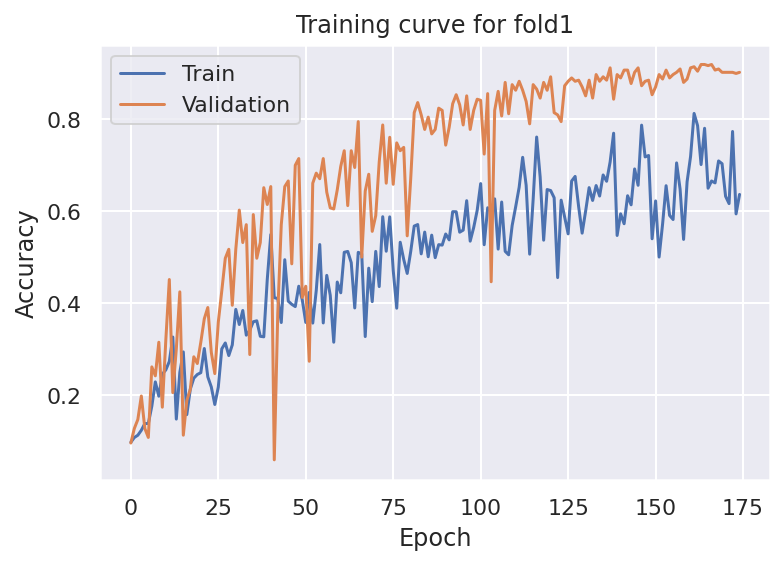

Epoch=0, Train loss=6.03428, Valid loss=1397.54064, Train Accuracy=0.09613, Validation Accuracy=0.11951
Epoch=10, Train loss=2.47150, Valid loss=7.01065, Train Accuracy=0.24558, Validation Accuracy=0.18780
Epoch=20, Train loss=2.26106, Valid loss=1.77661, Train Accuracy=0.31644, Validation Accuracy=0.41707
Epoch=30, Train loss=2.22088, Valid loss=2.97252, Train Accuracy=0.36354, Validation Accuracy=0.41707
Epoch=40, Train loss=2.29235, Valid loss=2.98699, Train Accuracy=0.33723, Validation Accuracy=0.51951
Epoch=50, Train loss=1.99596, Valid loss=37.05637, Train Accuracy=0.47813, Validation Accuracy=0.35610
Epoch=60, Train loss=2.03964, Valid loss=2.76054, Train Accuracy=0.43872, Validation Accuracy=0.56829
Epoch=70, Train loss=1.91950, Valid loss=1.04684, Train Accuracy=0.50616, Validation Accuracy=0.73659
Epoch=80, Train loss=2.01867, Valid loss=1.52329, Train Accuracy=0.46446, Validation Accuracy=0.73171
Epoch=90, Train loss=2.03298, Valid loss=1.33370, Train Accuracy=0.45067, Valid

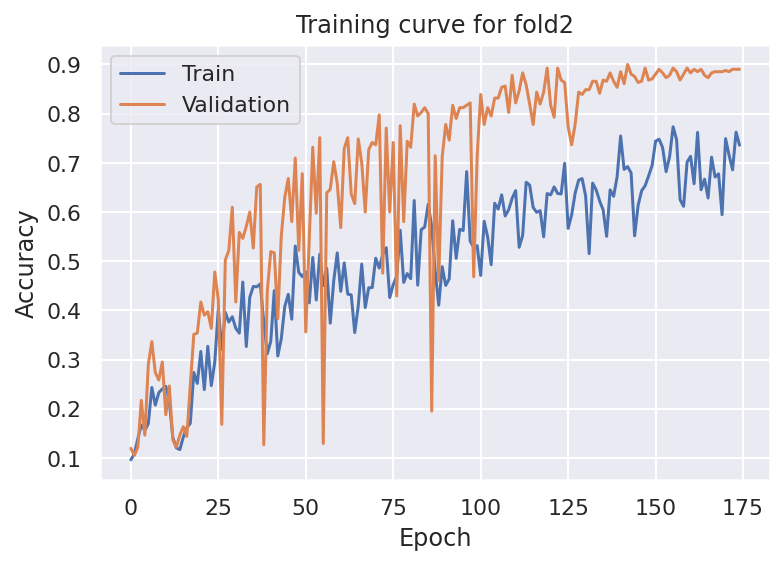

Epoch=0, Train loss=6.71430, Valid loss=7880.19571, Train Accuracy=0.08632, Validation Accuracy=0.06585
Epoch=10, Train loss=2.63807, Valid loss=3.42929, Train Accuracy=0.11414, Validation Accuracy=0.13171
Epoch=20, Train loss=2.63319, Valid loss=9.10780, Train Accuracy=0.13278, Validation Accuracy=0.12195
Epoch=30, Train loss=2.59021, Valid loss=4.00241, Train Accuracy=0.14335, Validation Accuracy=0.12683
Epoch=40, Train loss=2.33690, Valid loss=2.19108, Train Accuracy=0.19290, Validation Accuracy=0.22195
Epoch=50, Train loss=2.23161, Valid loss=2.06099, Train Accuracy=0.27398, Validation Accuracy=0.41951
Epoch=60, Train loss=2.09259, Valid loss=2.29638, Train Accuracy=0.36126, Validation Accuracy=0.40244
Epoch=70, Train loss=2.04476, Valid loss=1.54548, Train Accuracy=0.41365, Validation Accuracy=0.57805
Epoch=80, Train loss=1.65337, Valid loss=0.86616, Train Accuracy=0.60093, Validation Accuracy=0.80000
Epoch=90, Train loss=1.78515, Valid loss=1.33728, Train Accuracy=0.54301, Valida

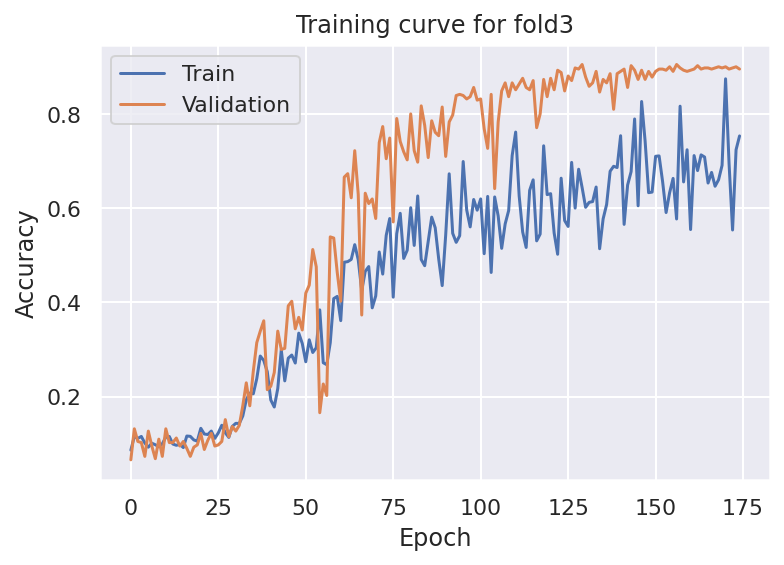

Epoch=0, Train loss=6.86123, Valid loss=83056.07322, Train Accuracy=0.09434, Validation Accuracy=0.12225
Epoch=10, Train loss=2.55651, Valid loss=3.52952, Train Accuracy=0.22097, Validation Accuracy=0.28117
Epoch=20, Train loss=2.45297, Valid loss=6.93513, Train Accuracy=0.26293, Validation Accuracy=0.38142
Epoch=30, Train loss=2.42761, Valid loss=2.78246, Train Accuracy=0.16642, Validation Accuracy=0.20782
Epoch=40, Train loss=2.21434, Valid loss=1.53721, Train Accuracy=0.33592, Validation Accuracy=0.52323
Epoch=50, Train loss=2.22049, Valid loss=52.99990, Train Accuracy=0.31281, Validation Accuracy=0.11980
Epoch=60, Train loss=2.01605, Valid loss=1.49635, Train Accuracy=0.45146, Validation Accuracy=0.59902
Epoch=70, Train loss=2.02234, Valid loss=1.25996, Train Accuracy=0.45230, Validation Accuracy=0.71394
Epoch=80, Train loss=1.80737, Valid loss=0.98717, Train Accuracy=0.53246, Validation Accuracy=0.75550
Epoch=90, Train loss=1.71441, Valid loss=0.92970, Train Accuracy=0.60036, Vali

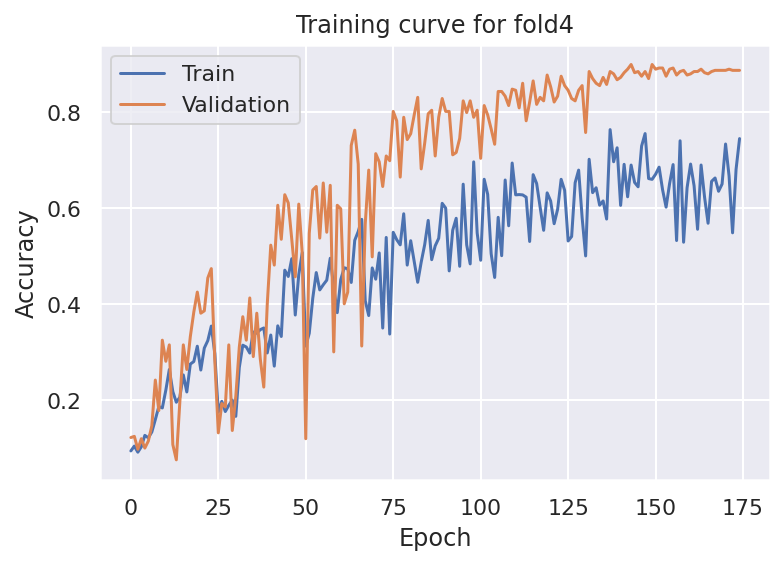

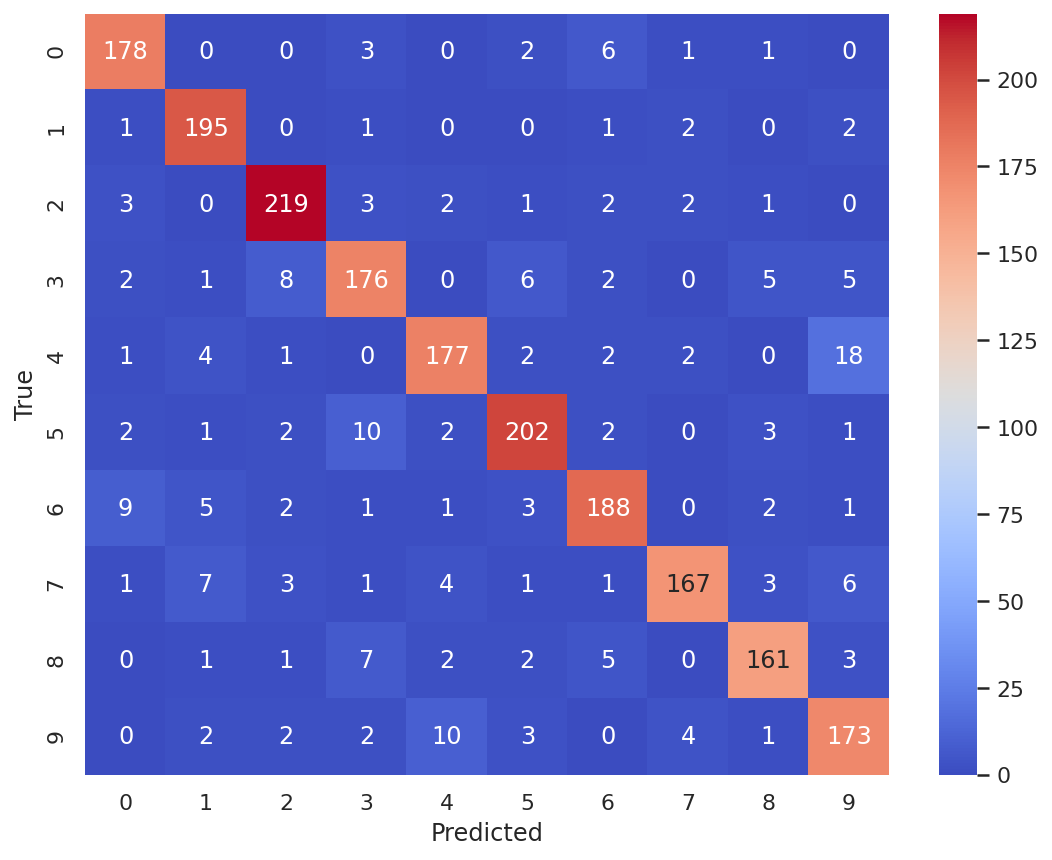

              precision    recall  f1-score   support

         0.0       0.90      0.93      0.92       191
         1.0       0.90      0.97      0.93       202
         2.0       0.92      0.94      0.93       233
         3.0       0.86      0.86      0.86       205
         4.0       0.89      0.86      0.87       207
         5.0       0.91      0.90      0.90       225
         6.0       0.90      0.89      0.89       212
         7.0       0.94      0.86      0.90       194
         8.0       0.91      0.88      0.90       182
         9.0       0.83      0.88      0.85       197

    accuracy                           0.90      2048
   macro avg       0.90      0.90      0.90      2048
weighted avg       0.90      0.90      0.90      2048

CV Accuracy Score=0.896484375
model=resnet34, optimizer=adam, epochs=175, lr=0.003, wd=0.0005
CPU times: user 14min, sys: 2min 22s, total: 16min 22s
Wall time: 17min 11s


<IPython.core.display.Javascript object>

In [26]:
%%time
augs = A.Compose([
    A.ShiftScaleRotate(shift_limit=0.0625, scale_limit=0.05, rotate_limit=10, p=0.5),
    A.Normalize(mean=0.143, std=0.254, max_pixel_value=255.0, always_apply=True,),
])
model_name = "resnet34"
optim_name = "adam"
epochs = 175
lr = 3e-3
wd = 5e-4
oof, targs = run(model_name, optim_name, epochs, lr, wd, augs, label_smooth=True, mixup=False, cutmix=True)
preds = np.argmax(oof, axis=1)
accuracy = metrics.accuracy_score(targs, preds)
print(f"CV Accuracy Score={accuracy}")
print(f"model={model_name}, optimizer={optim_name}, epochs={epochs}, lr={lr}, wd={wd}")

Epoch=0, Train loss=6.24889, Valid loss=11130.24254, Train Accuracy=0.09989, Validation Accuracy=0.11736
Epoch=10, Train loss=2.61141, Valid loss=11.41594, Train Accuracy=0.14621, Validation Accuracy=0.17359
Epoch=20, Train loss=2.67534, Valid loss=23.07633, Train Accuracy=0.11971, Validation Accuracy=0.11002
Epoch=30, Train loss=2.39590, Valid loss=2.70787, Train Accuracy=0.17663, Validation Accuracy=0.19071
Epoch=40, Train loss=1.97574, Valid loss=1.56920, Train Accuracy=0.45103, Validation Accuracy=0.45966
Epoch=50, Train loss=2.16905, Valid loss=1.94979, Train Accuracy=0.35511, Validation Accuracy=0.40587
Epoch=60, Train loss=1.85928, Valid loss=2.15246, Train Accuracy=0.52038, Validation Accuracy=0.58191
Epoch=70, Train loss=1.92482, Valid loss=2.05131, Train Accuracy=0.47307, Validation Accuracy=0.56968
Epoch=80, Train loss=1.88754, Valid loss=1.18764, Train Accuracy=0.50405, Validation Accuracy=0.77262
Epoch=90, Train loss=2.03059, Valid loss=1.08104, Train Accuracy=0.46332, Val

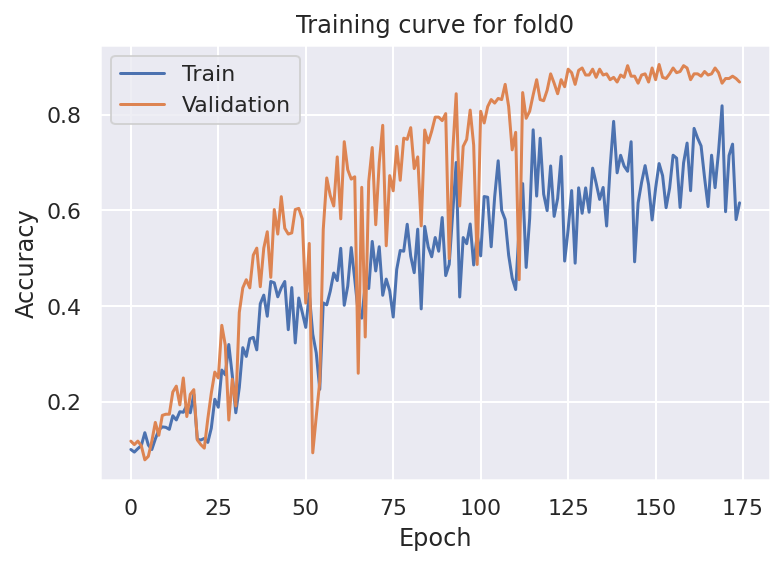

Epoch=0, Train loss=6.86174, Valid loss=1568.44453, Train Accuracy=0.10484, Validation Accuracy=0.10244
Epoch=10, Train loss=2.62147, Valid loss=2.48180, Train Accuracy=0.16824, Validation Accuracy=0.23415
Epoch=20, Train loss=2.42629, Valid loss=1.91902, Train Accuracy=0.22351, Validation Accuracy=0.34390
Epoch=30, Train loss=2.33948, Valid loss=2.45486, Train Accuracy=0.26150, Validation Accuracy=0.43171
Epoch=40, Train loss=2.14565, Valid loss=1.44521, Train Accuracy=0.38211, Validation Accuracy=0.56829
Epoch=50, Train loss=2.11017, Valid loss=2.18723, Train Accuracy=0.37088, Validation Accuracy=0.51707
Epoch=60, Train loss=2.17645, Valid loss=1.39016, Train Accuracy=0.34485, Validation Accuracy=0.61951
Epoch=70, Train loss=2.04006, Valid loss=1.31685, Train Accuracy=0.44081, Validation Accuracy=0.70488
Epoch=80, Train loss=1.77331, Valid loss=0.83413, Train Accuracy=0.54893, Validation Accuracy=0.80488
Epoch=90, Train loss=1.85065, Valid loss=0.89508, Train Accuracy=0.51463, Valida

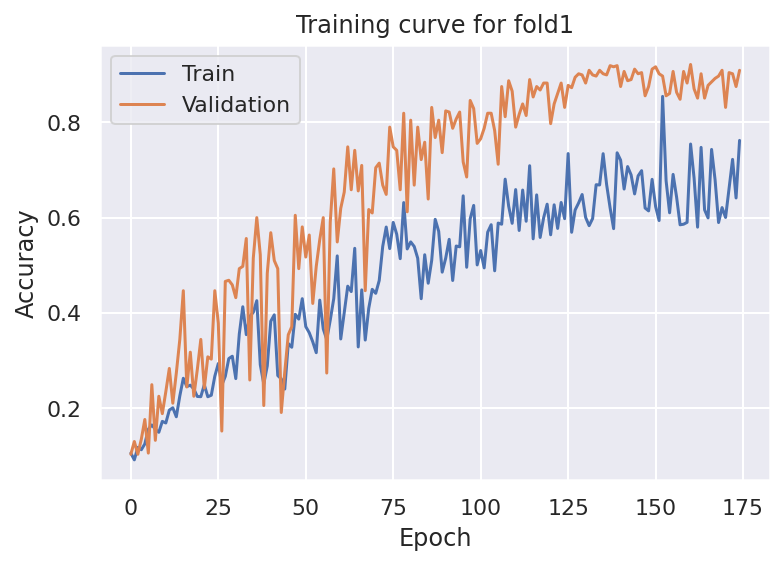

Epoch=0, Train loss=6.33619, Valid loss=9130.16671, Train Accuracy=0.08786, Validation Accuracy=0.07317
Epoch=10, Train loss=2.67419, Valid loss=5.37981, Train Accuracy=0.19683, Validation Accuracy=0.17317
Epoch=20, Train loss=2.37474, Valid loss=3.08042, Train Accuracy=0.31859, Validation Accuracy=0.48537
Epoch=30, Train loss=2.25933, Valid loss=1.62000, Train Accuracy=0.32056, Validation Accuracy=0.52683
Epoch=40, Train loss=2.03878, Valid loss=1.54186, Train Accuracy=0.43613, Validation Accuracy=0.60976
Epoch=50, Train loss=1.75191, Valid loss=1.07431, Train Accuracy=0.56310, Validation Accuracy=0.70976
Epoch=60, Train loss=1.80150, Valid loss=1.54144, Train Accuracy=0.54149, Validation Accuracy=0.68049
Epoch=70, Train loss=1.98370, Valid loss=4.33161, Train Accuracy=0.45163, Validation Accuracy=0.51220
Epoch=80, Train loss=1.89878, Valid loss=0.98050, Train Accuracy=0.52222, Validation Accuracy=0.80488
Epoch=90, Train loss=1.86768, Valid loss=1.06528, Train Accuracy=0.53228, Valida

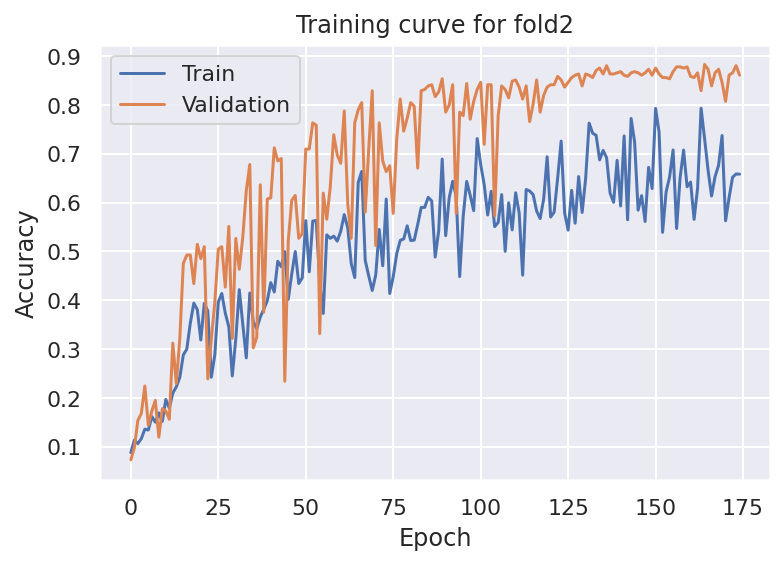

Epoch=0, Train loss=5.64237, Valid loss=5857.57753, Train Accuracy=0.10736, Validation Accuracy=0.09512
Epoch=10, Train loss=2.63410, Valid loss=4.40938, Train Accuracy=0.19257, Validation Accuracy=0.23171
Epoch=20, Train loss=2.42841, Valid loss=2.08871, Train Accuracy=0.24149, Validation Accuracy=0.28537
Epoch=30, Train loss=2.54970, Valid loss=2.16019, Train Accuracy=0.17102, Validation Accuracy=0.22439
Epoch=40, Train loss=2.29906, Valid loss=2.34543, Train Accuracy=0.25850, Validation Accuracy=0.32439
Epoch=50, Train loss=2.15165, Valid loss=1.80525, Train Accuracy=0.35165, Validation Accuracy=0.50244
Epoch=60, Train loss=2.12616, Valid loss=1.65532, Train Accuracy=0.40171, Validation Accuracy=0.61951
Epoch=70, Train loss=1.94482, Valid loss=1.40459, Train Accuracy=0.48718, Validation Accuracy=0.66585
Epoch=80, Train loss=1.91961, Valid loss=1.23145, Train Accuracy=0.48455, Validation Accuracy=0.72927
Epoch=90, Train loss=2.05403, Valid loss=1.45019, Train Accuracy=0.41335, Valida

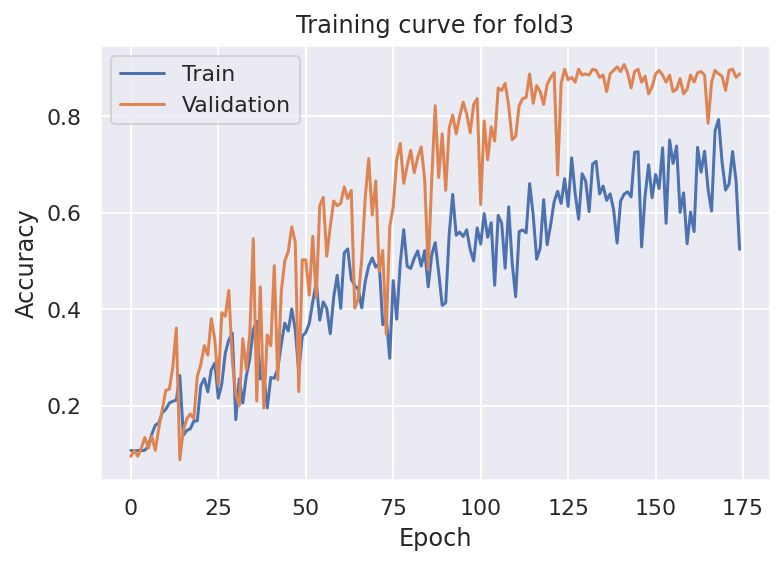

Epoch=0, Train loss=6.35229, Valid loss=2.31426, Train Accuracy=0.10843, Validation Accuracy=0.12225
Epoch=10, Train loss=2.53108, Valid loss=5.32968, Train Accuracy=0.23210, Validation Accuracy=0.17604
Epoch=20, Train loss=2.49666, Valid loss=2.01081, Train Accuracy=0.25741, Validation Accuracy=0.40098
Epoch=30, Train loss=2.36768, Valid loss=1.98829, Train Accuracy=0.22170, Validation Accuracy=0.27384
Epoch=40, Train loss=2.46977, Valid loss=2.85657, Train Accuracy=0.16711, Validation Accuracy=0.21760
Epoch=50, Train loss=2.32258, Valid loss=1.93336, Train Accuracy=0.23304, Validation Accuracy=0.40098
Epoch=60, Train loss=2.00122, Valid loss=1.67576, Train Accuracy=0.40693, Validation Accuracy=0.45477
Epoch=70, Train loss=1.81819, Valid loss=1.64654, Train Accuracy=0.51036, Validation Accuracy=0.48655
Epoch=80, Train loss=1.95534, Valid loss=1.36449, Train Accuracy=0.46685, Validation Accuracy=0.70171
Epoch=90, Train loss=1.99359, Valid loss=2.57786, Train Accuracy=0.45266, Validatio

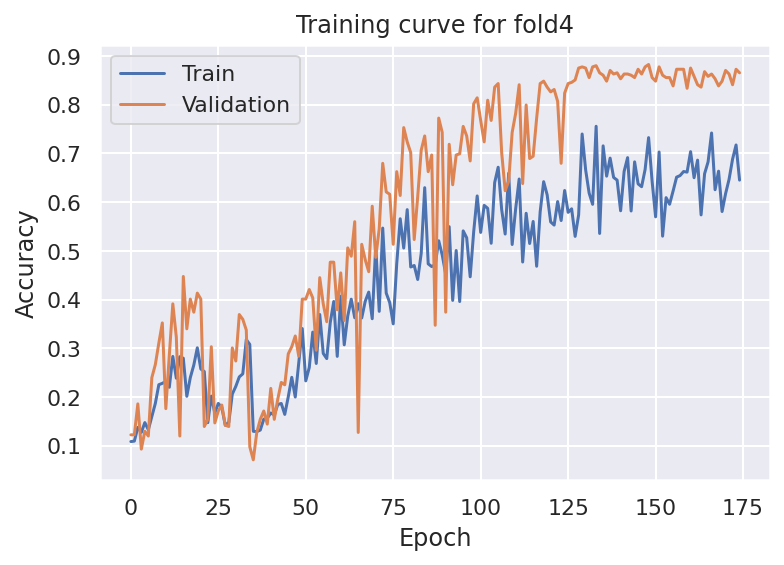

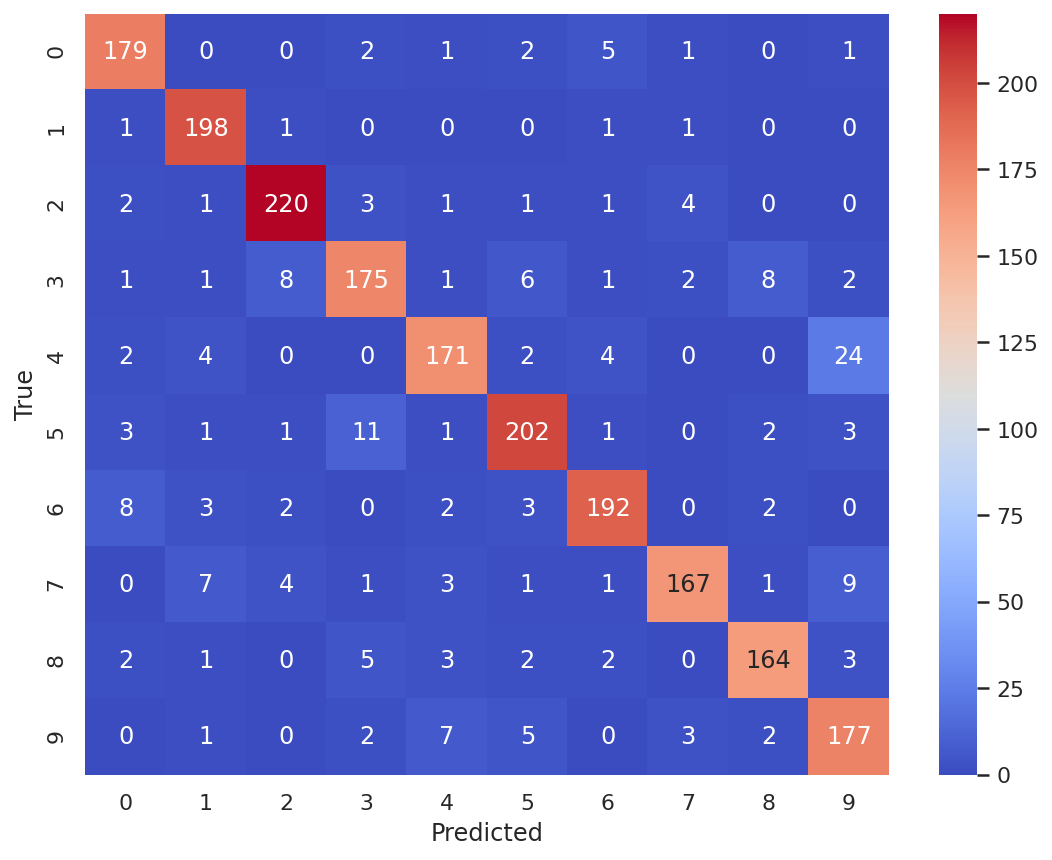

              precision    recall  f1-score   support

         0.0       0.90      0.94      0.92       191
         1.0       0.91      0.98      0.95       202
         2.0       0.93      0.94      0.94       233
         3.0       0.88      0.85      0.87       205
         4.0       0.90      0.83      0.86       207
         5.0       0.90      0.90      0.90       225
         6.0       0.92      0.91      0.91       212
         7.0       0.94      0.86      0.90       194
         8.0       0.92      0.90      0.91       182
         9.0       0.81      0.90      0.85       197

    accuracy                           0.90      2048
   macro avg       0.90      0.90      0.90      2048
weighted avg       0.90      0.90      0.90      2048

CV Accuracy Score=0.90087890625
model=resnet34, optimizer=adam, epochs=175, lr=0.003, wd=0.0005
CPU times: user 13min 59s, sys: 3min 40s, total: 17min 40s
Wall time: 18min 56s


<IPython.core.display.Javascript object>

In [111]:
%%time
augs = A.Compose([
    A.ShiftScaleRotate(shift_limit=0.0625, scale_limit=0.05, rotate_limit=10, p=0.5),
    A.Normalize(mean=0.143, std=0.254, max_pixel_value=255.0, always_apply=True,),
])
model_name = "resnet34"
optim_name = "adam"
epochs = 175
lr = 3e-3
wd = 5e-4
swa_lr = 2e-4
oof, targs = run(model_name, optim_name, epochs, lr, wd, augs, label_smooth=True, mixup=False, cutmix=True, swa=True, swa_lr=swa_lr)
preds = np.argmax(oof, axis=1)
accuracy = metrics.accuracy_score(targs, preds)
print(f"CV Accuracy Score={accuracy}")
print(f"model={model_name}, optimizer={optim_name}, epochs={epochs}, lr={lr}, wd={wd}")

### Inference

In [13]:
# def infer(model_names, checkpoints, test_df, device=DEVICE, batch_size=1024):
#     output = np.zeros((len(test_df), 10))

#     test_dataset = dataset.EMNISTDataset(test_df, np.arange(len(test_df)), label=False)
#     test_loader = torch.utils.data.DataLoader(
#         test_dataset, batch_size=batch_size, num_workers=4, pin_memory=True
#     )

#     for model_name, checkpoint in zip(model_names, checkpoints):
#         model = get_model(model_name).to(device)
#         model.load_state_dict(torch.load(checkpoint))
#         probs = engine.evaluate(test_loader, model, device, test=True)
#         output += scipy.special.softmax(probs, axis=1) / len(model_names)

#     return output

<IPython.core.display.Javascript object>

In [27]:
checkpoints = [f"./models/resnet34_fold{fold}.pth" for fold in range(5)]
model_names = ["resnet34",] * 5

<IPython.core.display.Javascript object>

In [69]:
%%time
test_df = pd.read_csv(DATA_PATH / "test.csv")
test_probs = infer(model_names, checkpoints, test_df, device=DEVICE)
test_preds = np.argmax(test_probs, axis=1)

<IPython.core.display.Javascript object>

In [72]:
test_preds = np.argmax(test_probs, axis=1)
submit = pd.DataFrame({"id": test_df.id.values, "digit": test_preds})
submit.to_csv("submit.csv", index=False)

<IPython.core.display.Javascript object>

In [82]:
a = np.take_along_axis(test_probs, test_preds[:, None], axis=1)
a.shape

(20480, 1)

<IPython.core.display.Javascript object>

### SWA

In [112]:
checkpoints = [
    "./models/swa_resnet34_fold0.pth",
    "./models/swa_resnet34_fold1.pth",
    "./models/swa_resnet34_fold2.pth",
    "./models/swa_resnet34_fold3.pth",
    "./models/swa_resnet34_fold4.pth",
]
model_names = ["resnet34",] * 5

<IPython.core.display.Javascript object>

In [113]:
%%time
test_probs = engine.infer(model_names, checkpoints, test_df, device=DEVICE)
test_preds = np.argmax(test_probs, axis=1)

CPU times: user 6min 17s, sys: 16.4 s, total: 6min 33s
Wall time: 6min 2s


<IPython.core.display.Javascript object>

In [114]:
test_preds = np.argmax(test_probs, axis=1)
submit = pd.DataFrame({"id": test_df.id.values, "digit": test_preds})
submit.to_csv("swa_submit.csv", index=False)

<IPython.core.display.Javascript object>

In [115]:
np.save("swa_probs.npy", test_probs)

<IPython.core.display.Javascript object>

## Pseudo-labeling

In [73]:
test_df = pd.read_csv(DATA_PATH / "test.csv")
test_probs = np.load("swa_probs.npy")
test_preds = np.argmax(test_probs, axis=1)

<IPython.core.display.Javascript object>

In [76]:
thresh = 0.65
maxprobs = np.take_along_axis(test_probs, test_preds[:, None], axis=1)
(maxprobs > thresh).sum()

8890

<IPython.core.display.Javascript object>

In [77]:
test_df["prob"] = maxprobs
test_df["digit"] = test_preds

<IPython.core.display.Javascript object>

In [78]:
pl_1_2 = test_df[test_df.prob > thresh].reset_index(drop=True)
pl_1_2 = pl_1_2.drop("prob", axis=1)
pl_1_2 = pd.concat([pl_1_2, df], axis=0)
pl_1_2 = pl_1_2.sample(frac=1.0).reset_index(drop=True)
pl_1_2.to_csv("./input/pl_resnet34_065.csv", index=False)
pl_1_2.shape

(10938, 787)

<IPython.core.display.Javascript object>

In [79]:
y = pl_1_2[["digit", "letter"]]
kf = ml_stratifiers.MultilabelStratifiedKFold(n_splits=5)
for fold, (train_, valid_) in enumerate(kf.split(pl_1_2, y=y)):
    np.save(f"./input/train_fold{fold}_1_2", train_)
    np.save(f"./input/valid_fold{fold}_1_2", valid_)

/home/isleof/.pyenv/versions/miniconda3-latest/envs/ml/lib/python3.7/site-packages/sklearn/utils/validation.py:71: FutureWarning: Pass shuffle=False, random_state=None as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


<IPython.core.display.Javascript object>

### Find LR

In [19]:
def find_lr(model, train_loader, loss_fn, init_val=1e-8, final_val=10.0, beta=0.98):
    # Save initial state of the model
    init_state = os.path.join(tempfile.mkdtemp(), "init_state.pt")
    torch.save(model.state_dict(), init_state)

    num_steps = len(train_loader)
    mult = (final_val / init_val) ** (1 / (num_steps - 1))
    lr = init_val
    optimizer = torch.optim.SGD(model.parameters(), lr=lr)
    optimizer.param_groups[0]["lr"] = lr

    ewa_loss = 0.0
    best_loss = np.inf
    log_lrs = []
    losses = []

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)

    model.train()
    for batch_idx, batch in enumerate(train_loader):
        # Forwardprop
        inp, targ = batch
        inp = inp.to(device)
        targ = targ.to(device)
        optimizer.zero_grad()
        out = model(inp)
        loss = loss_fn(out, targ)

        # Update smoothed and debiased losses
        ewa_loss = beta * ewa_loss + (1 - beta) * loss.item()
        debiased_loss = ewa_loss / (1 - beta ** (batch_idx + 1))

        # Stop if loss is exploding
        if batch_idx and debiased_loss > 4 * best_loss:
            break
        # Update `best_loss`
        best_loss = min(best_loss, debiased_loss)

        # Record values
        losses.append(debiased_loss)
        log_lrs.append(np.log10(lr))

        # Backprop
        loss.backward()
        optimizer.step()

        # Update LR
        lr *= mult
        optimizer.param_groups[0]["lr"] = lr

    # Reset the model to initial state
    model.load_state_dict(torch.load(init_state))

    # Plot
    plt.plot(log_lrs[10:-5], losses[10:-5])
    #     plt.plot(log_lrs, losses)
    plt.show()

    return log_lrs, losses

<IPython.core.display.Javascript object>

### Train PL

In [20]:
def run_pl(
    pl,
    model_name,
    optim_name,
    epochs,
    lr,
    wd,
    batch_size=64,
    augs=None,
    label_smooth=True,
    mixup=False,
    cutmix=False,
    device=DEVICE,
    swa=False,
    swa_lr=4e-4,
    version=1,
    minor=0,
):
    oof = np.zeros((len(pl), 10))
    targs = np.zeros(len(pl))

    for fold in range(5):
        train_indices = np.load(f"./input/train_fold{fold}_{version}_{minor}.npy")
        valid_indices = np.load(f"./input/valid_fold{fold}_{version}_{minor}.npy")
        train_dataset = dataset.EMNISTDataset(pl, train_indices, augs=augs)
        valid_dataset = dataset.EMNISTDataset(pl, valid_indices)
        train_loader = torch.utils.data.DataLoader(
            train_dataset,
            batch_size=batch_size,
            shuffle=True,
            num_workers=4,
            pin_memory=True,
        )
        valid_loader = torch.utils.data.DataLoader(
            valid_dataset, batch_size=4 * batch_size, num_workers=4, pin_memory=True
        )

        model = get_model(model_name).to(device)
        optimizer = get_optimizer(optim_name, model, lr, wd)
        scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=epochs)
        scaler = torch.cuda.amp.GradScaler()

        train_accuracies = []
        valid_accuracies = []

        for epoch in range(epochs):
            # Train
            train_loss, train_accuracy = engine.train(
                train_loader,
                model,
                optimizer,
                device,
                scaler,
                label_smooth=label_smooth,
                mixup=mixup,
                cutmix=cutmix,
            )
            train_accuracies.append(train_accuracy)
            scheduler.step()

            # Validate
            valid_probs, valid_targs, valid_loss, valid_accuracy = engine.evaluate(
                valid_loader, model, device
            )
            valid_accuracies.append(valid_accuracy)
            if epoch % 10 == 0:
                print(
                    f"Epoch={epoch}, Train loss={train_loss:.5f}, Valid loss={valid_loss:.5f}, Train Accuracy={train_accuracy:.5f}, Validation Accuracy={valid_accuracy:.5f}"
                )

        valid_probs, valid_targs, valid_loss, valid_accuracy = engine.evaluate(
            valid_loader, model, device
        )
        print(
            f"Fold={fold}, Valid loss={valid_loss:.5f}, Valid Accuracy={valid_accuracy:.5f}"
        )

        # oof prediction
        oof[valid_indices] = scipy.special.softmax(valid_probs, axis=1)
        targs[valid_indices] = valid_targs

        # Save model
        checkpoint = f"./models/{model_name}_fold{fold}_pl_{version}_{minor}.pth"
        torch.save(model.state_dict(), checkpoint)

        # Plot training curve
        rng = np.arange(len(train_accuracies))
        plt.plot(rng, train_accuracies, label="Train")
        plt.plot(rng, valid_accuracies, label="Validation")
        plt.title(f"Training curve for fold{fold}")
        plt.ylabel("Accuracy")
        plt.xlabel("Epoch")
        plt.legend()
        plt.show()

        break

    # Confusion matrix
    conf = metrics.confusion_matrix(targs, np.argmax(oof, axis=1))
    plt.figure(figsize=(9, 7))
    sns.heatmap(conf, cmap="coolwarm", annot=True, fmt="d")
    plt.ylabel("True")
    plt.xlabel("Predicted")
    plt.show()

    # Classification report
    print(metrics.classification_report(targs, np.argmax(oof, axis=1)))

    return oof, targs

<IPython.core.display.Javascript object>

### Experiment with thresholds

In [21]:
pl_1_2 = pd.read_csv("./input/pl_resnet34_065.csv")
pl_1_2.shape

(10938, 787)

<IPython.core.display.Javascript object>

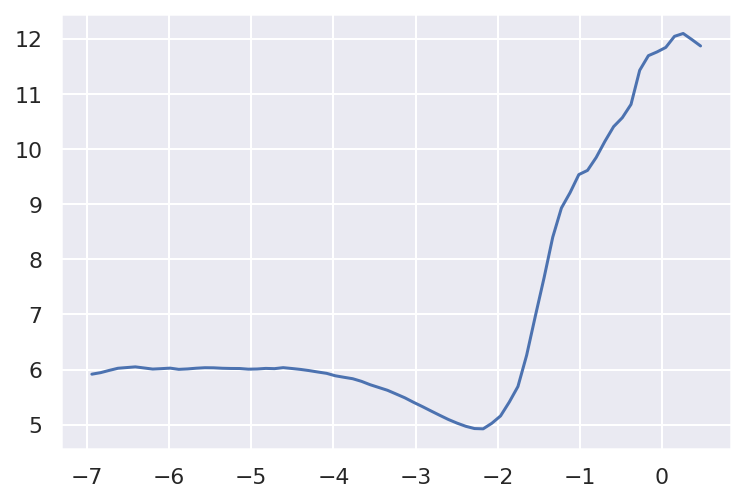

<IPython.core.display.Javascript object>

In [84]:
model = get_model("resnet34")
augs = A.Compose(
    [
        A.ShiftScaleRotate(shift_limit=0.0625, scale_limit=0.1, rotate_limit=10, p=0.5),
        A.Normalize(mean=0.143, std=0.254, max_pixel_value=255.0, always_apply=True,),
    ]
)
train_dataset = dataset.EMNISTDataset(pl_1_2, np.arange(len(pl_1_2)), augs=augs)
train_loader = torch.utils.data.DataLoader(
    train_dataset, batch_size=128, shuffle=True, num_workers=4, pin_memory=True
)
_ = find_lr(model, train_loader, F.cross_entropy)

Epoch=0, Train loss=3.46057, Valid loss=1.91221, Train Accuracy=0.19635, Validation Accuracy=0.42158
Epoch=10, Train loss=1.64666, Valid loss=0.53173, Train Accuracy=0.65145, Validation Accuracy=0.94239
Epoch=20, Train loss=1.70888, Valid loss=0.45524, Train Accuracy=0.62158, Validation Accuracy=0.97394
Epoch=30, Train loss=1.42044, Valid loss=0.48484, Train Accuracy=0.73299, Validation Accuracy=0.96982
Epoch=40, Train loss=1.58120, Valid loss=0.75149, Train Accuracy=0.67370, Validation Accuracy=0.95885
Epoch=50, Train loss=1.43094, Valid loss=0.48587, Train Accuracy=0.73452, Validation Accuracy=0.96113
Epoch=60, Train loss=1.58530, Valid loss=0.52777, Train Accuracy=0.66702, Validation Accuracy=0.97805
Epoch=70, Train loss=1.74355, Valid loss=1.10144, Train Accuracy=0.59498, Validation Accuracy=0.89895
Epoch=80, Train loss=1.58330, Valid loss=0.88136, Train Accuracy=0.66664, Validation Accuracy=0.89803
Epoch=90, Train loss=1.56480, Valid loss=0.49069, Train Accuracy=0.67366, Validatio

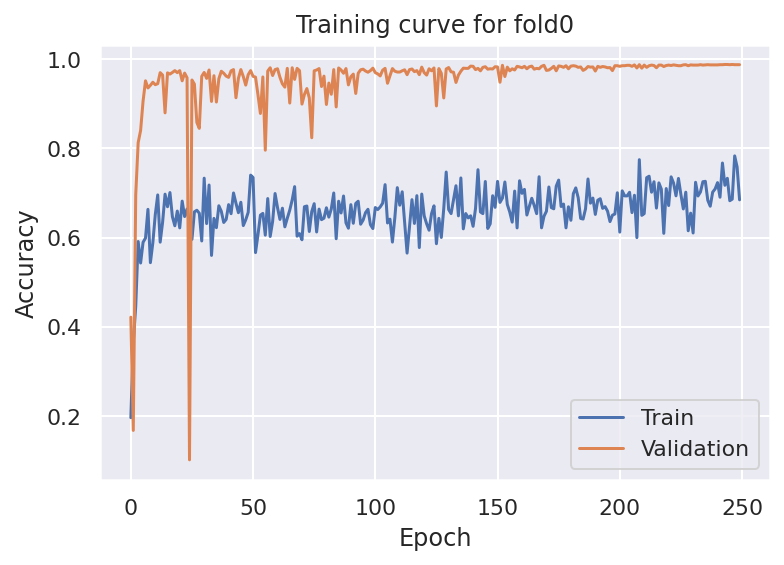

Epoch=0, Train loss=2.97746, Valid loss=1.67047, Train Accuracy=0.27444, Validation Accuracy=0.47075
Epoch=10, Train loss=1.65996, Valid loss=0.36634, Train Accuracy=0.64330, Validation Accuracy=0.96527
Epoch=20, Train loss=1.45713, Valid loss=0.97323, Train Accuracy=0.71835, Validation Accuracy=0.86700
Epoch=30, Train loss=1.47216, Valid loss=0.32429, Train Accuracy=0.71605, Validation Accuracy=0.97806
Epoch=40, Train loss=1.66848, Valid loss=0.60914, Train Accuracy=0.62646, Validation Accuracy=0.97303
Epoch=50, Train loss=1.52469, Valid loss=0.53313, Train Accuracy=0.68949, Validation Accuracy=0.98080
Epoch=60, Train loss=1.55277, Valid loss=0.47338, Train Accuracy=0.66815, Validation Accuracy=0.98492
Epoch=70, Train loss=1.49067, Valid loss=0.71878, Train Accuracy=0.69737, Validation Accuracy=0.95521
Epoch=80, Train loss=1.58416, Valid loss=0.54054, Train Accuracy=0.66547, Validation Accuracy=0.97532
Epoch=90, Train loss=1.58691, Valid loss=0.67188, Train Accuracy=0.65808, Validatio

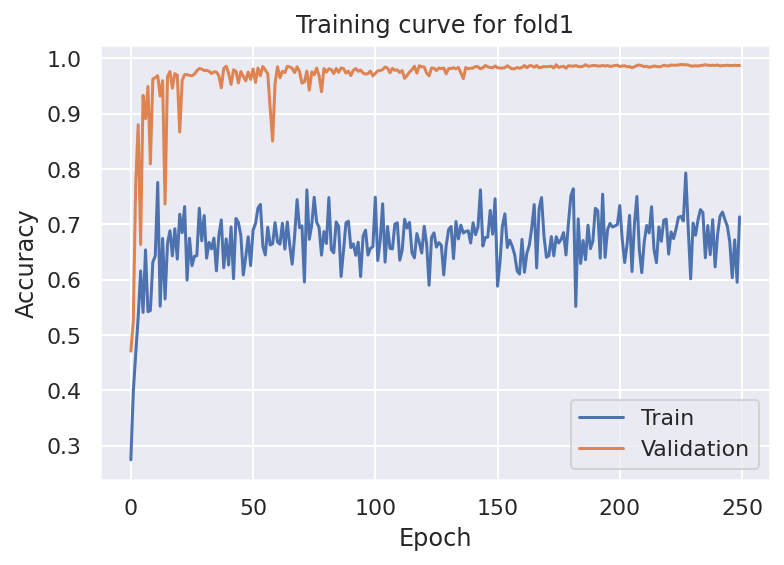

Epoch=0, Train loss=3.04707, Valid loss=1.29743, Train Accuracy=0.24175, Validation Accuracy=0.56379
Epoch=10, Train loss=1.75320, Valid loss=0.72676, Train Accuracy=0.60704, Validation Accuracy=0.94422
Epoch=20, Train loss=1.72180, Valid loss=0.58306, Train Accuracy=0.61175, Validation Accuracy=0.95976
Epoch=30, Train loss=1.59953, Valid loss=0.47610, Train Accuracy=0.66290, Validation Accuracy=0.97988
Epoch=40, Train loss=1.52751, Valid loss=0.40900, Train Accuracy=0.69335, Validation Accuracy=0.97577
Epoch=50, Train loss=1.65304, Valid loss=0.61178, Train Accuracy=0.63962, Validation Accuracy=0.96479
Epoch=60, Train loss=1.49252, Valid loss=0.69895, Train Accuracy=0.69792, Validation Accuracy=0.98217
Epoch=70, Train loss=1.50585, Valid loss=0.54019, Train Accuracy=0.69465, Validation Accuracy=0.98171
Epoch=80, Train loss=1.49157, Valid loss=0.76784, Train Accuracy=0.69845, Validation Accuracy=0.89255
Epoch=90, Train loss=1.58962, Valid loss=0.44557, Train Accuracy=0.65594, Validatio

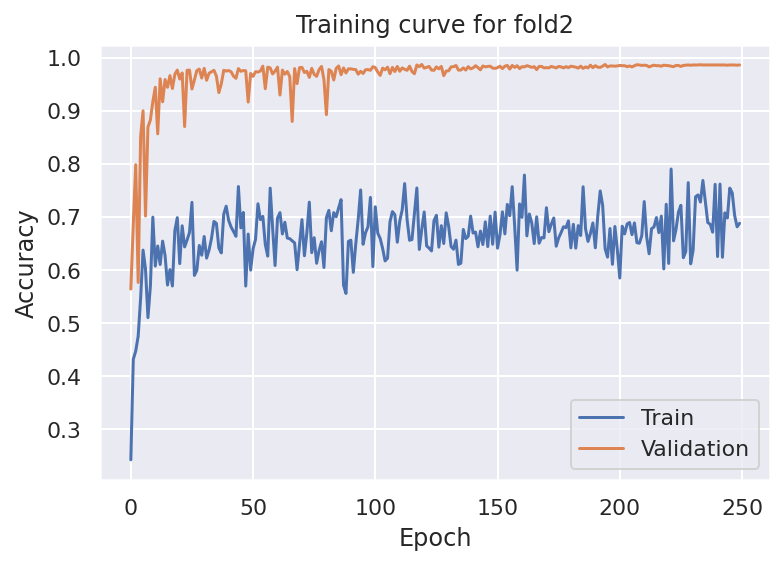

Epoch=0, Train loss=3.18383, Valid loss=1.42770, Train Accuracy=0.23017, Validation Accuracy=0.53245
Epoch=10, Train loss=1.62554, Valid loss=0.62548, Train Accuracy=0.66067, Validation Accuracy=0.93601
Epoch=20, Train loss=1.43283, Valid loss=0.50861, Train Accuracy=0.72346, Validation Accuracy=0.96846
Epoch=30, Train loss=1.70920, Valid loss=0.78471, Train Accuracy=0.62430, Validation Accuracy=0.96984
Epoch=40, Train loss=1.51783, Valid loss=0.76873, Train Accuracy=0.68710, Validation Accuracy=0.97212
Epoch=50, Train loss=1.51806, Valid loss=0.48053, Train Accuracy=0.69629, Validation Accuracy=0.93647
Epoch=60, Train loss=1.48157, Valid loss=0.53310, Train Accuracy=0.70660, Validation Accuracy=0.96938
Epoch=70, Train loss=1.61007, Valid loss=0.57196, Train Accuracy=0.65526, Validation Accuracy=0.97075
Epoch=80, Train loss=1.52575, Valid loss=0.49401, Train Accuracy=0.67889, Validation Accuracy=0.97486
Epoch=90, Train loss=1.48765, Valid loss=0.57178, Train Accuracy=0.70231, Validatio

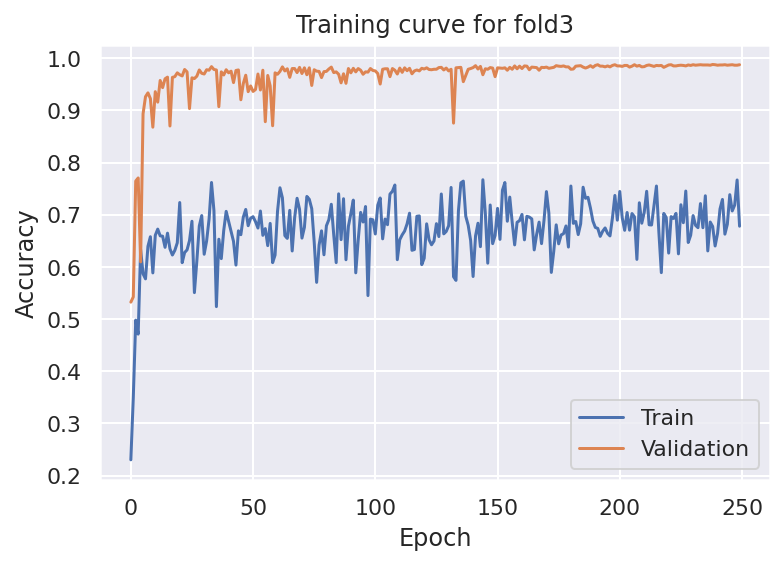

Epoch=0, Train loss=2.99676, Valid loss=1.49616, Train Accuracy=0.24936, Validation Accuracy=0.50731
Epoch=10, Train loss=1.56241, Valid loss=0.51449, Train Accuracy=0.67603, Validation Accuracy=0.95155
Epoch=20, Train loss=1.57380, Valid loss=0.66100, Train Accuracy=0.68058, Validation Accuracy=0.96984
Epoch=30, Train loss=1.45675, Valid loss=0.45602, Train Accuracy=0.71891, Validation Accuracy=0.96344
Epoch=40, Train loss=1.56346, Valid loss=0.66190, Train Accuracy=0.67896, Validation Accuracy=0.95293
Epoch=50, Train loss=1.17869, Valid loss=0.31277, Train Accuracy=0.80993, Validation Accuracy=0.97943
Epoch=60, Train loss=1.51373, Valid loss=0.38118, Train Accuracy=0.68890, Validation Accuracy=0.97212
Epoch=70, Train loss=1.57623, Valid loss=0.45224, Train Accuracy=0.66355, Validation Accuracy=0.96938
Epoch=80, Train loss=1.71275, Valid loss=0.56627, Train Accuracy=0.60411, Validation Accuracy=0.97761
Epoch=90, Train loss=1.50916, Valid loss=0.59198, Train Accuracy=0.68979, Validatio

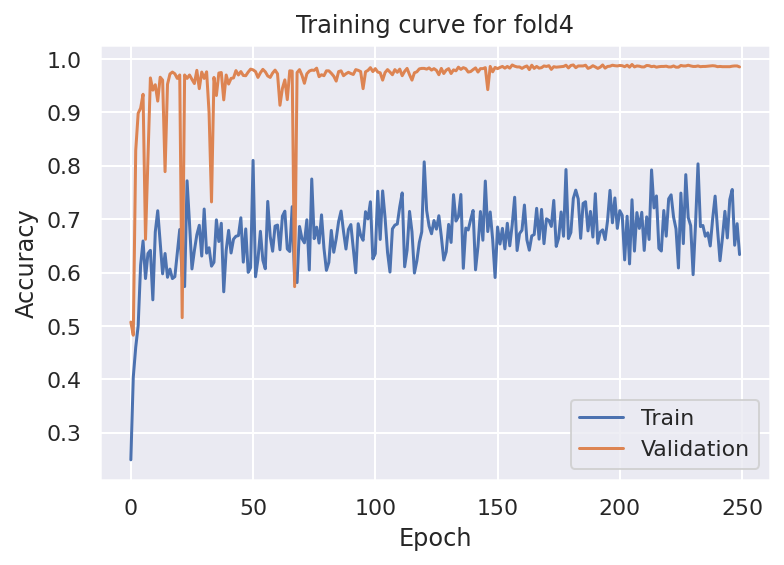

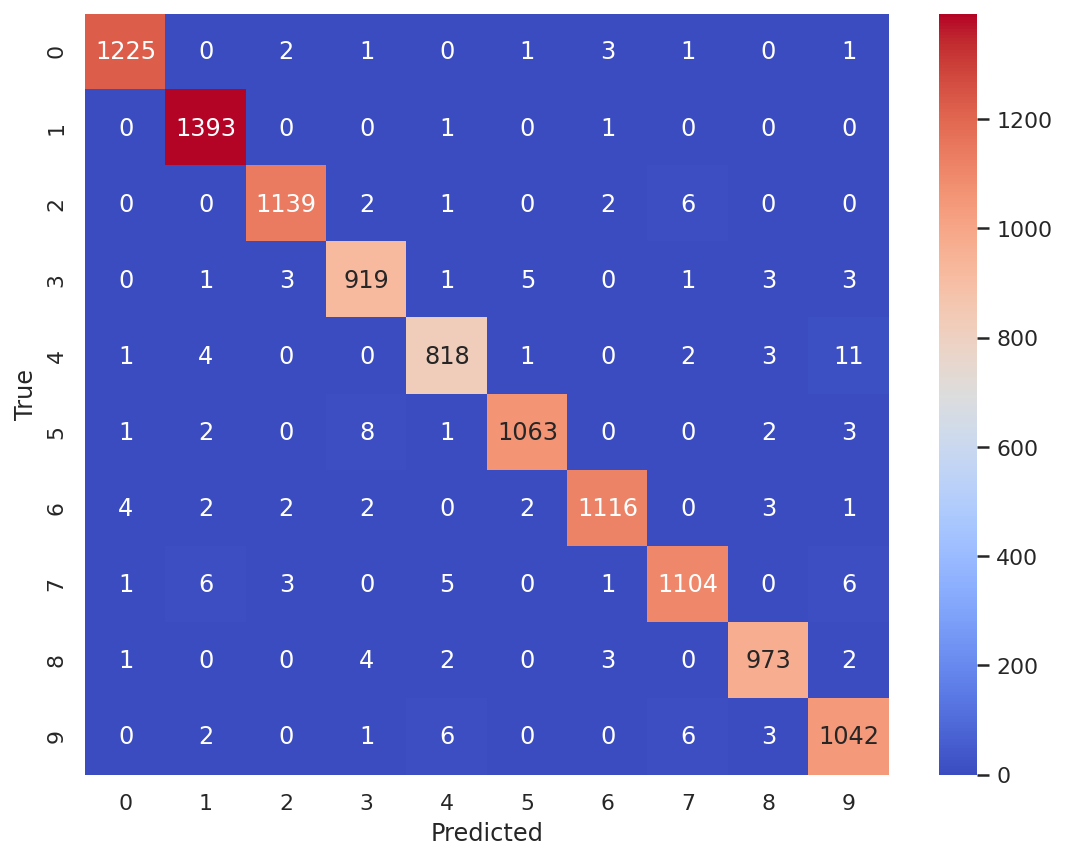

              precision    recall  f1-score   support

         0.0       0.99      0.99      0.99      1234
         1.0       0.99      1.00      0.99      1395
         2.0       0.99      0.99      0.99      1150
         3.0       0.98      0.98      0.98       936
         4.0       0.98      0.97      0.98       840
         5.0       0.99      0.98      0.99      1080
         6.0       0.99      0.99      0.99      1132
         7.0       0.99      0.98      0.98      1126
         8.0       0.99      0.99      0.99       985
         9.0       0.97      0.98      0.98      1060

    accuracy                           0.99     10938
   macro avg       0.99      0.99      0.99     10938
weighted avg       0.99      0.99      0.99     10938

CV Accuracy Score=0.9866520387639423
model=resnet34, optimizer=adam, epochs=250, lr=0.0005, wd=0.0005
CPU times: user 1h 18min 6s, sys: 5min 17s, total: 1h 23min 23s
Wall time: 1h 24min 25s


<IPython.core.display.Javascript object>

In [18]:
%%time
augs = A.Compose([
    A.ShiftScaleRotate(shift_limit=0.0625, scale_limit=0.1, rotate_limit=10, p=0.5),
    A.Normalize(mean=0.143, std=0.254, max_pixel_value=255.0, always_apply=True,),
])
model_name = "resnet34"
optim_name = "adam"
epochs = 250
lr = 5e-4
wd = 5e-4
batch_size = 128
oof, targs = run_pl(pl_1_2, model_name, optim_name, epochs, lr, wd, batch_size=batch_size, augs=augs, label_smooth=True, mixup=False, cutmix=True, version=1, minor=2)
preds = np.argmax(oof, axis=1)
accuracy = metrics.accuracy_score(targs, preds)
print(f"CV Accuracy Score={accuracy}")
print(f"model={model_name}, optimizer={optim_name}, epochs={epochs}, lr={lr}, wd={wd}")

In [23]:
checkpoints = [f"./models/resnet34_fold{fold}_pl_1_2.pth" for fold in range(5)]
model_names = ["resnet34"] * 5
test_df = pd.read_csv(DATA_PATH / "test.csv")
test_probs = engine.infer(model_names, checkpoints, test_df, device=DEVICE)
test_preds = np.argmax(test_probs, axis=1)
np.save("pl_probs_resnet34_1_2.npy", test_probs)

<IPython.core.display.Javascript object>

In [24]:
test_probs = np.load("pl_probs_resnet34_1_2.npy")
test_preds = np.argmax(test_probs, axis=1)
submit = pd.DataFrame({"id": test_df.id.values, "digit": test_preds})
submit.to_csv("pl_submit_resnet34_1_2.csv", index=False)

<IPython.core.display.Javascript object>

### TTA

In [25]:
checkpoints = [f"./models/resnet34_fold{fold}_pl_1_2.pth" for fold in range(5)]
model_names = ["resnet34",] * 5
augs = A.Compose(
    [
        A.ShiftScaleRotate(shift_limit=0.0625, scale_limit=0.1, rotate_limit=10, p=0.5),
        A.Normalize(mean=0.143, std=0.254, max_pixel_value=255.0, always_apply=True,),
    ]
)
test_df = pd.read_csv(DATA_PATH / "test.csv")
test_probs = engine.infer(
    model_names, checkpoints, test_df, device=DEVICE, augs=augs, tta=True
)
test_preds = np.argmax(test_probs, axis=1)
np.save("tta_pl_probs_resnet34_1_2.npy", test_probs)

<IPython.core.display.Javascript object>

In [26]:
test_probs = np.load("tta_pl_probs_resnet34_1_2.npy")
test_preds = np.argmax(test_probs, axis=1)
submit = pd.DataFrame({"id": test_df.id.values, "digit": test_preds})
submit.to_csv("tta_pl_submit_resnet34_1_2.csv", index=False)

<IPython.core.display.Javascript object>

### SWA

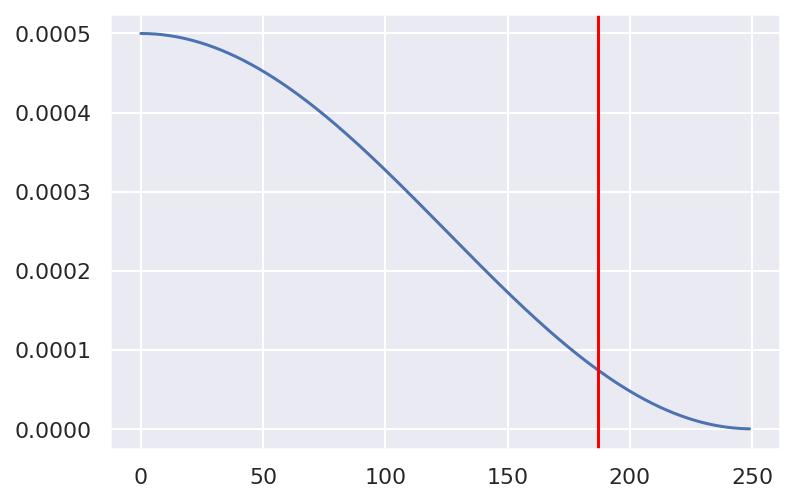

<IPython.core.display.Javascript object>

In [29]:
plot_cosine_annealing(lr=lr, epochs=epochs)

In [45]:
def run_pl_swa(
    pl,
    model_name,
    optim_name,
    epochs,
    lr,
    swa_lr,
    wd,
    batch_size=64,
    augs=None,
    label_smooth=True,
    mixup=False,
    cutmix=False,
    device=DEVICE,
    major=1,
    minor=2,
    seed=SEED,
):
    oof = np.zeros((len(pl), 10))
    targs = np.zeros(len(pl))

    for fold in range(5):
        train_indices = np.load(f"./input/train_fold{fold}_{major}_{minor}.npy")
        valid_indices = np.load(f"./input/valid_fold{fold}_{major}_{minor}.npy")
        train_dataset = dataset.EMNISTDataset(pl, train_indices, augs=augs)
        valid_dataset = dataset.EMNISTDataset(pl, valid_indices)
        train_loader = torch.utils.data.DataLoader(
            train_dataset,
            batch_size=batch_size,
            shuffle=True,
            num_workers=4,
            pin_memory=True,
        )
        valid_loader = torch.utils.data.DataLoader(
            valid_dataset, batch_size=4 * batch_size, num_workers=4, pin_memory=True
        )

        model = get_model(model_name).to(device)
        optimizer = get_optimizer(optim_name, model, lr, wd)
        scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=epochs)
        scaler = torch.cuda.amp.GradScaler()

        swa_start = int(epochs * 0.75)
        steps_per_epoch = len(train_dataset) // batch_size
        optimizer = torchcontrib.optim.SWA(
            optimizer,
            swa_start=swa_start * steps_per_epoch,
            swa_freq=steps_per_epoch,
            swa_lr=swa_lr,
        )

        train_accuracies = []
        valid_accuracies = []

        for epoch in range(epochs):
            # Train
            train_loss, train_accuracy = engine.train(
                train_loader,
                model,
                optimizer,
                device,
                scaler,
                label_smooth=label_smooth,
                mixup=mixup,
                cutmix=cutmix,
            )
            train_accuracies.append(train_accuracy)
            scheduler.step()

            # Validate
            if epoch + 1 >= swa_start:
                optimizer.swap_swa_sgd()
                optimizer.bn_update(train_loader, model, device)
                _, _, valid_loss, valid_accuracy = engine.evaluate(
                    valid_loader, model, device
                )
                optimizer.swap_swa_sgd()
            else:
                _, _, valid_loss, valid_accuracy = engine.evaluate(
                    valid_loader, model, device
                )
            valid_accuracies.append(valid_accuracy)

            if epoch % 10 == 0:
                print(
                    f"Epoch={epoch}, Train loss={train_loss:.5f}, Valid loss={valid_loss:.5f}, Train Accuracy={train_accuracy:.5f}, Validation Accuracy={valid_accuracy:.5f}"
                )

        optimizer.swap_swa_sgd()
        optimizer.bn_update(train_loader, model, device)

        valid_logits, valid_targs, valid_loss, valid_accuracy = engine.evaluate(
            valid_loader, model, device
        )
        print(
            f"Fold={fold}, Valid loss={valid_loss:.5f}, Valid Accuracy={valid_accuracy:.5f}"
        )

        # oof prediction
        oof[valid_indices] = valid_logits
        targs[valid_indices] = valid_targs

        # Save model
        checkpoint = (
            f"./models/swa_{model_name}_fold{fold}_pl_{major}_{minor}_seed{seed}.pth"
        )
        torch.save(model.state_dict(), checkpoint)

        # Plot training curve
        rng = np.arange(len(train_accuracies))
        plt.plot(rng, train_accuracies, label="Train")
        plt.plot(rng, valid_accuracies, label="Validation")
        plt.title(f"Training curve for fold{fold}")
        plt.ylabel("Accuracy")
        plt.xlabel("Epoch")
        plt.legend()
        plt.show()

    oof = scipy.special.softmax(oof, axis=1)

    # Confusion matrix
    conf = metrics.confusion_matrix(targs, np.argmax(oof, axis=1))
    plt.figure(figsize=(9, 7))
    sns.heatmap(conf, cmap="coolwarm", annot=True, fmt="d")
    plt.ylabel("True")
    plt.xlabel("Predicted")
    plt.show()

    # Classification report
    print(metrics.classification_report(targs, np.argmax(oof, axis=1)))

    return oof, targs

<IPython.core.display.Javascript object>

Epoch=0, Train loss=3.13945, Valid loss=2.69568, Train Accuracy=0.21535, Validation Accuracy=0.27984
Epoch=10, Train loss=1.65981, Valid loss=0.47369, Train Accuracy=0.64126, Validation Accuracy=0.96205
Epoch=20, Train loss=1.75267, Valid loss=0.62174, Train Accuracy=0.60394, Validation Accuracy=0.97074
Epoch=30, Train loss=1.74591, Valid loss=0.83776, Train Accuracy=0.60660, Validation Accuracy=0.88980
Epoch=40, Train loss=1.53273, Valid loss=0.34946, Train Accuracy=0.68948, Validation Accuracy=0.97988
Epoch=50, Train loss=1.62947, Valid loss=0.57095, Train Accuracy=0.64562, Validation Accuracy=0.97257
Epoch=60, Train loss=1.74609, Valid loss=0.57988, Train Accuracy=0.59508, Validation Accuracy=0.97851
Epoch=70, Train loss=1.59920, Valid loss=0.41631, Train Accuracy=0.66023, Validation Accuracy=0.97759
Epoch=80, Train loss=1.66538, Valid loss=0.58432, Train Accuracy=0.63040, Validation Accuracy=0.97714
Epoch=90, Train loss=1.57750, Valid loss=0.69642, Train Accuracy=0.66195, Validatio

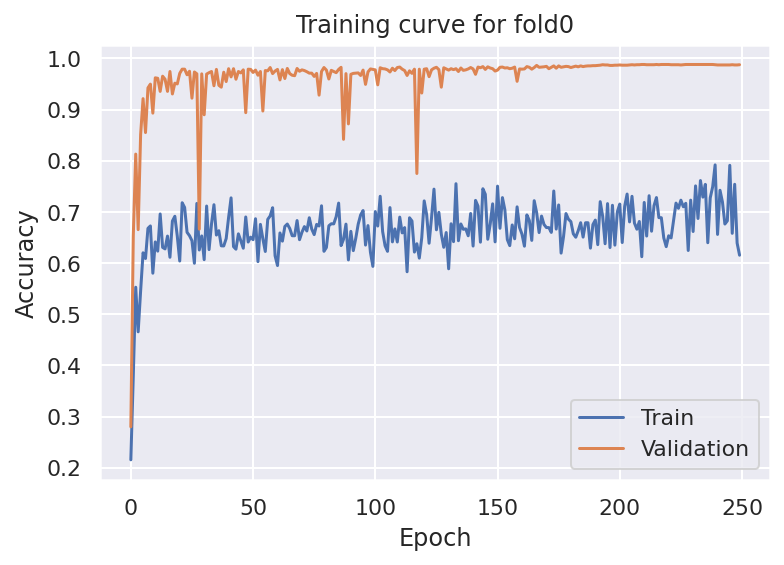

Epoch=0, Train loss=3.17136, Valid loss=1.49859, Train Accuracy=0.23873, Validation Accuracy=0.52377
Epoch=10, Train loss=1.59402, Valid loss=0.52210, Train Accuracy=0.67278, Validation Accuracy=0.95521
Epoch=20, Train loss=1.57724, Valid loss=0.41647, Train Accuracy=0.68400, Validation Accuracy=0.97258
Epoch=30, Train loss=1.53036, Valid loss=0.70530, Train Accuracy=0.69574, Validation Accuracy=0.96161
Epoch=40, Train loss=1.72377, Valid loss=0.90837, Train Accuracy=0.62113, Validation Accuracy=0.94287
Epoch=50, Train loss=1.40290, Valid loss=0.67993, Train Accuracy=0.73763, Validation Accuracy=0.97075
Epoch=60, Train loss=1.41554, Valid loss=0.78268, Train Accuracy=0.73127, Validation Accuracy=0.94653
Epoch=70, Train loss=1.59690, Valid loss=0.59302, Train Accuracy=0.65929, Validation Accuracy=0.98218
Epoch=80, Train loss=1.42179, Valid loss=0.48129, Train Accuracy=0.72501, Validation Accuracy=0.98126
Epoch=90, Train loss=1.55876, Valid loss=0.52740, Train Accuracy=0.66652, Validatio

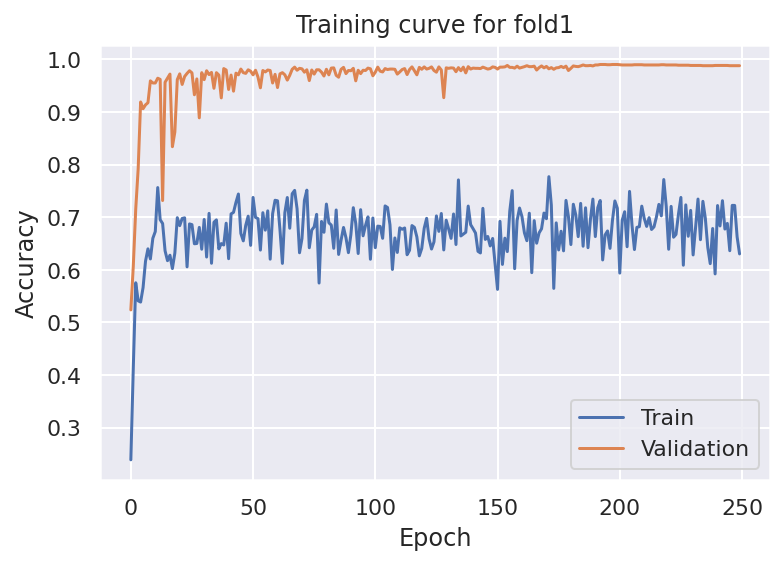

Epoch=0, Train loss=2.89611, Valid loss=2.71429, Train Accuracy=0.29435, Validation Accuracy=0.26063
Epoch=10, Train loss=1.63130, Valid loss=0.57699, Train Accuracy=0.65676, Validation Accuracy=0.91770
Epoch=20, Train loss=1.67892, Valid loss=0.44953, Train Accuracy=0.62778, Validation Accuracy=0.97485
Epoch=30, Train loss=1.63152, Valid loss=0.55924, Train Accuracy=0.64871, Validation Accuracy=0.95473
Epoch=40, Train loss=1.67801, Valid loss=0.53288, Train Accuracy=0.62058, Validation Accuracy=0.97714
Epoch=50, Train loss=1.74355, Valid loss=0.71431, Train Accuracy=0.60407, Validation Accuracy=0.94193
Epoch=60, Train loss=1.60449, Valid loss=0.63704, Train Accuracy=0.65289, Validation Accuracy=0.97028
Epoch=70, Train loss=1.63513, Valid loss=0.70619, Train Accuracy=0.63875, Validation Accuracy=0.92958
Epoch=80, Train loss=1.59788, Valid loss=0.59465, Train Accuracy=0.66324, Validation Accuracy=0.97805
Epoch=90, Train loss=1.52794, Valid loss=0.66621, Train Accuracy=0.67619, Validatio

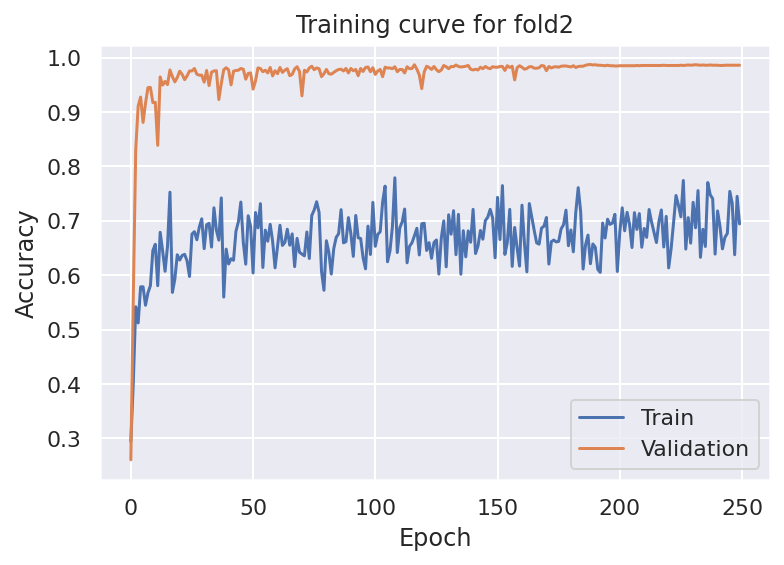

Epoch=0, Train loss=2.89355, Valid loss=1.60269, Train Accuracy=0.24438, Validation Accuracy=0.44424
Epoch=10, Train loss=1.61381, Valid loss=0.48719, Train Accuracy=0.66563, Validation Accuracy=0.94607
Epoch=20, Train loss=1.54663, Valid loss=0.83757, Train Accuracy=0.68644, Validation Accuracy=0.93373
Epoch=30, Train loss=1.48962, Valid loss=0.53693, Train Accuracy=0.70380, Validation Accuracy=0.96389
Epoch=40, Train loss=1.58198, Valid loss=0.48912, Train Accuracy=0.66448, Validation Accuracy=0.95521
Epoch=50, Train loss=1.84408, Valid loss=0.73372, Train Accuracy=0.55877, Validation Accuracy=0.97395
Epoch=60, Train loss=1.53108, Valid loss=0.62026, Train Accuracy=0.68198, Validation Accuracy=0.97441
Epoch=70, Train loss=1.72761, Valid loss=0.69574, Train Accuracy=0.59512, Validation Accuracy=0.97578
Epoch=80, Train loss=1.59050, Valid loss=0.56508, Train Accuracy=0.65600, Validation Accuracy=0.97075
Epoch=90, Train loss=1.56971, Valid loss=0.66337, Train Accuracy=0.66255, Validatio

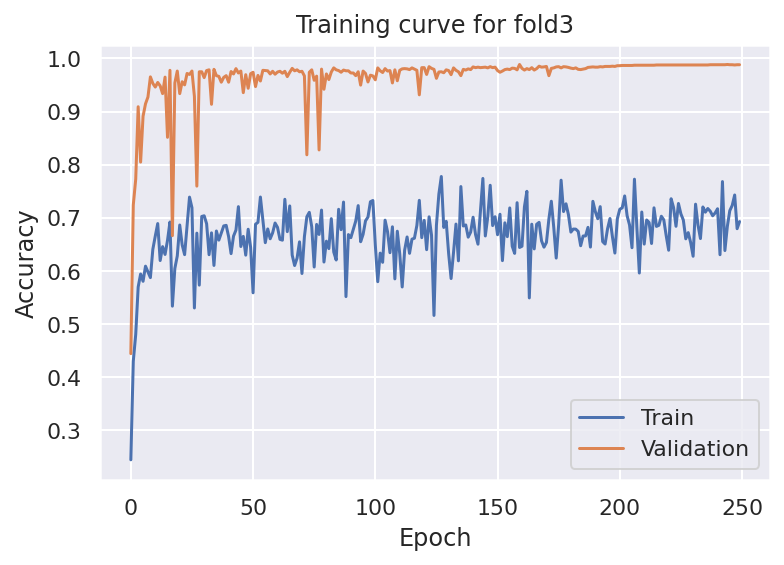

Epoch=0, Train loss=2.98583, Valid loss=2.06158, Train Accuracy=0.20711, Validation Accuracy=0.35695
Epoch=10, Train loss=1.68114, Valid loss=0.72332, Train Accuracy=0.62519, Validation Accuracy=0.92824
Epoch=20, Train loss=1.81029, Valid loss=1.00328, Train Accuracy=0.56862, Validation Accuracy=0.95795
Epoch=30, Train loss=1.70664, Valid loss=0.80791, Train Accuracy=0.62615, Validation Accuracy=0.93282
Epoch=40, Train loss=1.64616, Valid loss=1.07290, Train Accuracy=0.63697, Validation Accuracy=0.83867
Epoch=50, Train loss=1.58271, Valid loss=0.48098, Train Accuracy=0.66675, Validation Accuracy=0.97532
Epoch=60, Train loss=1.56640, Valid loss=0.63099, Train Accuracy=0.67075, Validation Accuracy=0.95658
Epoch=70, Train loss=1.68844, Valid loss=0.42547, Train Accuracy=0.61223, Validation Accuracy=0.98218
Epoch=80, Train loss=1.52444, Valid loss=0.51915, Train Accuracy=0.69409, Validation Accuracy=0.96572
Epoch=90, Train loss=1.65369, Valid loss=0.85439, Train Accuracy=0.62924, Validatio

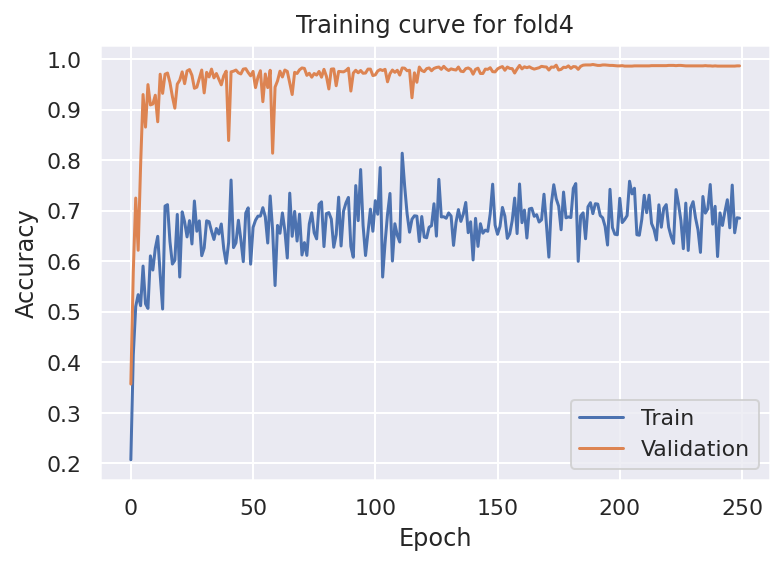

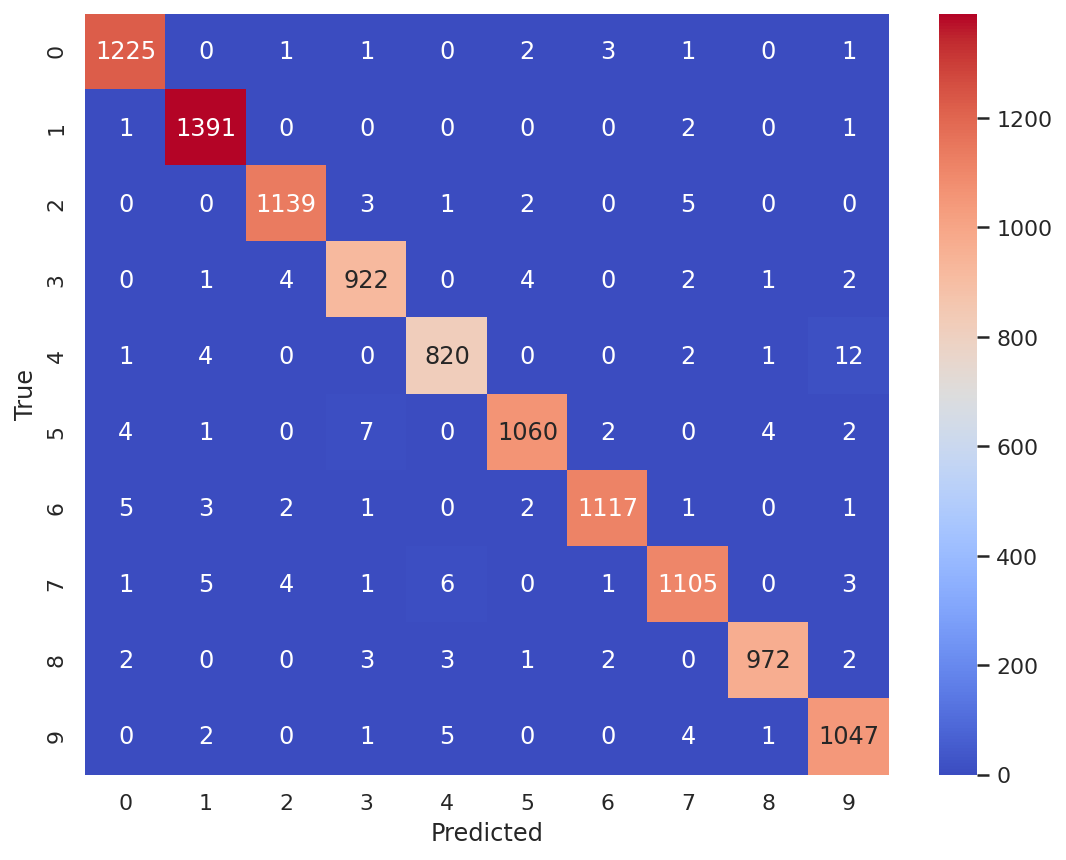

              precision    recall  f1-score   support

         0.0       0.99      0.99      0.99      1234
         1.0       0.99      1.00      0.99      1395
         2.0       0.99      0.99      0.99      1150
         3.0       0.98      0.99      0.98       936
         4.0       0.98      0.98      0.98       840
         5.0       0.99      0.98      0.99      1080
         6.0       0.99      0.99      0.99      1132
         7.0       0.98      0.98      0.98      1126
         8.0       0.99      0.99      0.99       985
         9.0       0.98      0.99      0.98      1060

    accuracy                           0.99     10938
   macro avg       0.99      0.99      0.99     10938
weighted avg       0.99      0.99      0.99     10938

CV Accuracy Score=0.987200585116109
model=resnet34, optimizer=adam, epochs=250, lr=0.0005, wd=0.0005
CPU times: user 1h 26min 17s, sys: 3min 58s, total: 1h 30min 15s
Wall time: 1h 30min 57s


<IPython.core.display.Javascript object>

In [35]:
%%time
augs = A.Compose([
    A.ShiftScaleRotate(shift_limit=0.0625, scale_limit=0.1, rotate_limit=10, p=0.5),
    A.Normalize(mean=0.143, std=0.254, max_pixel_value=255.0, always_apply=True,),
])
model_name = "resnet34"
optim_name = "adam"
epochs = 250
lr = 5e-4
wd = 5e-4
swa_lr = 5e-5
batch_size = 128

oof, targs = run_pl_swa(pl_1_2, model_name, optim_name, epochs, lr, swa_lr, wd, batch_size, augs, label_smooth=True, mixup=False, cutmix=True, device=DEVICE, major=1, minor=2,)
preds = np.argmax(oof, axis=1)
accuracy = metrics.accuracy_score(targs, preds)
print(f"CV Accuracy Score={accuracy}")
print(f"model={model_name}, optimizer={optim_name}, epochs={epochs}, lr={lr}, wd={wd}")

### SWA + TTA

In [36]:
checkpoints = [f"./models/swa_resnet34_fold{fold}_pl_1_2.pth" for fold in range(5)]
model_names = ["resnet34"] * 5
test_df = pd.read_csv(DATA_PATH / "test.csv")
test_probs = engine.infer(
    model_names, checkpoints, test_df, device=DEVICE, augs=augs, tta=True
)
test_preds = np.argmax(test_probs, axis=1)
np.save("swa_tta_pl_probs_resnet34_1_2.npy", test_probs)

<IPython.core.display.Javascript object>

In [37]:
test_probs = np.load("swa_tta_pl_probs_resnet34_1_2.npy")
test_preds = np.argmax(test_probs, axis=1)
submit = pd.DataFrame({"id": test_df.id.values, "digit": test_preds})
submit.to_csv("swa_tta_pl_submit_resnet34_1_2.csv", index=False)

<IPython.core.display.Javascript object>

## Ensemble

In [43]:
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

<IPython.core.display.Javascript object>

### 43

Epoch=0, Train loss=3.36654, Valid loss=3.43993, Train Accuracy=0.23587, Validation Accuracy=0.33973
Epoch=10, Train loss=1.70623, Valid loss=0.48109, Train Accuracy=0.62407, Validation Accuracy=0.94239
Epoch=20, Train loss=1.68087, Valid loss=0.70874, Train Accuracy=0.63535, Validation Accuracy=0.95976
Epoch=30, Train loss=1.69342, Valid loss=0.69512, Train Accuracy=0.62895, Validation Accuracy=0.96296
Epoch=40, Train loss=1.57313, Valid loss=0.38694, Train Accuracy=0.67951, Validation Accuracy=0.97942
Epoch=50, Train loss=1.63837, Valid loss=0.86026, Train Accuracy=0.65265, Validation Accuracy=0.93050
Epoch=60, Train loss=1.59600, Valid loss=0.38809, Train Accuracy=0.66434, Validation Accuracy=0.97668
Epoch=70, Train loss=1.54028, Valid loss=0.38097, Train Accuracy=0.67683, Validation Accuracy=0.97759
Epoch=80, Train loss=1.31277, Valid loss=0.41586, Train Accuracy=0.76960, Validation Accuracy=0.97942
Epoch=90, Train loss=1.45807, Valid loss=0.49029, Train Accuracy=0.71705, Validatio

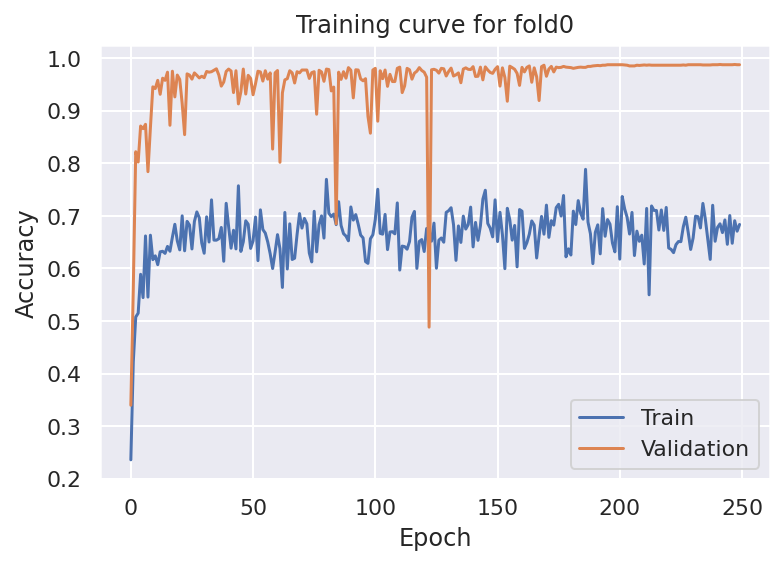

Epoch=0, Train loss=2.99093, Valid loss=1.98813, Train Accuracy=0.26700, Validation Accuracy=0.38254
Epoch=10, Train loss=1.69728, Valid loss=0.52665, Train Accuracy=0.63241, Validation Accuracy=0.95521
Epoch=20, Train loss=1.52167, Valid loss=0.38842, Train Accuracy=0.69961, Validation Accuracy=0.97395
Epoch=30, Train loss=1.41915, Valid loss=0.47201, Train Accuracy=0.73301, Validation Accuracy=0.97898
Epoch=40, Train loss=1.63055, Valid loss=0.48947, Train Accuracy=0.65063, Validation Accuracy=0.97623
Epoch=50, Train loss=1.36425, Valid loss=0.42758, Train Accuracy=0.74496, Validation Accuracy=0.98446
Epoch=60, Train loss=1.38834, Valid loss=0.52939, Train Accuracy=0.73559, Validation Accuracy=0.96801
Epoch=70, Train loss=1.54781, Valid loss=0.59463, Train Accuracy=0.68503, Validation Accuracy=0.96892
Epoch=80, Train loss=1.73560, Valid loss=0.64094, Train Accuracy=0.59587, Validation Accuracy=0.98309
Epoch=90, Train loss=1.41755, Valid loss=0.41081, Train Accuracy=0.72318, Validatio

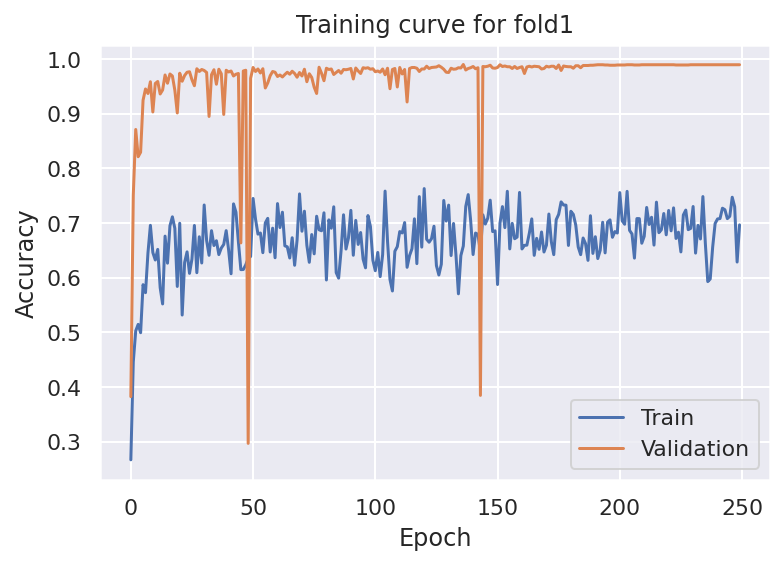

Epoch=0, Train loss=2.95470, Valid loss=1.38924, Train Accuracy=0.27618, Validation Accuracy=0.52675
Epoch=10, Train loss=1.61154, Valid loss=0.70095, Train Accuracy=0.66045, Validation Accuracy=0.93553
Epoch=20, Train loss=1.83602, Valid loss=1.04922, Train Accuracy=0.56685, Validation Accuracy=0.88569
Epoch=30, Train loss=1.69567, Valid loss=0.58438, Train Accuracy=0.61894, Validation Accuracy=0.95336
Epoch=40, Train loss=1.73639, Valid loss=0.53516, Train Accuracy=0.60836, Validation Accuracy=0.97348
Epoch=50, Train loss=1.36282, Valid loss=0.33945, Train Accuracy=0.75291, Validation Accuracy=0.96982
Epoch=60, Train loss=1.72296, Valid loss=0.62779, Train Accuracy=0.60783, Validation Accuracy=0.96388
Epoch=70, Train loss=1.63017, Valid loss=0.52515, Train Accuracy=0.65012, Validation Accuracy=0.98125
Epoch=80, Train loss=1.56517, Valid loss=0.63323, Train Accuracy=0.66925, Validation Accuracy=0.97257
Epoch=90, Train loss=1.66474, Valid loss=0.66432, Train Accuracy=0.62910, Validatio

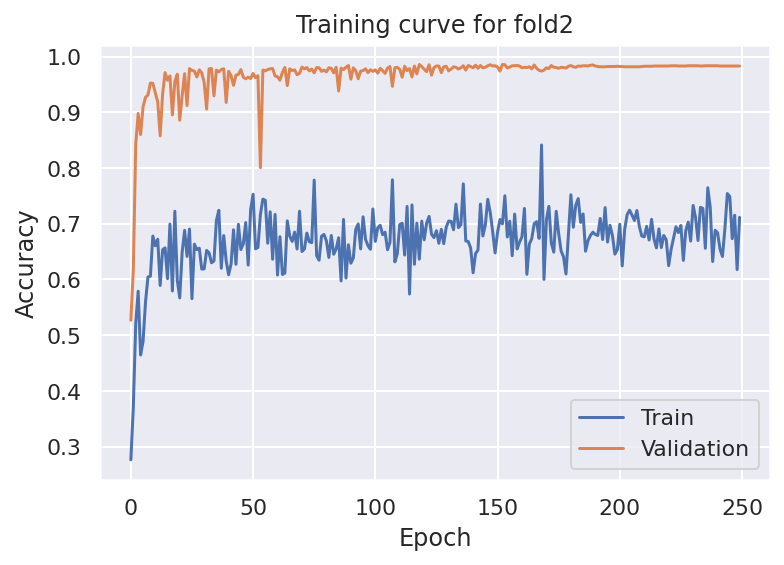

Epoch=0, Train loss=3.07217, Valid loss=1.67827, Train Accuracy=0.23139, Validation Accuracy=0.45430
Epoch=10, Train loss=1.67767, Valid loss=0.59698, Train Accuracy=0.63997, Validation Accuracy=0.94059
Epoch=20, Train loss=1.62120, Valid loss=0.63056, Train Accuracy=0.65902, Validation Accuracy=0.95750
Epoch=30, Train loss=1.56374, Valid loss=0.45563, Train Accuracy=0.67763, Validation Accuracy=0.97806
Epoch=40, Train loss=1.82794, Valid loss=0.73844, Train Accuracy=0.56667, Validation Accuracy=0.96755
Epoch=50, Train loss=1.61624, Valid loss=0.55795, Train Accuracy=0.64022, Validation Accuracy=0.97441
Epoch=60, Train loss=1.55351, Valid loss=0.74512, Train Accuracy=0.68323, Validation Accuracy=0.91225
Epoch=70, Train loss=1.51327, Valid loss=0.65390, Train Accuracy=0.68816, Validation Accuracy=0.97441
Epoch=80, Train loss=1.61324, Valid loss=0.84029, Train Accuracy=0.64725, Validation Accuracy=0.96984
Epoch=90, Train loss=1.67753, Valid loss=0.62998, Train Accuracy=0.61952, Validatio

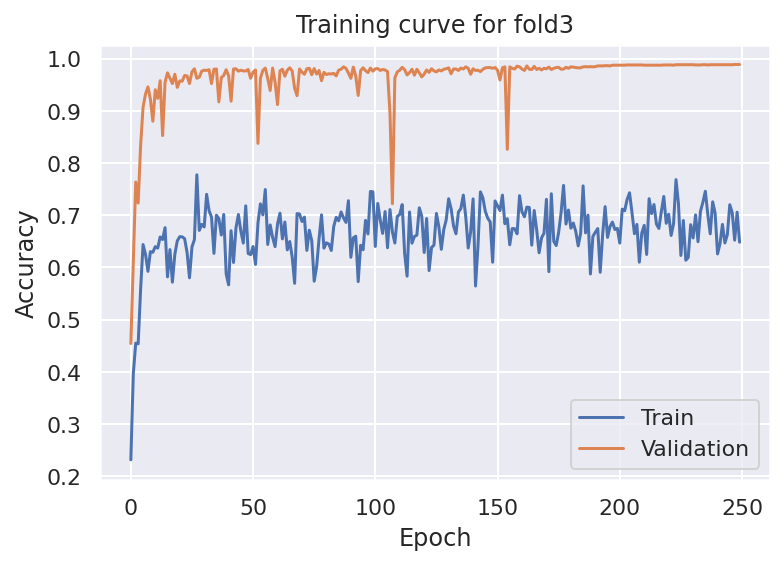

Epoch=0, Train loss=3.11467, Valid loss=1.63231, Train Accuracy=0.26548, Validation Accuracy=0.43739
Epoch=10, Train loss=1.66850, Valid loss=0.87710, Train Accuracy=0.63587, Validation Accuracy=0.91773
Epoch=20, Train loss=1.44849, Valid loss=0.36626, Train Accuracy=0.72805, Validation Accuracy=0.96892
Epoch=30, Train loss=1.70331, Valid loss=0.57792, Train Accuracy=0.62392, Validation Accuracy=0.98218
Epoch=40, Train loss=1.49889, Valid loss=0.55447, Train Accuracy=0.70175, Validation Accuracy=0.97623
Epoch=50, Train loss=1.73656, Valid loss=0.56689, Train Accuracy=0.60537, Validation Accuracy=0.97258
Epoch=60, Train loss=1.54273, Valid loss=0.44743, Train Accuracy=0.69134, Validation Accuracy=0.96572
Epoch=70, Train loss=1.51486, Valid loss=0.64279, Train Accuracy=0.68444, Validation Accuracy=0.97349
Epoch=80, Train loss=1.46700, Valid loss=0.91967, Train Accuracy=0.69833, Validation Accuracy=0.93144
Epoch=90, Train loss=1.54356, Valid loss=0.64016, Train Accuracy=0.67679, Validatio

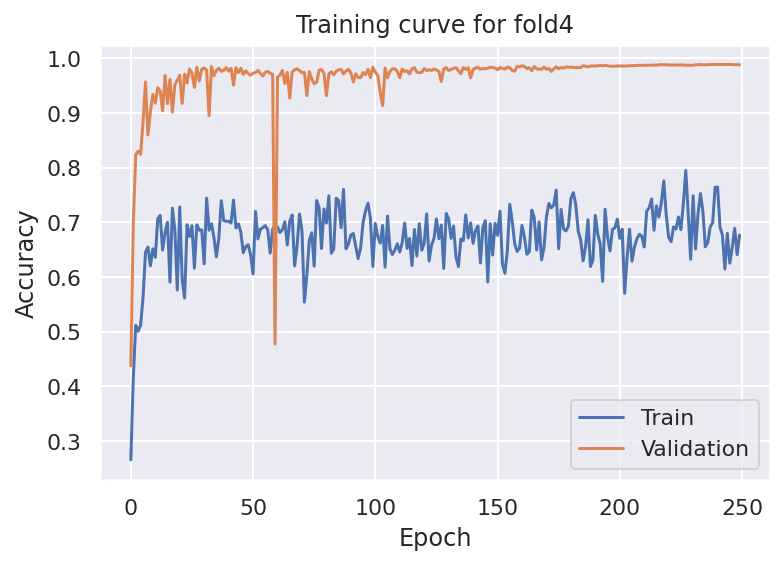

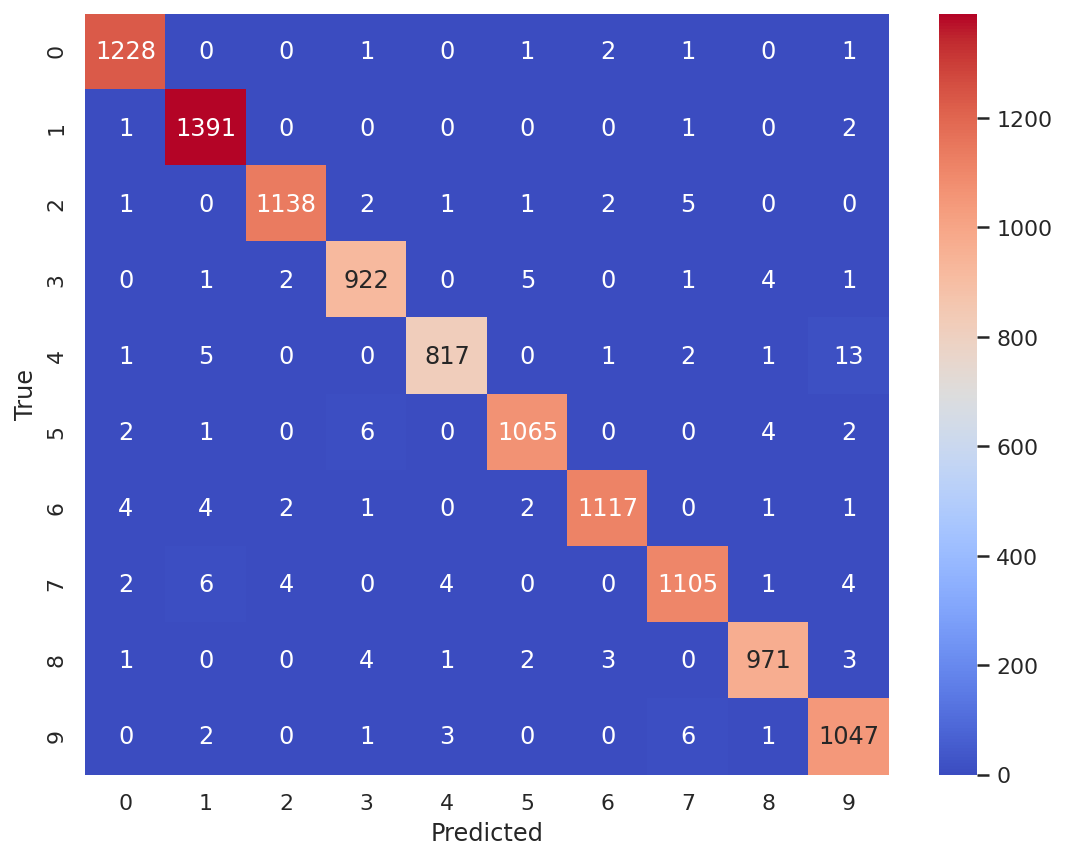

              precision    recall  f1-score   support

         0.0       0.99      1.00      0.99      1234
         1.0       0.99      1.00      0.99      1395
         2.0       0.99      0.99      0.99      1150
         3.0       0.98      0.99      0.98       936
         4.0       0.99      0.97      0.98       840
         5.0       0.99      0.99      0.99      1080
         6.0       0.99      0.99      0.99      1132
         7.0       0.99      0.98      0.98      1126
         8.0       0.99      0.99      0.99       985
         9.0       0.97      0.99      0.98      1060

    accuracy                           0.99     10938
   macro avg       0.99      0.99      0.99     10938
weighted avg       0.99      0.99      0.99     10938

CV Accuracy Score=0.9874748582921924
model=resnet34, optimizer=adam, epochs=250, lr=0.0005, wd=0.0005
CPU times: user 1h 32min 22s, sys: 3min 47s, total: 1h 36min 10s
Wall time: 1h 36min 38s


<IPython.core.display.Javascript object>

In [46]:
%%time
SEED = 43
utils.seed_everything(SEED)

augs = A.Compose([
    A.ShiftScaleRotate(shift_limit=0.0625, scale_limit=0.1, rotate_limit=10, p=0.5),
    A.Normalize(mean=0.143, std=0.254, max_pixel_value=255.0, always_apply=True,),
])
model_name = "resnet34"
optim_name = "adam"
epochs = 250
lr = 5e-4
wd = 5e-4
swa_lr = 5e-5
batch_size = 128

oof, targs = run_pl_swa(pl_1_2, model_name, optim_name, epochs, lr, swa_lr, wd, batch_size, augs, label_smooth=True, mixup=False, cutmix=True, device=DEVICE, major=1, minor=2, seed=SEED,)
preds = np.argmax(oof, axis=1)
accuracy = metrics.accuracy_score(targs, preds)
print(f"CV Accuracy Score={accuracy}")
print(f"model={model_name}, optimizer={optim_name}, epochs={epochs}, lr={lr}, wd={wd}")

In [51]:
%%time
checkpoints = [
    f"./models/swa_resnet34_fold{fold}_pl_1_2_seed{SEED}.pth" for fold in range(5)
]
model_names = ["resnet34"] * 5
test_df = pd.read_csv(DATA_PATH / "test.csv")
test_probs = engine.infer(
    model_names, checkpoints, test_df, device=DEVICE, augs=augs, tta=True
)
test_preds = np.argmax(test_probs, axis=1)
np.save(f"swa_tta_pl_probs_resnet34_1_2_seed{SEED}.npy", test_probs)

<IPython.core.display.Javascript object>

### 44

Epoch=0, Train loss=3.26310, Valid loss=1.39803, Train Accuracy=0.21808, Validation Accuracy=0.53818
Epoch=10, Train loss=1.63578, Valid loss=0.51083, Train Accuracy=0.64855, Validation Accuracy=0.95290
Epoch=20, Train loss=1.55067, Valid loss=0.33604, Train Accuracy=0.68412, Validation Accuracy=0.97851
Epoch=30, Train loss=1.71094, Valid loss=0.57618, Train Accuracy=0.61222, Validation Accuracy=0.97622
Epoch=40, Train loss=1.53230, Valid loss=0.92370, Train Accuracy=0.68902, Validation Accuracy=0.96388
Epoch=50, Train loss=1.68925, Valid loss=1.05176, Train Accuracy=0.62642, Validation Accuracy=0.91907
Epoch=60, Train loss=1.46082, Valid loss=0.44180, Train Accuracy=0.71080, Validation Accuracy=0.98080
Epoch=70, Train loss=1.48812, Valid loss=0.57506, Train Accuracy=0.69665, Validation Accuracy=0.97485
Epoch=80, Train loss=1.68229, Valid loss=0.60502, Train Accuracy=0.61558, Validation Accuracy=0.98034
Epoch=90, Train loss=1.37269, Valid loss=0.41639, Train Accuracy=0.74642, Validatio

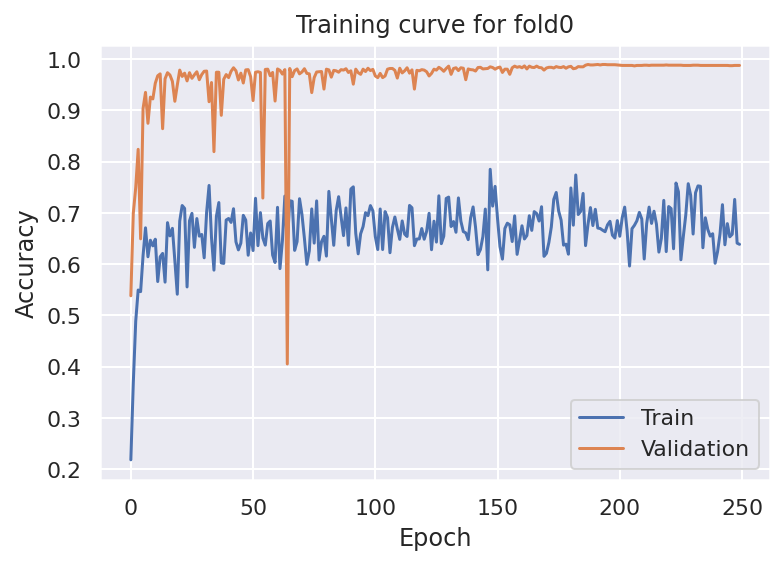

Epoch=0, Train loss=3.02213, Valid loss=1.40824, Train Accuracy=0.26554, Validation Accuracy=0.49954
Epoch=10, Train loss=1.64762, Valid loss=0.40429, Train Accuracy=0.64298, Validation Accuracy=0.95384
Epoch=20, Train loss=1.52019, Valid loss=0.35007, Train Accuracy=0.69609, Validation Accuracy=0.97441
Epoch=30, Train loss=1.49399, Valid loss=0.35319, Train Accuracy=0.69811, Validation Accuracy=0.97532
Epoch=40, Train loss=1.52741, Valid loss=0.53563, Train Accuracy=0.69483, Validation Accuracy=0.97395
Epoch=50, Train loss=1.64375, Valid loss=0.64169, Train Accuracy=0.64479, Validation Accuracy=0.97623
Epoch=60, Train loss=1.55943, Valid loss=0.49842, Train Accuracy=0.67038, Validation Accuracy=0.98126
Epoch=70, Train loss=1.60755, Valid loss=0.57104, Train Accuracy=0.65644, Validation Accuracy=0.98263
Epoch=80, Train loss=1.61285, Valid loss=0.53957, Train Accuracy=0.65224, Validation Accuracy=0.97761
Epoch=90, Train loss=1.53254, Valid loss=0.66391, Train Accuracy=0.67602, Validatio

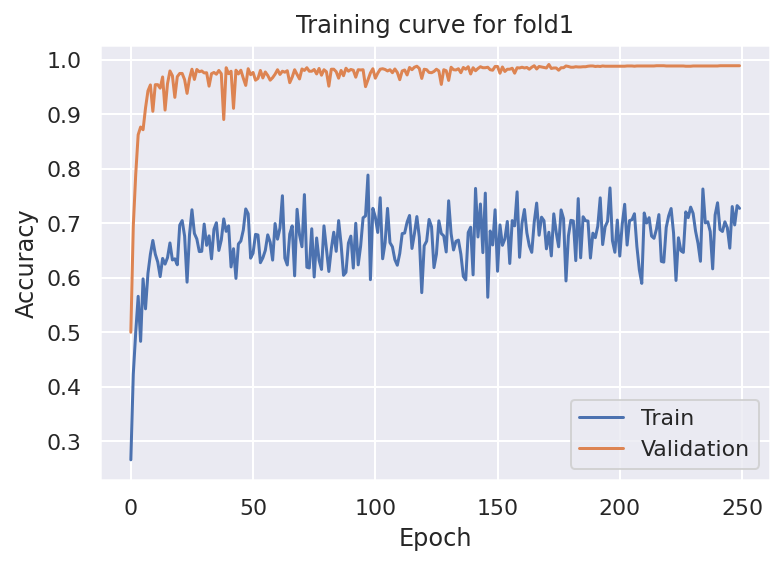

Epoch=0, Train loss=3.13878, Valid loss=1.38787, Train Accuracy=0.23862, Validation Accuracy=0.52538
Epoch=10, Train loss=1.60266, Valid loss=0.75892, Train Accuracy=0.66184, Validation Accuracy=0.93781
Epoch=20, Train loss=1.63645, Valid loss=0.62888, Train Accuracy=0.65234, Validation Accuracy=0.96113
Epoch=30, Train loss=1.60207, Valid loss=0.50335, Train Accuracy=0.66940, Validation Accuracy=0.96342
Epoch=40, Train loss=1.59324, Valid loss=0.97428, Train Accuracy=0.66054, Validation Accuracy=0.84728
Epoch=50, Train loss=1.59281, Valid loss=0.49125, Train Accuracy=0.66086, Validation Accuracy=0.97988
Epoch=60, Train loss=1.61343, Valid loss=0.60568, Train Accuracy=0.65544, Validation Accuracy=0.97074
Epoch=70, Train loss=1.61166, Valid loss=0.63550, Train Accuracy=0.64324, Validation Accuracy=0.97211
Epoch=80, Train loss=1.65574, Valid loss=0.69908, Train Accuracy=0.63048, Validation Accuracy=0.97622
Epoch=90, Train loss=1.36160, Valid loss=0.46769, Train Accuracy=0.74692, Validatio

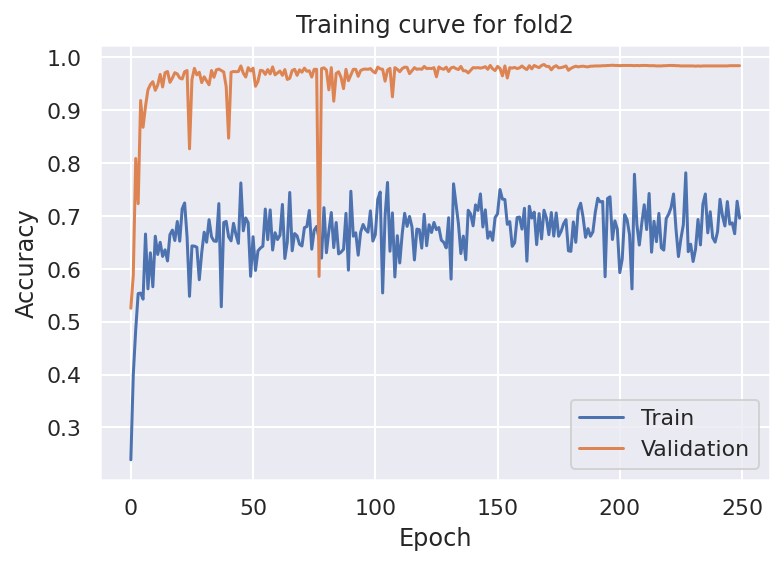

Epoch=0, Train loss=3.09337, Valid loss=1.71984, Train Accuracy=0.24847, Validation Accuracy=0.34141
Epoch=10, Train loss=1.77770, Valid loss=0.40647, Train Accuracy=0.58128, Validation Accuracy=0.96252
Epoch=20, Train loss=1.71690, Valid loss=0.47556, Train Accuracy=0.61739, Validation Accuracy=0.97441
Epoch=30, Train loss=1.67052, Valid loss=0.55272, Train Accuracy=0.63656, Validation Accuracy=0.96801
Epoch=40, Train loss=1.64306, Valid loss=0.49513, Train Accuracy=0.64641, Validation Accuracy=0.96115
Epoch=50, Train loss=1.61807, Valid loss=0.41034, Train Accuracy=0.64271, Validation Accuracy=0.97898
Epoch=60, Train loss=1.58012, Valid loss=0.58553, Train Accuracy=0.66892, Validation Accuracy=0.97303
Epoch=70, Train loss=1.61693, Valid loss=0.50780, Train Accuracy=0.64028, Validation Accuracy=0.97623
Epoch=80, Train loss=1.63664, Valid loss=0.58895, Train Accuracy=0.63640, Validation Accuracy=0.96618
Epoch=90, Train loss=1.46570, Valid loss=0.50854, Train Accuracy=0.70472, Validatio

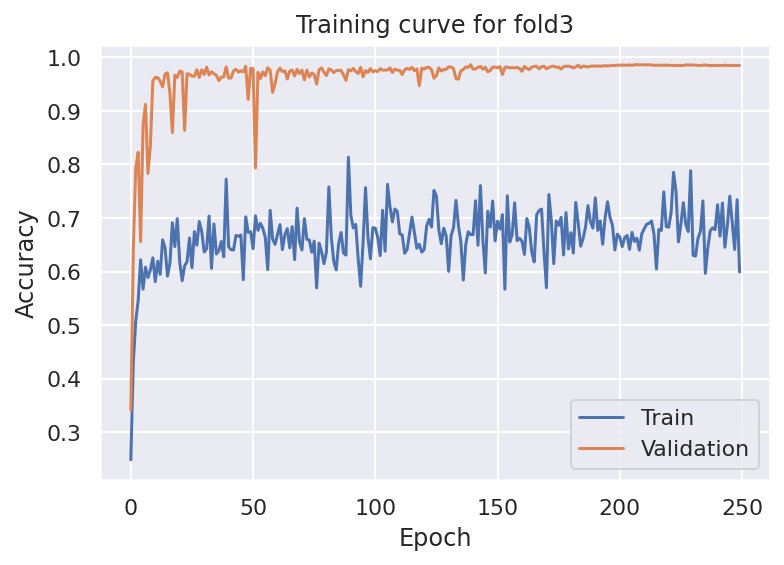

Epoch=0, Train loss=2.94165, Valid loss=2.18176, Train Accuracy=0.24286, Validation Accuracy=0.33272
Epoch=10, Train loss=1.51157, Valid loss=0.38161, Train Accuracy=0.70334, Validation Accuracy=0.96069
Epoch=20, Train loss=1.74299, Valid loss=0.50179, Train Accuracy=0.61113, Validation Accuracy=0.96207
Epoch=30, Train loss=1.44346, Valid loss=0.39895, Train Accuracy=0.71944, Validation Accuracy=0.97623
Epoch=40, Train loss=1.82244, Valid loss=0.71904, Train Accuracy=0.56829, Validation Accuracy=0.96389
Epoch=50, Train loss=1.49246, Valid loss=0.40872, Train Accuracy=0.70003, Validation Accuracy=0.98035
Epoch=60, Train loss=1.40028, Valid loss=0.36087, Train Accuracy=0.73565, Validation Accuracy=0.97578
Epoch=70, Train loss=1.54080, Valid loss=0.57548, Train Accuracy=0.67273, Validation Accuracy=0.97075
Epoch=80, Train loss=1.67444, Valid loss=0.63001, Train Accuracy=0.61659, Validation Accuracy=0.98080
Epoch=90, Train loss=1.47073, Valid loss=0.49381, Train Accuracy=0.70650, Validatio

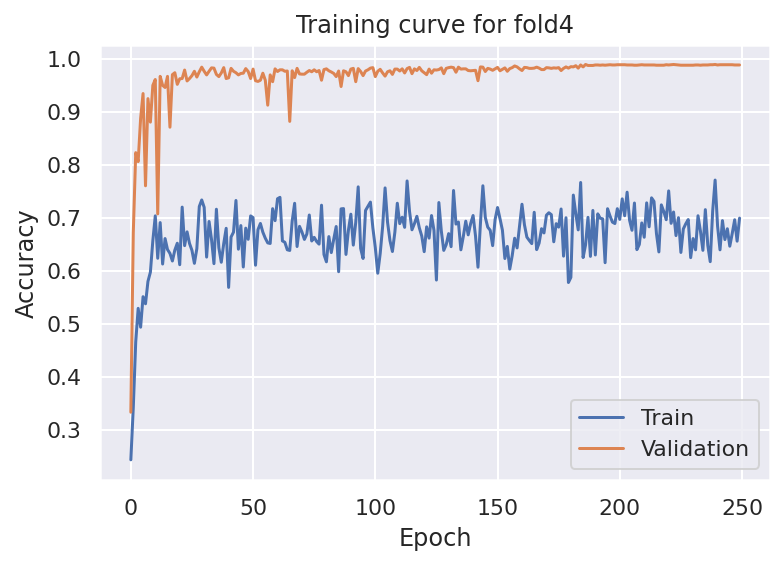

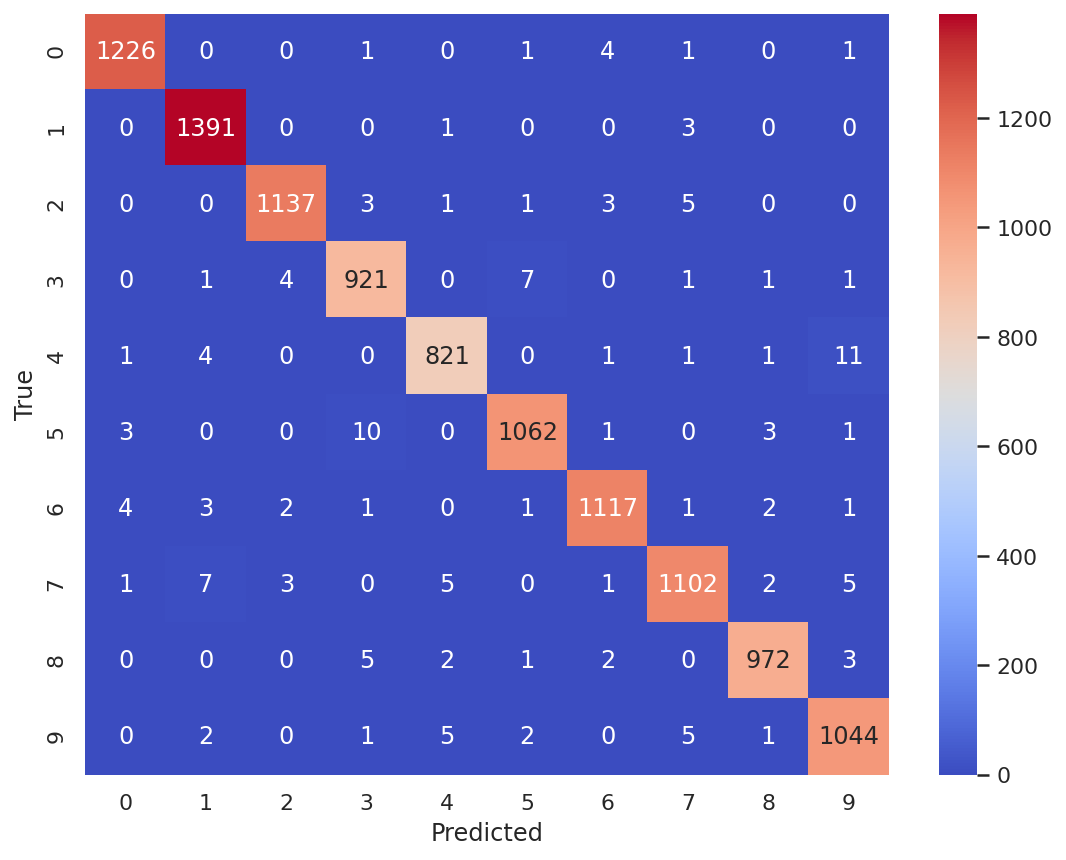

              precision    recall  f1-score   support

         0.0       0.99      0.99      0.99      1234
         1.0       0.99      1.00      0.99      1395
         2.0       0.99      0.99      0.99      1150
         3.0       0.98      0.98      0.98       936
         4.0       0.98      0.98      0.98       840
         5.0       0.99      0.98      0.99      1080
         6.0       0.99      0.99      0.99      1132
         7.0       0.98      0.98      0.98      1126
         8.0       0.99      0.99      0.99       985
         9.0       0.98      0.98      0.98      1060

    accuracy                           0.99     10938
   macro avg       0.99      0.99      0.99     10938
weighted avg       0.99      0.99      0.99     10938

CV Accuracy Score=0.9867434631559701
model=resnet34, optimizer=adam, epochs=250, lr=0.0005, wd=0.0005
CPU times: user 1h 32min 47s, sys: 3min 47s, total: 1h 36min 34s
Wall time: 1h 37min 3s


<IPython.core.display.Javascript object>

In [52]:
%%time
SEED = 44
utils.seed_everything(SEED)

augs = A.Compose([
    A.ShiftScaleRotate(shift_limit=0.0625, scale_limit=0.1, rotate_limit=10, p=0.5),
    A.Normalize(mean=0.143, std=0.254, max_pixel_value=255.0, always_apply=True,),
])
model_name = "resnet34"
optim_name = "adam"
epochs = 250
lr = 5e-4
wd = 5e-4
swa_lr = 5e-5
batch_size = 128

oof, targs = run_pl_swa(pl_1_2, model_name, optim_name, epochs, lr, swa_lr, wd, batch_size, augs, label_smooth=True, mixup=False, cutmix=True, device=DEVICE, major=1, minor=2, seed=SEED,)
preds = np.argmax(oof, axis=1)
accuracy = metrics.accuracy_score(targs, preds)
print(f"CV Accuracy Score={accuracy}")
print(f"model={model_name}, optimizer={optim_name}, epochs={epochs}, lr={lr}, wd={wd}")

In [53]:
%%time
checkpoints = [
    f"./models/swa_resnet34_fold{fold}_pl_1_2_seed{SEED}.pth" for fold in range(5)
]
model_names = ["resnet34"] * 5
test_df = pd.read_csv(DATA_PATH / "test.csv")
test_probs = engine.infer(
    model_names, checkpoints, test_df, device=DEVICE, augs=augs, tta=True
)
test_preds = np.argmax(test_probs, axis=1)
np.save(f"swa_tta_pl_probs_resnet34_1_2_seed{SEED}.npy", test_probs)

CPU times: user 1min 39s, sys: 2.23 s, total: 1min 41s
Wall time: 1min 43s


<IPython.core.display.Javascript object>

### 45

Epoch=0, Train loss=3.37552, Valid loss=1.59375, Train Accuracy=0.20810, Validation Accuracy=0.48057
Epoch=10, Train loss=1.72062, Valid loss=0.59549, Train Accuracy=0.61748, Validation Accuracy=0.94696
Epoch=20, Train loss=1.83432, Valid loss=0.35883, Train Accuracy=0.56469, Validation Accuracy=0.97439
Epoch=30, Train loss=1.69559, Valid loss=0.73694, Train Accuracy=0.62499, Validation Accuracy=0.96616
Epoch=40, Train loss=1.74678, Valid loss=0.91568, Train Accuracy=0.59986, Validation Accuracy=0.95153
Epoch=50, Train loss=1.61072, Valid loss=0.89301, Train Accuracy=0.65853, Validation Accuracy=0.97302
Epoch=60, Train loss=1.54457, Valid loss=0.43664, Train Accuracy=0.68045, Validation Accuracy=0.98034
Epoch=70, Train loss=1.48023, Valid loss=0.92625, Train Accuracy=0.69398, Validation Accuracy=0.91861
Epoch=80, Train loss=1.59136, Valid loss=0.99818, Train Accuracy=0.65606, Validation Accuracy=0.94879
Epoch=90, Train loss=1.66631, Valid loss=0.65026, Train Accuracy=0.62729, Validatio

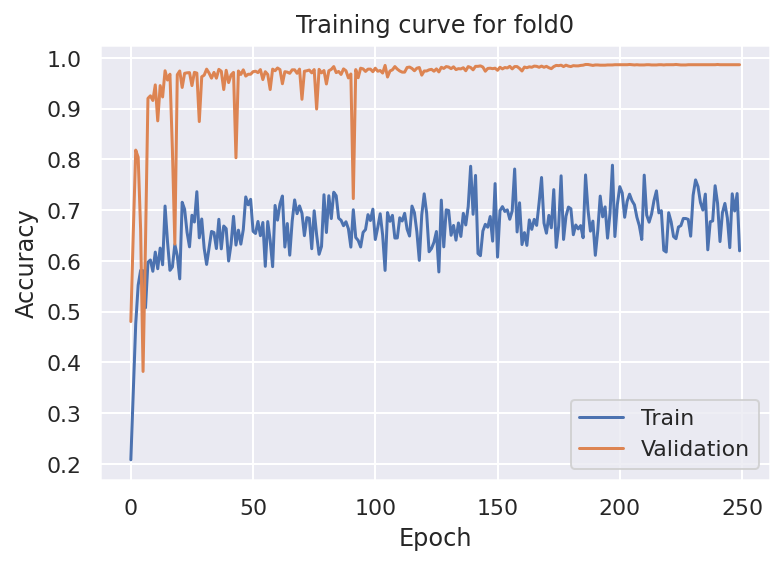

Epoch=0, Train loss=2.88203, Valid loss=1.46985, Train Accuracy=0.27707, Validation Accuracy=0.55027
Epoch=10, Train loss=1.59902, Valid loss=0.27360, Train Accuracy=0.65790, Validation Accuracy=0.96938
Epoch=20, Train loss=1.58794, Valid loss=0.70285, Train Accuracy=0.67269, Validation Accuracy=0.96435
Epoch=30, Train loss=1.51240, Valid loss=0.53368, Train Accuracy=0.69673, Validation Accuracy=0.96846
Epoch=40, Train loss=1.53938, Valid loss=0.49453, Train Accuracy=0.68610, Validation Accuracy=0.97486
Epoch=50, Train loss=1.42180, Valid loss=0.54224, Train Accuracy=0.72442, Validation Accuracy=0.97943
Epoch=60, Train loss=1.41995, Valid loss=0.41731, Train Accuracy=0.72173, Validation Accuracy=0.97898
Epoch=70, Train loss=1.36052, Valid loss=0.50898, Train Accuracy=0.74249, Validation Accuracy=0.97212
Epoch=80, Train loss=1.67170, Valid loss=0.60780, Train Accuracy=0.62197, Validation Accuracy=0.97989
Epoch=90, Train loss=1.53536, Valid loss=0.46728, Train Accuracy=0.67871, Validatio

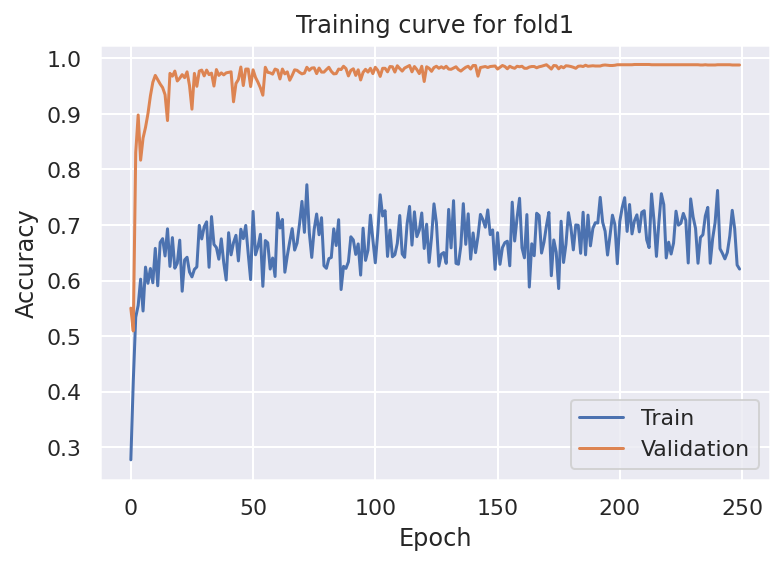

Epoch=0, Train loss=3.04803, Valid loss=1.85859, Train Accuracy=0.23371, Validation Accuracy=0.32830
Epoch=10, Train loss=1.53178, Valid loss=0.69488, Train Accuracy=0.68641, Validation Accuracy=0.93461
Epoch=20, Train loss=1.60284, Valid loss=0.85228, Train Accuracy=0.67280, Validation Accuracy=0.94467
Epoch=30, Train loss=1.58337, Valid loss=0.56771, Train Accuracy=0.67135, Validation Accuracy=0.97577
Epoch=40, Train loss=1.61591, Valid loss=0.46757, Train Accuracy=0.65720, Validation Accuracy=0.97485
Epoch=50, Train loss=1.48683, Valid loss=0.47768, Train Accuracy=0.70742, Validation Accuracy=0.97668
Epoch=60, Train loss=1.51145, Valid loss=0.62073, Train Accuracy=0.69422, Validation Accuracy=0.97577
Epoch=70, Train loss=1.50399, Valid loss=0.47840, Train Accuracy=0.69339, Validation Accuracy=0.96616
Epoch=80, Train loss=1.63370, Valid loss=0.63547, Train Accuracy=0.64208, Validation Accuracy=0.97577
Epoch=90, Train loss=1.52317, Valid loss=0.82550, Train Accuracy=0.68399, Validatio

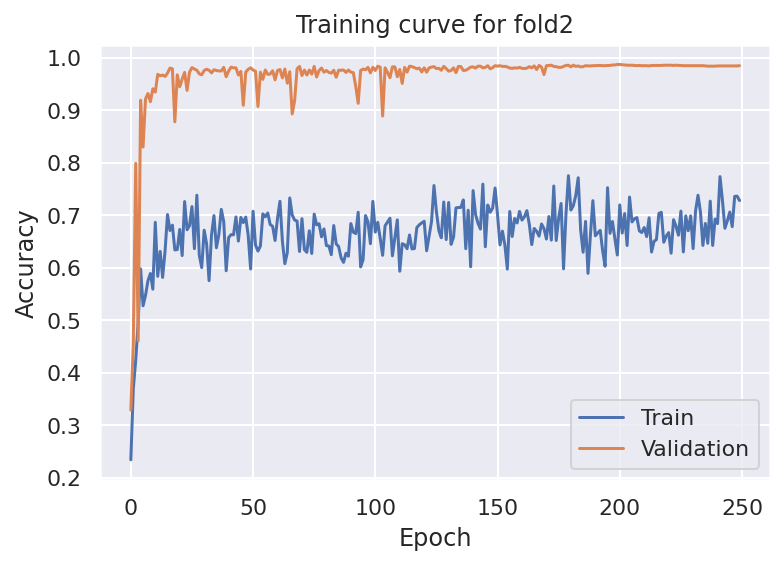

Epoch=0, Train loss=3.08541, Valid loss=1.59725, Train Accuracy=0.23784, Validation Accuracy=0.46709
Epoch=10, Train loss=1.53659, Valid loss=0.35125, Train Accuracy=0.69613, Validation Accuracy=0.96846
Epoch=20, Train loss=1.46317, Valid loss=0.94995, Train Accuracy=0.71881, Validation Accuracy=0.91682
Epoch=30, Train loss=1.54123, Valid loss=0.28229, Train Accuracy=0.68645, Validation Accuracy=0.97669
Epoch=40, Train loss=1.51807, Valid loss=0.55356, Train Accuracy=0.69764, Validation Accuracy=0.97715
Epoch=50, Train loss=1.64077, Valid loss=0.71243, Train Accuracy=0.64017, Validation Accuracy=0.94927
Epoch=60, Train loss=1.69258, Valid loss=0.61338, Train Accuracy=0.61962, Validation Accuracy=0.95932
Epoch=70, Train loss=1.54820, Valid loss=0.51952, Train Accuracy=0.67601, Validation Accuracy=0.97898
Epoch=80, Train loss=1.44329, Valid loss=0.79473, Train Accuracy=0.71231, Validation Accuracy=0.90951
Epoch=90, Train loss=1.58999, Valid loss=0.57326, Train Accuracy=0.65453, Validatio

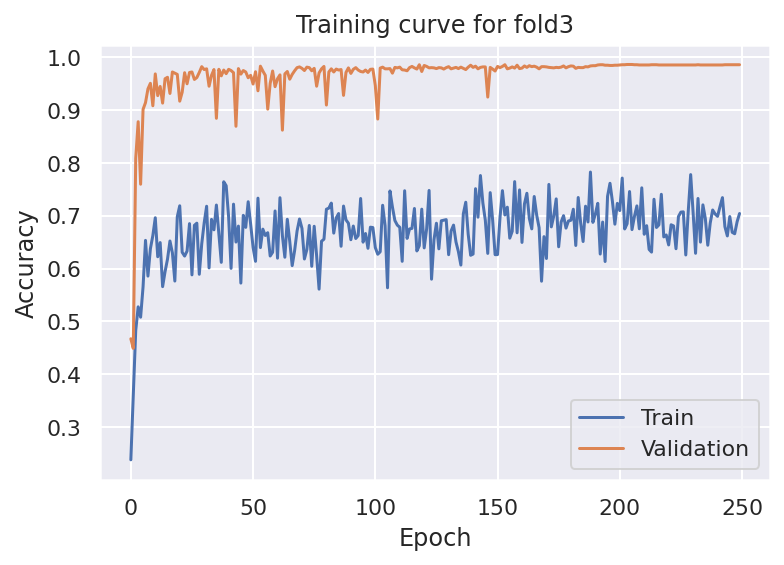

Epoch=0, Train loss=3.10325, Valid loss=1.42004, Train Accuracy=0.26054, Validation Accuracy=0.54799
Epoch=10, Train loss=1.74964, Valid loss=1.09516, Train Accuracy=0.60213, Validation Accuracy=0.73857
Epoch=20, Train loss=1.38581, Valid loss=0.73196, Train Accuracy=0.74533, Validation Accuracy=0.96344
Epoch=30, Train loss=1.48629, Valid loss=0.54416, Train Accuracy=0.70448, Validation Accuracy=0.97349
Epoch=40, Train loss=1.56887, Valid loss=0.41160, Train Accuracy=0.67452, Validation Accuracy=0.97806
Epoch=50, Train loss=1.50947, Valid loss=0.46895, Train Accuracy=0.69517, Validation Accuracy=0.97806
Epoch=60, Train loss=1.66830, Valid loss=0.61060, Train Accuracy=0.63619, Validation Accuracy=0.97806
Epoch=70, Train loss=1.54727, Valid loss=0.53195, Train Accuracy=0.68239, Validation Accuracy=0.97441
Epoch=80, Train loss=1.68737, Valid loss=0.49606, Train Accuracy=0.61355, Validation Accuracy=0.97212
Epoch=90, Train loss=1.29575, Valid loss=0.47624, Train Accuracy=0.76680, Validatio

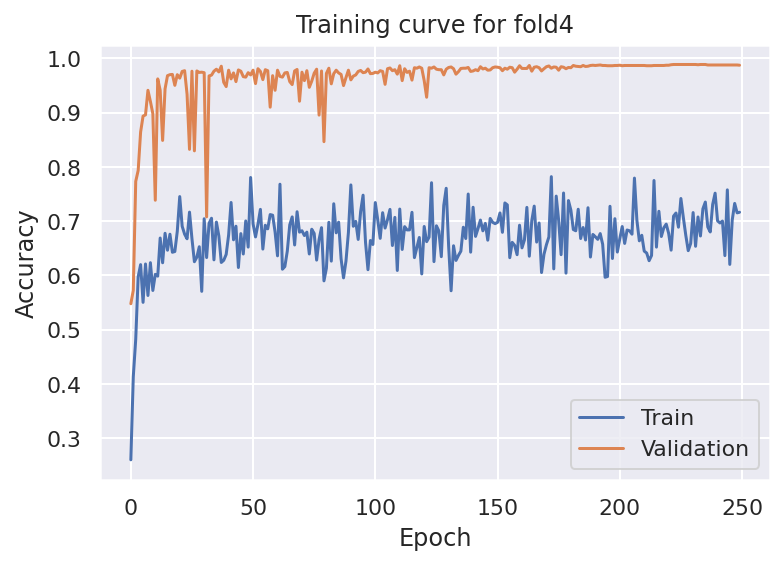

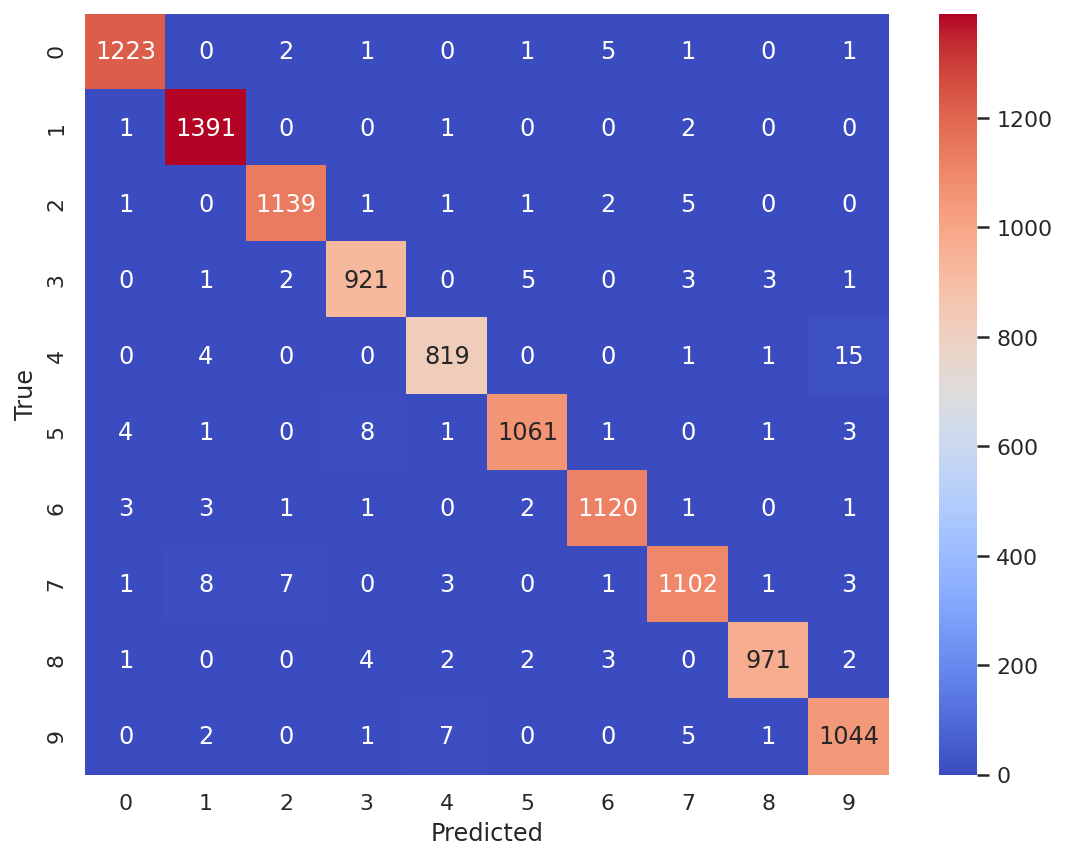

              precision    recall  f1-score   support

         0.0       0.99      0.99      0.99      1234
         1.0       0.99      1.00      0.99      1395
         2.0       0.99      0.99      0.99      1150
         3.0       0.98      0.98      0.98       936
         4.0       0.98      0.97      0.98       840
         5.0       0.99      0.98      0.99      1080
         6.0       0.99      0.99      0.99      1132
         7.0       0.98      0.98      0.98      1126
         8.0       0.99      0.99      0.99       985
         9.0       0.98      0.98      0.98      1060

    accuracy                           0.99     10938
   macro avg       0.99      0.99      0.99     10938
weighted avg       0.99      0.99      0.99     10938

CV Accuracy Score=0.9865606143719144
model=resnet34, optimizer=adam, epochs=250, lr=0.0005, wd=0.0005
CPU times: user 1h 32min 45s, sys: 3min 47s, total: 1h 36min 33s
Wall time: 1h 37min 15s


<IPython.core.display.Javascript object>

In [54]:
%%time
SEED = 45
utils.seed_everything(SEED)

augs = A.Compose([
    A.ShiftScaleRotate(shift_limit=0.0625, scale_limit=0.1, rotate_limit=10, p=0.5),
    A.Normalize(mean=0.143, std=0.254, max_pixel_value=255.0, always_apply=True,),
])
model_name = "resnet34"
optim_name = "adam"
epochs = 250
lr = 5e-4
wd = 5e-4
swa_lr = 5e-5
batch_size = 128

oof, targs = run_pl_swa(pl_1_2, model_name, optim_name, epochs, lr, swa_lr, wd, batch_size, augs, label_smooth=True, mixup=False, cutmix=True, device=DEVICE, major=1, minor=2, seed=SEED,)
preds = np.argmax(oof, axis=1)
accuracy = metrics.accuracy_score(targs, preds)
print(f"CV Accuracy Score={accuracy}")
print(f"model={model_name}, optimizer={optim_name}, epochs={epochs}, lr={lr}, wd={wd}")

In [55]:
%%time
checkpoints = [f"./models/swa_resnet34_fold{fold}_pl_1_2_seed{SEED}.pth" for fold in range(5)]
model_names = ["resnet34"] * 5
test_df = pd.read_csv(DATA_PATH / "test.csv")
test_probs = engine.infer(model_names, checkpoints, test_df, device=DEVICE, augs=augs, tta=True)
test_preds = np.argmax(test_probs, axis=1)
np.save(f"swa_tta_pl_probs_resnet34_1_2_seed{SEED}.npy", test_probs)

CPU times: user 1min 39s, sys: 2.19 s, total: 1min 41s
Wall time: 1min 43s


<IPython.core.display.Javascript object>

### 46

Epoch=0, Train loss=3.52104, Valid loss=2.06910, Train Accuracy=0.18974, Validation Accuracy=0.34797
Epoch=10, Train loss=1.69249, Valid loss=1.01862, Train Accuracy=0.63419, Validation Accuracy=0.82716
Epoch=20, Train loss=1.62396, Valid loss=0.56829, Train Accuracy=0.65569, Validation Accuracy=0.95930
Epoch=30, Train loss=1.74089, Valid loss=0.71626, Train Accuracy=0.61255, Validation Accuracy=0.96571
Epoch=40, Train loss=1.65055, Valid loss=0.51425, Train Accuracy=0.64896, Validation Accuracy=0.96708
Epoch=50, Train loss=1.62501, Valid loss=0.53935, Train Accuracy=0.64856, Validation Accuracy=0.97714
Epoch=60, Train loss=1.35635, Valid loss=0.42268, Train Accuracy=0.76422, Validation Accuracy=0.97622
Epoch=70, Train loss=1.43382, Valid loss=0.58664, Train Accuracy=0.71803, Validation Accuracy=0.97805
Epoch=80, Train loss=1.64106, Valid loss=0.63351, Train Accuracy=0.64172, Validation Accuracy=0.95702
Epoch=90, Train loss=1.54203, Valid loss=0.56074, Train Accuracy=0.67841, Validatio

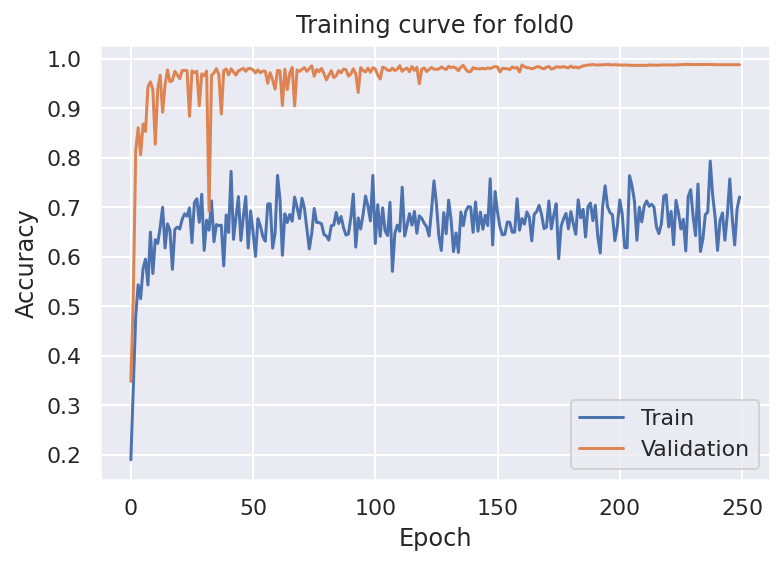

Epoch=0, Train loss=3.08080, Valid loss=1.24156, Train Accuracy=0.26160, Validation Accuracy=0.58181
Epoch=10, Train loss=1.68523, Valid loss=0.81311, Train Accuracy=0.63035, Validation Accuracy=0.90311
Epoch=20, Train loss=1.75109, Valid loss=0.94209, Train Accuracy=0.60575, Validation Accuracy=0.90219
Epoch=30, Train loss=1.56357, Valid loss=0.82052, Train Accuracy=0.67611, Validation Accuracy=0.92550
Epoch=40, Train loss=1.67466, Valid loss=0.74042, Train Accuracy=0.63949, Validation Accuracy=0.97029
Epoch=50, Train loss=1.43396, Valid loss=0.56668, Train Accuracy=0.72258, Validation Accuracy=0.98080
Epoch=60, Train loss=1.55963, Valid loss=0.39651, Train Accuracy=0.67546, Validation Accuracy=0.97395
Epoch=70, Train loss=1.62263, Valid loss=0.72586, Train Accuracy=0.64661, Validation Accuracy=0.97532
Epoch=80, Train loss=1.64117, Valid loss=0.67379, Train Accuracy=0.63787, Validation Accuracy=0.98126
Epoch=90, Train loss=1.61040, Valid loss=0.50501, Train Accuracy=0.64608, Validatio

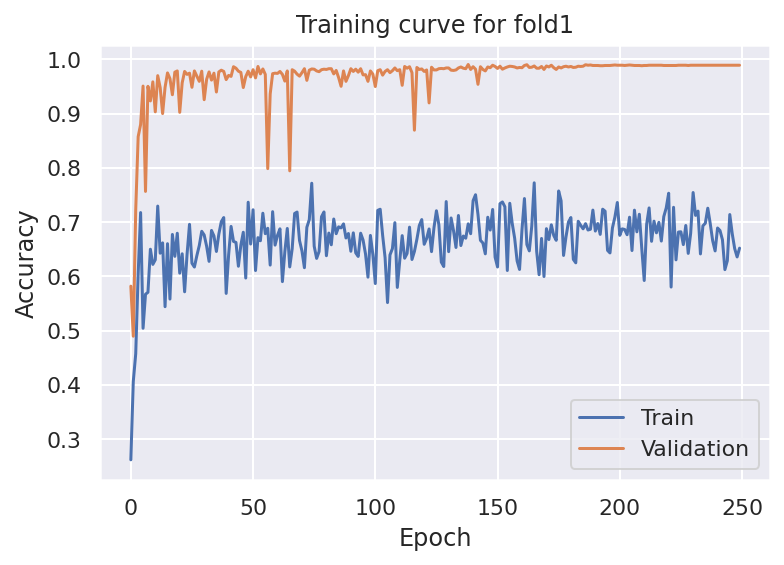

Epoch=0, Train loss=3.11279, Valid loss=1.94836, Train Accuracy=0.22569, Validation Accuracy=0.31093
Epoch=10, Train loss=1.55814, Valid loss=0.66242, Train Accuracy=0.67318, Validation Accuracy=0.95153
Epoch=20, Train loss=1.62455, Valid loss=0.58353, Train Accuracy=0.65757, Validation Accuracy=0.96754
Epoch=30, Train loss=1.83697, Valid loss=0.66746, Train Accuracy=0.55733, Validation Accuracy=0.96799
Epoch=40, Train loss=1.56913, Valid loss=0.55938, Train Accuracy=0.67463, Validation Accuracy=0.95245
Epoch=50, Train loss=1.66451, Valid loss=0.81686, Train Accuracy=0.63646, Validation Accuracy=0.91770
Epoch=60, Train loss=1.43141, Valid loss=0.57314, Train Accuracy=0.72269, Validation Accuracy=0.97714
Epoch=70, Train loss=1.58966, Valid loss=0.49769, Train Accuracy=0.65882, Validation Accuracy=0.98034
Epoch=80, Train loss=1.52125, Valid loss=0.33067, Train Accuracy=0.68945, Validation Accuracy=0.97759
Epoch=90, Train loss=1.40106, Valid loss=0.47042, Train Accuracy=0.72888, Validatio

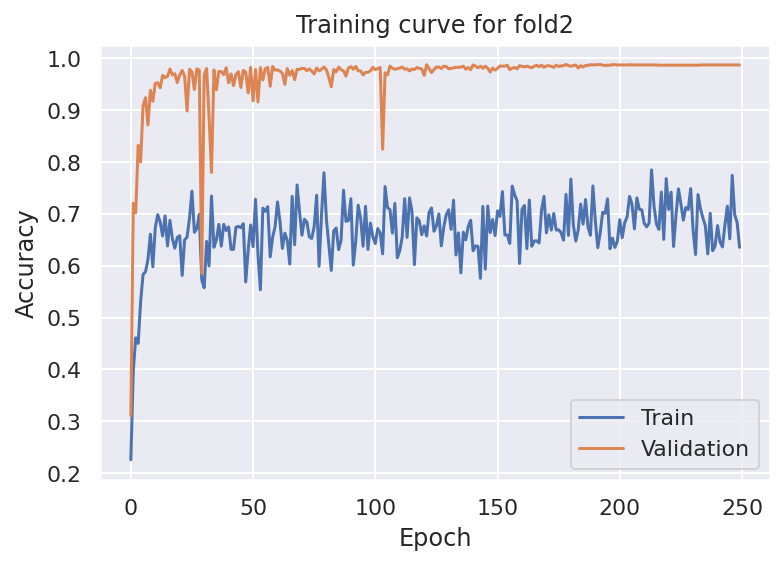

Epoch=0, Train loss=2.96978, Valid loss=1.29367, Train Accuracy=0.25686, Validation Accuracy=0.58364
Epoch=10, Train loss=1.80292, Valid loss=0.50383, Train Accuracy=0.57323, Validation Accuracy=0.97121
Epoch=20, Train loss=1.59245, Valid loss=0.45510, Train Accuracy=0.67776, Validation Accuracy=0.97715
Epoch=30, Train loss=1.57896, Valid loss=0.63396, Train Accuracy=0.66967, Validation Accuracy=0.96572
Epoch=40, Train loss=1.68595, Valid loss=0.67478, Train Accuracy=0.63139, Validation Accuracy=0.95704
Epoch=50, Train loss=1.65441, Valid loss=0.68930, Train Accuracy=0.63707, Validation Accuracy=0.96618
Epoch=60, Train loss=1.61966, Valid loss=0.48492, Train Accuracy=0.65260, Validation Accuracy=0.97578
Epoch=70, Train loss=1.64416, Valid loss=0.98683, Train Accuracy=0.64019, Validation Accuracy=0.82541
Epoch=80, Train loss=1.64200, Valid loss=0.66589, Train Accuracy=0.63749, Validation Accuracy=0.97029
Epoch=90, Train loss=1.56405, Valid loss=0.67222, Train Accuracy=0.66783, Validatio

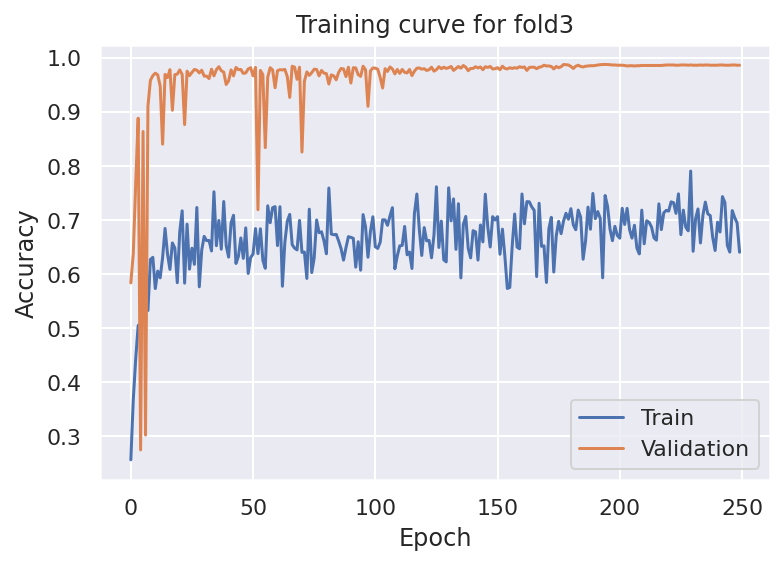

Epoch=0, Train loss=3.26620, Valid loss=1.67223, Train Accuracy=0.23416, Validation Accuracy=0.47303
Epoch=10, Train loss=1.60477, Valid loss=0.35329, Train Accuracy=0.66133, Validation Accuracy=0.95841
Epoch=20, Train loss=1.77024, Valid loss=0.90448, Train Accuracy=0.58693, Validation Accuracy=0.92367
Epoch=30, Train loss=1.63387, Valid loss=0.94810, Train Accuracy=0.64841, Validation Accuracy=0.93510
Epoch=40, Train loss=1.62388, Valid loss=0.79119, Train Accuracy=0.64954, Validation Accuracy=0.96389
Epoch=50, Train loss=1.43883, Valid loss=0.44938, Train Accuracy=0.72686, Validation Accuracy=0.97669
Epoch=60, Train loss=1.62012, Valid loss=0.51767, Train Accuracy=0.64768, Validation Accuracy=0.97898
Epoch=70, Train loss=1.43776, Valid loss=0.59851, Train Accuracy=0.71635, Validation Accuracy=0.94790
Epoch=80, Train loss=1.55452, Valid loss=0.75736, Train Accuracy=0.67086, Validation Accuracy=0.97166
Epoch=90, Train loss=1.62501, Valid loss=1.00363, Train Accuracy=0.63417, Validatio

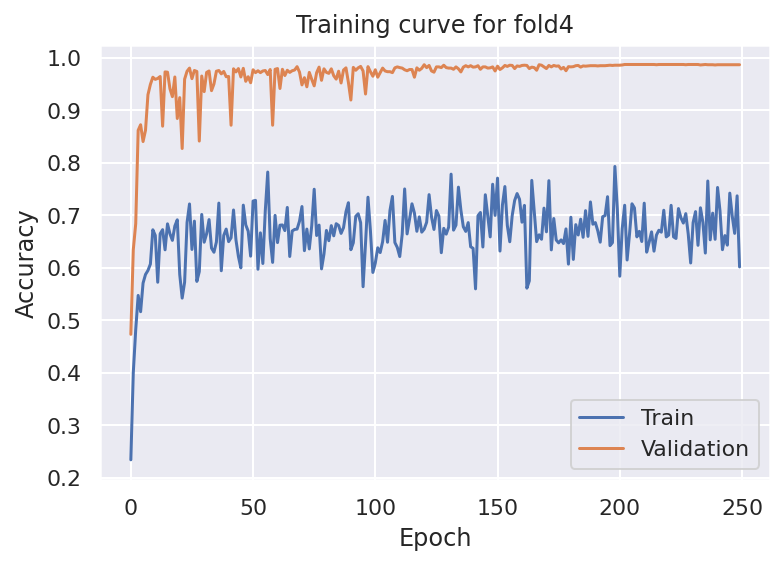

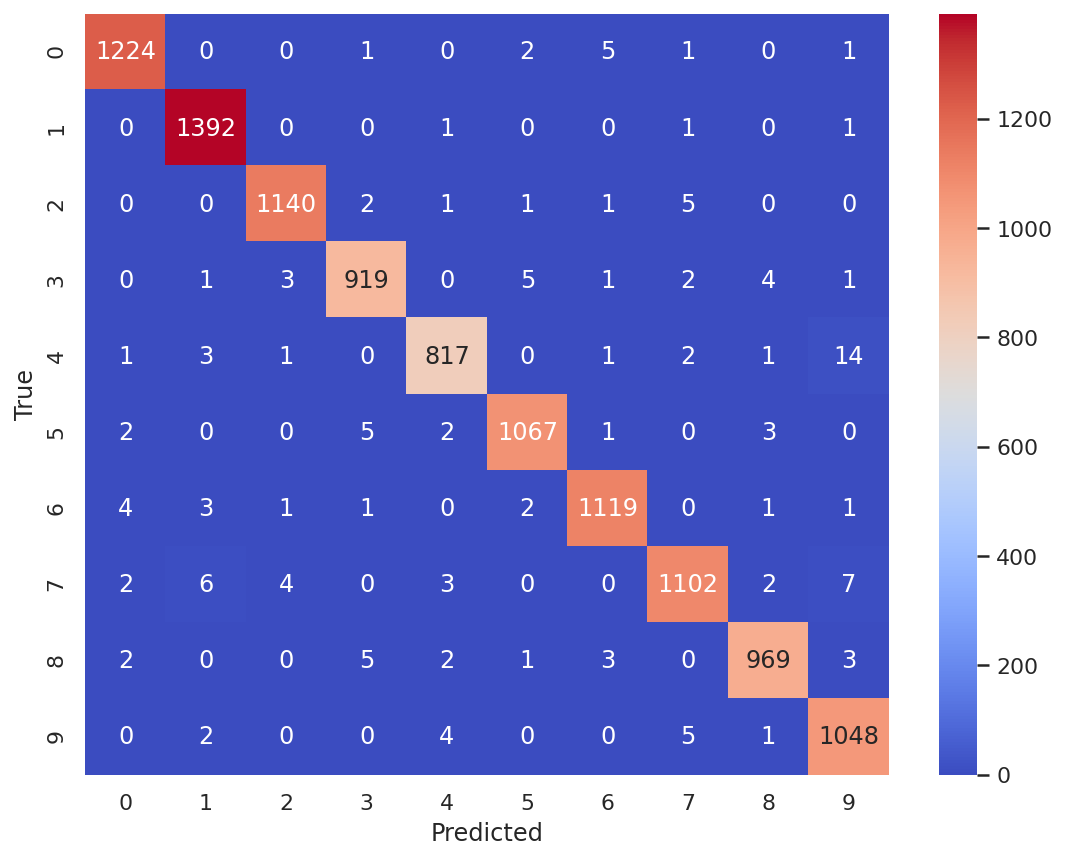

              precision    recall  f1-score   support

         0.0       0.99      0.99      0.99      1234
         1.0       0.99      1.00      0.99      1395
         2.0       0.99      0.99      0.99      1150
         3.0       0.98      0.98      0.98       936
         4.0       0.98      0.97      0.98       840
         5.0       0.99      0.99      0.99      1080
         6.0       0.99      0.99      0.99      1132
         7.0       0.99      0.98      0.98      1126
         8.0       0.99      0.98      0.99       985
         9.0       0.97      0.99      0.98      1060

    accuracy                           0.99     10938
   macro avg       0.99      0.99      0.99     10938
weighted avg       0.99      0.99      0.99     10938

CV Accuracy Score=0.9871091607240812
model=resnet34, optimizer=adam, epochs=250, lr=0.0005, wd=0.0005
CPU times: user 1h 32min 37s, sys: 3min 51s, total: 1h 36min 28s
Wall time: 1h 36min 57s


<IPython.core.display.Javascript object>

In [56]:
%%time
SEED = 46
utils.seed_everything(SEED)

augs = A.Compose([
    A.ShiftScaleRotate(shift_limit=0.0625, scale_limit=0.1, rotate_limit=10, p=0.5),
    A.Normalize(mean=0.143, std=0.254, max_pixel_value=255.0, always_apply=True,),
])
model_name = "resnet34"
optim_name = "adam"
epochs = 250
lr = 5e-4
wd = 5e-4
swa_lr = 5e-5
batch_size = 128

oof, targs = run_pl_swa(pl_1_2, model_name, optim_name, epochs, lr, swa_lr, wd, batch_size, augs, label_smooth=True, mixup=False, cutmix=True, device=DEVICE, major=1, minor=2, seed=SEED,)
preds = np.argmax(oof, axis=1)
accuracy = metrics.accuracy_score(targs, preds)
print(f"CV Accuracy Score={accuracy}")
print(f"model={model_name}, optimizer={optim_name}, epochs={epochs}, lr={lr}, wd={wd}")

In [57]:
%%time
checkpoints = [f"./models/swa_resnet34_fold{fold}_pl_1_2_seed{SEED}.pth" for fold in range(5)]
model_names = ["resnet34"] * 5
test_df = pd.read_csv(DATA_PATH / "test.csv")
test_probs = engine.infer(model_names, checkpoints, test_df, device=DEVICE, augs=augs, tta=True)
test_preds = np.argmax(test_probs, axis=1)
np.save(f"swa_tta_pl_probs_resnet34_1_2_seed{SEED}.npy", test_probs)

CPU times: user 1min 39s, sys: 2.23 s, total: 1min 41s
Wall time: 1min 43s


<IPython.core.display.Javascript object>

### 47

Epoch=0, Train loss=3.21182, Valid loss=1.41235, Train Accuracy=0.24178, Validation Accuracy=0.57247
Epoch=10, Train loss=1.68839, Valid loss=0.69331, Train Accuracy=0.64104, Validation Accuracy=0.93370
Epoch=20, Train loss=1.65272, Valid loss=0.90563, Train Accuracy=0.66301, Validation Accuracy=0.94193
Epoch=30, Train loss=1.63716, Valid loss=3.58281, Train Accuracy=0.65106, Validation Accuracy=0.64883
Epoch=40, Train loss=1.62892, Valid loss=0.57632, Train Accuracy=0.64920, Validation Accuracy=0.96891
Epoch=50, Train loss=1.53206, Valid loss=0.83405, Train Accuracy=0.69075, Validation Accuracy=0.95062
Epoch=60, Train loss=1.73965, Valid loss=0.64381, Train Accuracy=0.59694, Validation Accuracy=0.96433
Epoch=70, Train loss=1.64497, Valid loss=0.70195, Train Accuracy=0.64209, Validation Accuracy=0.94833
Epoch=80, Train loss=1.60946, Valid loss=0.43401, Train Accuracy=0.65307, Validation Accuracy=0.97668
Epoch=90, Train loss=1.57081, Valid loss=0.45863, Train Accuracy=0.66559, Validatio

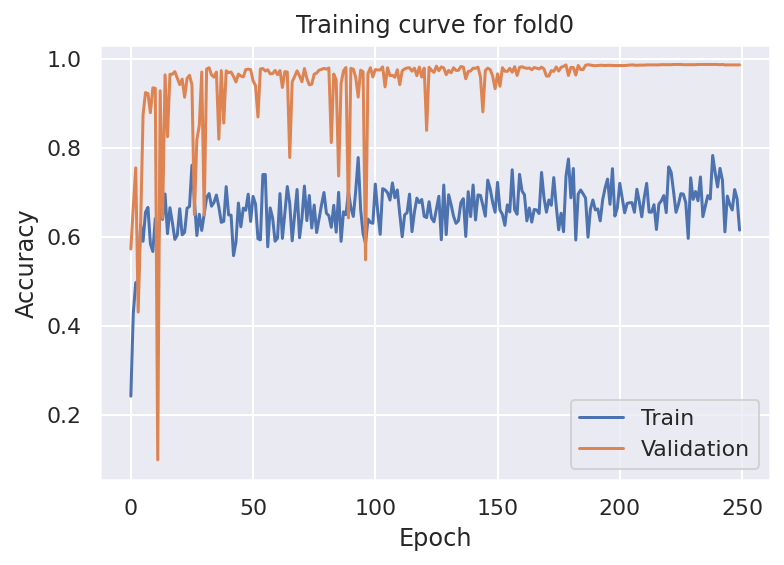

Epoch=0, Train loss=3.03469, Valid loss=1.57438, Train Accuracy=0.26627, Validation Accuracy=0.46389
Epoch=10, Train loss=1.73409, Valid loss=0.54831, Train Accuracy=0.60876, Validation Accuracy=0.95155
Epoch=20, Train loss=1.69381, Valid loss=0.56559, Train Accuracy=0.62880, Validation Accuracy=0.97441
Epoch=30, Train loss=1.52988, Valid loss=0.69563, Train Accuracy=0.68980, Validation Accuracy=0.96938
Epoch=40, Train loss=1.62993, Valid loss=0.50003, Train Accuracy=0.65338, Validation Accuracy=0.97441
Epoch=50, Train loss=1.72450, Valid loss=0.97624, Train Accuracy=0.60618, Validation Accuracy=0.81581
Epoch=60, Train loss=1.63989, Valid loss=0.49795, Train Accuracy=0.64161, Validation Accuracy=0.97623
Epoch=70, Train loss=1.22942, Valid loss=0.52622, Train Accuracy=0.79384, Validation Accuracy=0.97349
Epoch=80, Train loss=1.56837, Valid loss=0.55878, Train Accuracy=0.66877, Validation Accuracy=0.97623
Epoch=90, Train loss=1.62213, Valid loss=0.43952, Train Accuracy=0.64289, Validatio

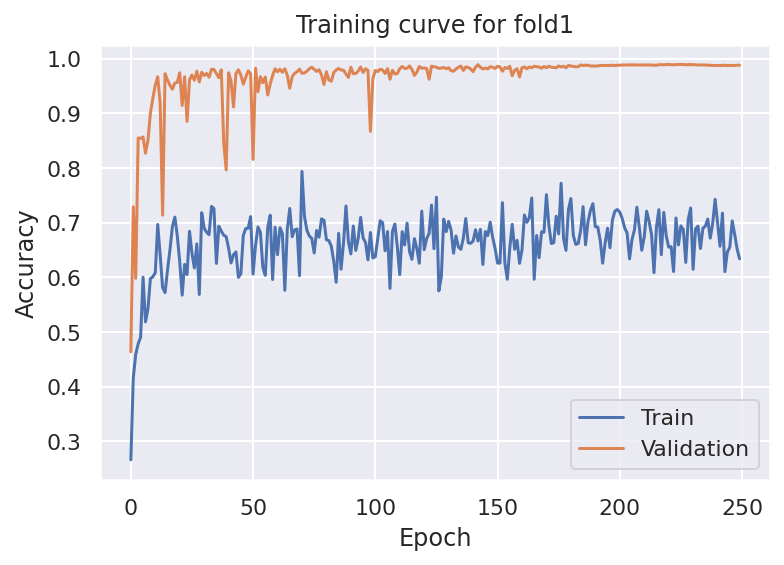

Epoch=0, Train loss=3.05594, Valid loss=2.11470, Train Accuracy=0.25425, Validation Accuracy=0.32419
Epoch=10, Train loss=1.80951, Valid loss=0.62261, Train Accuracy=0.56181, Validation Accuracy=0.94284
Epoch=20, Train loss=1.65678, Valid loss=0.67293, Train Accuracy=0.63396, Validation Accuracy=0.96799
Epoch=30, Train loss=1.71671, Valid loss=0.58942, Train Accuracy=0.62768, Validation Accuracy=0.95748
Epoch=40, Train loss=1.57244, Valid loss=0.64165, Train Accuracy=0.67277, Validation Accuracy=0.98125
Epoch=50, Train loss=1.70853, Valid loss=0.48552, Train Accuracy=0.61830, Validation Accuracy=0.97577
Epoch=60, Train loss=1.54889, Valid loss=0.49012, Train Accuracy=0.68607, Validation Accuracy=0.97257
Epoch=70, Train loss=1.56822, Valid loss=0.51691, Train Accuracy=0.66859, Validation Accuracy=0.98125
Epoch=80, Train loss=1.66183, Valid loss=0.47950, Train Accuracy=0.62459, Validation Accuracy=0.97302
Epoch=90, Train loss=1.45610, Valid loss=0.57068, Train Accuracy=0.70802, Validatio

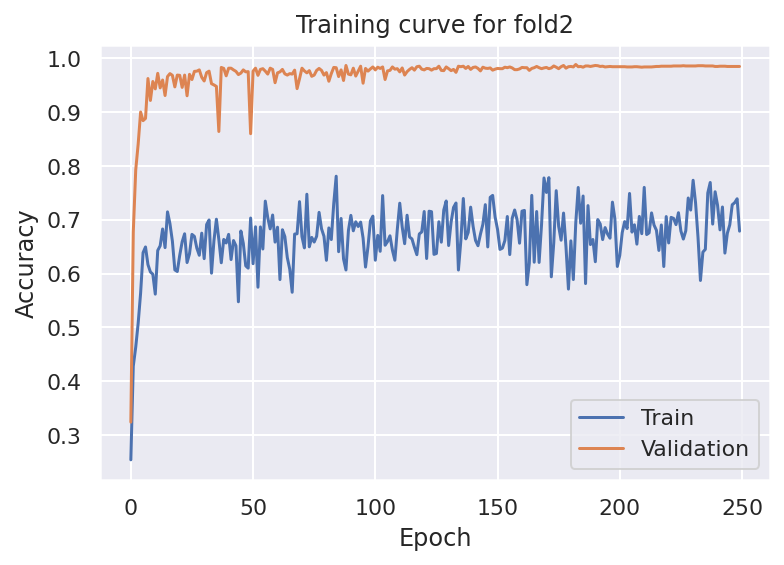

Epoch=0, Train loss=3.15477, Valid loss=1.32304, Train Accuracy=0.24406, Validation Accuracy=0.56536
Epoch=10, Train loss=1.61921, Valid loss=0.36724, Train Accuracy=0.65665, Validation Accuracy=0.97486
Epoch=20, Train loss=1.77225, Valid loss=0.68266, Train Accuracy=0.58489, Validation Accuracy=0.95247
Epoch=30, Train loss=1.62431, Valid loss=0.64461, Train Accuracy=0.65867, Validation Accuracy=0.97852
Epoch=40, Train loss=1.51808, Valid loss=0.44064, Train Accuracy=0.69608, Validation Accuracy=0.97669
Epoch=50, Train loss=1.58880, Valid loss=0.87990, Train Accuracy=0.65962, Validation Accuracy=0.97623
Epoch=60, Train loss=1.61195, Valid loss=0.73629, Train Accuracy=0.65426, Validation Accuracy=0.95887
Epoch=70, Train loss=1.45038, Valid loss=0.43965, Train Accuracy=0.71279, Validation Accuracy=0.97395
Epoch=80, Train loss=1.48286, Valid loss=0.59851, Train Accuracy=0.69770, Validation Accuracy=0.97852
Epoch=90, Train loss=1.57876, Valid loss=0.56151, Train Accuracy=0.66262, Validatio

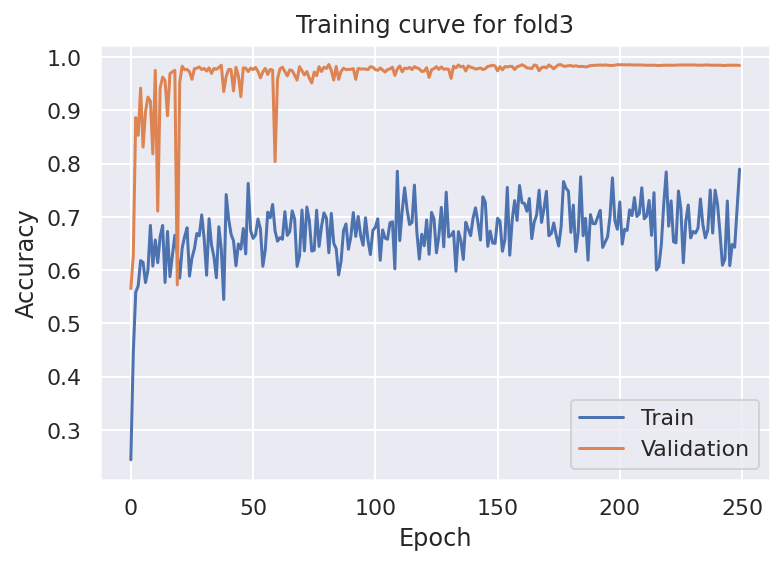

Epoch=0, Train loss=3.07340, Valid loss=1.21868, Train Accuracy=0.24292, Validation Accuracy=0.59689
Epoch=10, Train loss=1.85983, Valid loss=0.82772, Train Accuracy=0.56291, Validation Accuracy=0.94835
Epoch=20, Train loss=1.69609, Valid loss=0.92557, Train Accuracy=0.62572, Validation Accuracy=0.96618
Epoch=30, Train loss=1.53616, Valid loss=0.52124, Train Accuracy=0.69254, Validation Accuracy=0.97166
Epoch=40, Train loss=1.71926, Valid loss=0.81353, Train Accuracy=0.61375, Validation Accuracy=0.90859
Epoch=50, Train loss=1.50703, Valid loss=0.50536, Train Accuracy=0.69666, Validation Accuracy=0.97395
Epoch=60, Train loss=1.59683, Valid loss=0.58045, Train Accuracy=0.65730, Validation Accuracy=0.97441
Epoch=70, Train loss=1.47629, Valid loss=0.54217, Train Accuracy=0.70052, Validation Accuracy=0.97806
Epoch=80, Train loss=1.68824, Valid loss=0.64864, Train Accuracy=0.61578, Validation Accuracy=0.97532
Epoch=90, Train loss=1.58626, Valid loss=0.65650, Train Accuracy=0.65520, Validatio

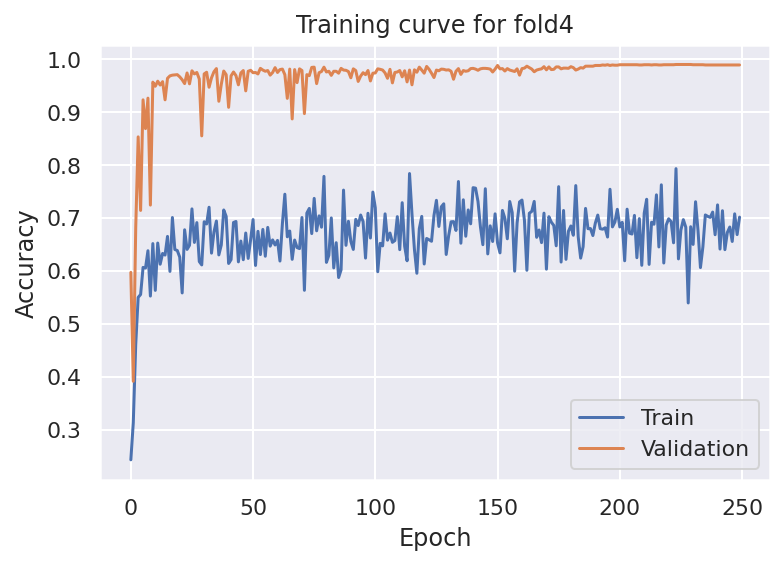

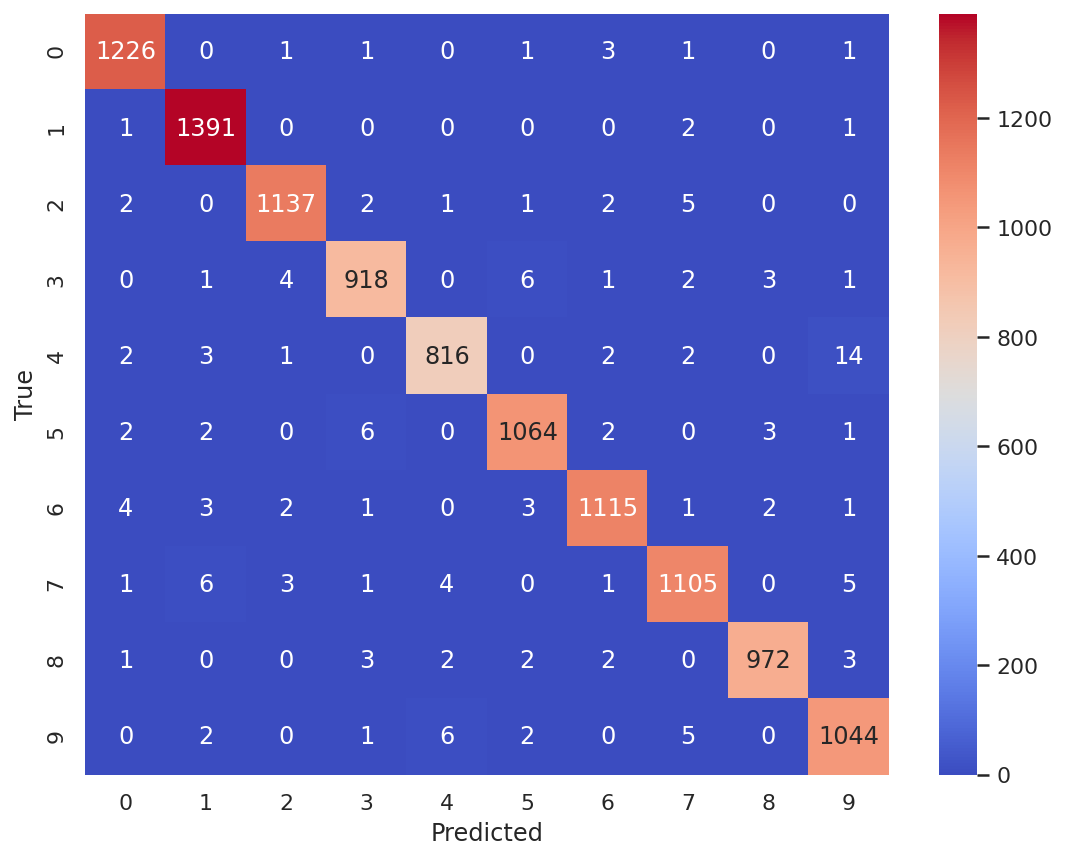

              precision    recall  f1-score   support

         0.0       0.99      0.99      0.99      1234
         1.0       0.99      1.00      0.99      1395
         2.0       0.99      0.99      0.99      1150
         3.0       0.98      0.98      0.98       936
         4.0       0.98      0.97      0.98       840
         5.0       0.99      0.99      0.99      1080
         6.0       0.99      0.98      0.99      1132
         7.0       0.98      0.98      0.98      1126
         8.0       0.99      0.99      0.99       985
         9.0       0.97      0.98      0.98      1060

    accuracy                           0.99     10938
   macro avg       0.99      0.99      0.99     10938
weighted avg       0.99      0.99      0.99     10938

CV Accuracy Score=0.986286341195831
model=resnet34, optimizer=adam, epochs=250, lr=0.0005, wd=0.0005
CPU times: user 1h 32min 46s, sys: 3min 50s, total: 1h 36min 36s
Wall time: 1h 37min 5s


<IPython.core.display.Javascript object>

In [65]:
%%time
SEED = 47
utils.seed_everything(SEED)

augs = A.Compose([
    A.ShiftScaleRotate(shift_limit=0.0625, scale_limit=0.1, rotate_limit=10, p=0.5),
    A.Normalize(mean=0.143, std=0.254, max_pixel_value=255.0, always_apply=True,),
])
model_name = "resnet34"
optim_name = "adam"
epochs = 250
lr = 5e-4
wd = 5e-4
swa_lr = 5e-5
batch_size = 128

oof, targs = run_pl_swa(pl_1_2, model_name, optim_name, epochs, lr, swa_lr, wd, batch_size, augs, label_smooth=True, mixup=False, cutmix=True, device=DEVICE, major=1, minor=2, seed=SEED,)
preds = np.argmax(oof, axis=1)
accuracy = metrics.accuracy_score(targs, preds)
print(f"CV Accuracy Score={accuracy}")
print(f"model={model_name}, optimizer={optim_name}, epochs={epochs}, lr={lr}, wd={wd}")

In [66]:
%%time
checkpoints = [f"./models/swa_resnet34_fold{fold}_pl_1_2_seed{SEED}.pth" for fold in range(5)]
model_names = ["resnet34"] * 5
test_df = pd.read_csv(DATA_PATH / "test.csv")
test_probs = engine.infer(model_names, checkpoints, test_df, device=DEVICE, augs=augs, tta=True)
test_preds = np.argmax(test_probs, axis=1)
np.save(f"swa_tta_pl_probs_resnet34_1_2_seed{SEED}.npy", test_probs)

CPU times: user 1min 39s, sys: 2.24 s, total: 1min 41s
Wall time: 1min 43s


<IPython.core.display.Javascript object>

### 48

Epoch=0, Train loss=3.05110, Valid loss=1.50656, Train Accuracy=0.24050, Validation Accuracy=0.49520
Epoch=10, Train loss=1.64131, Valid loss=0.58547, Train Accuracy=0.65201, Validation Accuracy=0.92547
Epoch=20, Train loss=1.60834, Valid loss=0.48678, Train Accuracy=0.66890, Validation Accuracy=0.96708
Epoch=30, Train loss=1.42384, Valid loss=0.45657, Train Accuracy=0.73258, Validation Accuracy=0.96891
Epoch=40, Train loss=1.55245, Valid loss=0.48186, Train Accuracy=0.68078, Validation Accuracy=0.98034
Epoch=50, Train loss=1.63066, Valid loss=0.55675, Train Accuracy=0.64477, Validation Accuracy=0.97577
Epoch=60, Train loss=1.48304, Valid loss=0.48096, Train Accuracy=0.70152, Validation Accuracy=0.97714
Epoch=70, Train loss=1.55462, Valid loss=0.76078, Train Accuracy=0.67043, Validation Accuracy=0.96708
Epoch=80, Train loss=1.51892, Valid loss=0.77681, Train Accuracy=0.68457, Validation Accuracy=0.97119
Epoch=90, Train loss=1.66901, Valid loss=0.58360, Train Accuracy=0.62483, Validatio

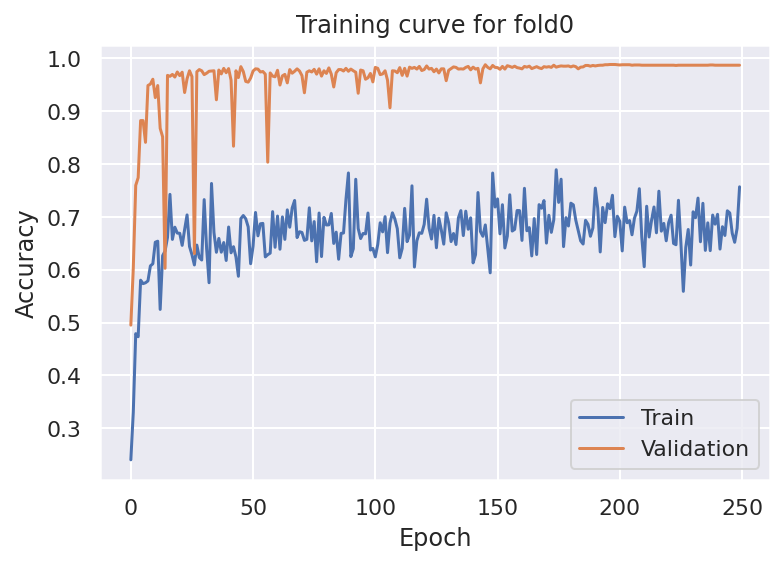

Epoch=0, Train loss=3.10335, Valid loss=1.36508, Train Accuracy=0.21026, Validation Accuracy=0.56810
Epoch=10, Train loss=1.77556, Valid loss=0.68017, Train Accuracy=0.59001, Validation Accuracy=0.95247
Epoch=20, Train loss=1.65524, Valid loss=1.20106, Train Accuracy=0.64175, Validation Accuracy=0.72349
Epoch=30, Train loss=1.50042, Valid loss=0.38492, Train Accuracy=0.69839, Validation Accuracy=0.96161
Epoch=40, Train loss=1.59044, Valid loss=0.51651, Train Accuracy=0.66494, Validation Accuracy=0.98218
Epoch=50, Train loss=1.69727, Valid loss=0.70598, Train Accuracy=0.61957, Validation Accuracy=0.97532
Epoch=60, Train loss=1.57137, Valid loss=0.57355, Train Accuracy=0.66947, Validation Accuracy=0.96984
Epoch=70, Train loss=1.41276, Valid loss=0.41089, Train Accuracy=0.72882, Validation Accuracy=0.97715
Epoch=80, Train loss=1.54563, Valid loss=0.61944, Train Accuracy=0.67897, Validation Accuracy=0.97578
Epoch=90, Train loss=1.57533, Valid loss=0.54084, Train Accuracy=0.66342, Validatio

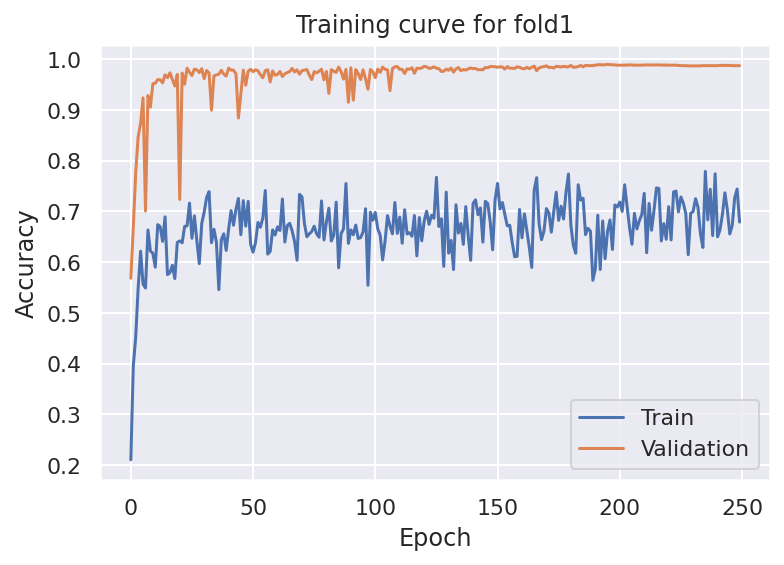

Epoch=0, Train loss=2.96524, Valid loss=1.48603, Train Accuracy=0.25717, Validation Accuracy=0.49108
Epoch=10, Train loss=1.86682, Valid loss=0.47415, Train Accuracy=0.54893, Validation Accuracy=0.96159
Epoch=20, Train loss=1.57399, Valid loss=0.33366, Train Accuracy=0.67351, Validation Accuracy=0.96754
Epoch=30, Train loss=1.50294, Valid loss=0.46187, Train Accuracy=0.70097, Validation Accuracy=0.96433
Epoch=40, Train loss=1.69310, Valid loss=0.54450, Train Accuracy=0.62801, Validation Accuracy=0.98125
Epoch=50, Train loss=1.54463, Valid loss=0.56152, Train Accuracy=0.68021, Validation Accuracy=0.98034
Epoch=60, Train loss=1.57557, Valid loss=0.42716, Train Accuracy=0.66476, Validation Accuracy=0.97714
Epoch=70, Train loss=1.51684, Valid loss=0.55310, Train Accuracy=0.69075, Validation Accuracy=0.98080
Epoch=80, Train loss=1.55986, Valid loss=0.83236, Train Accuracy=0.66872, Validation Accuracy=0.95428
Epoch=90, Train loss=1.59241, Valid loss=0.75088, Train Accuracy=0.65802, Validatio

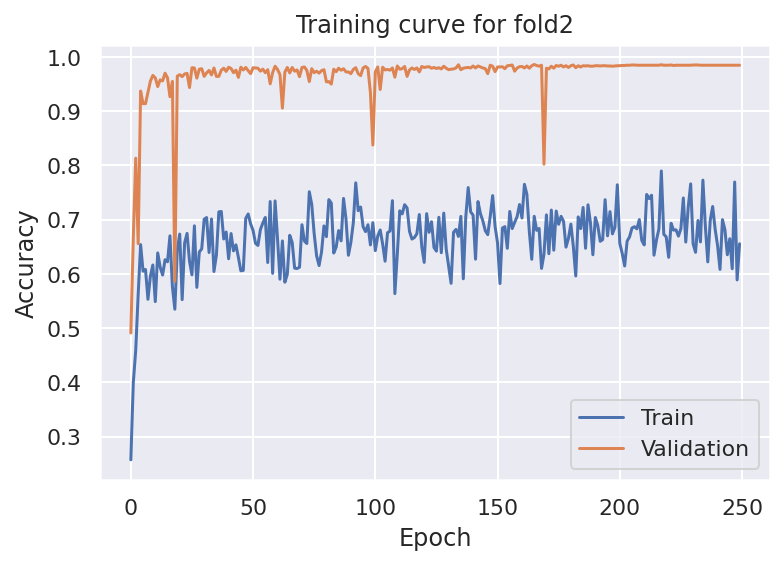

Epoch=0, Train loss=3.24890, Valid loss=1.29660, Train Accuracy=0.24022, Validation Accuracy=0.56627
Epoch=10, Train loss=1.71498, Valid loss=0.74688, Train Accuracy=0.62975, Validation Accuracy=0.93327
Epoch=20, Train loss=1.65780, Valid loss=0.46452, Train Accuracy=0.64323, Validation Accuracy=0.97349
Epoch=30, Train loss=1.59036, Valid loss=0.93581, Train Accuracy=0.66827, Validation Accuracy=0.92459
Epoch=40, Train loss=1.62966, Valid loss=0.50408, Train Accuracy=0.65179, Validation Accuracy=0.97623
Epoch=50, Train loss=1.53728, Valid loss=0.58259, Train Accuracy=0.68317, Validation Accuracy=0.97303
Epoch=60, Train loss=1.57407, Valid loss=0.60736, Train Accuracy=0.66746, Validation Accuracy=0.97303
Epoch=70, Train loss=1.48930, Valid loss=0.47963, Train Accuracy=0.70671, Validation Accuracy=0.97623
Epoch=80, Train loss=1.36764, Valid loss=0.42192, Train Accuracy=0.74056, Validation Accuracy=0.97258
Epoch=90, Train loss=1.63657, Valid loss=0.54883, Train Accuracy=0.63837, Validatio

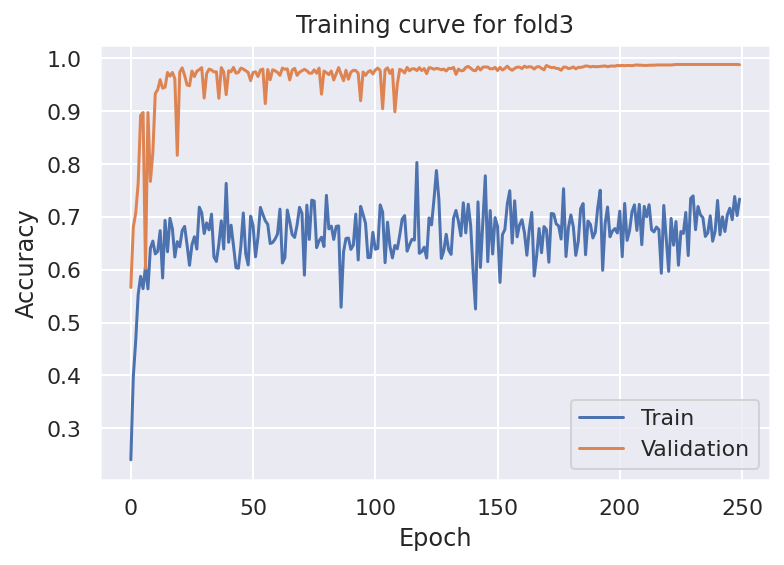

Epoch=0, Train loss=3.15836, Valid loss=1.21570, Train Accuracy=0.25647, Validation Accuracy=0.59735
Epoch=10, Train loss=1.70944, Valid loss=0.57362, Train Accuracy=0.61825, Validation Accuracy=0.94516
Epoch=20, Train loss=1.55192, Valid loss=0.69486, Train Accuracy=0.68549, Validation Accuracy=0.94013
Epoch=30, Train loss=1.80911, Valid loss=0.62933, Train Accuracy=0.57793, Validation Accuracy=0.95430
Epoch=40, Train loss=1.49971, Valid loss=0.63642, Train Accuracy=0.70090, Validation Accuracy=0.97898
Epoch=50, Train loss=1.64544, Valid loss=0.70660, Train Accuracy=0.64554, Validation Accuracy=0.97166
Epoch=60, Train loss=1.62335, Valid loss=0.62926, Train Accuracy=0.65151, Validation Accuracy=0.98080
Epoch=70, Train loss=1.35990, Valid loss=0.45176, Train Accuracy=0.74609, Validation Accuracy=0.98309
Epoch=80, Train loss=1.73664, Valid loss=0.70801, Train Accuracy=0.59904, Validation Accuracy=0.94653
Epoch=90, Train loss=1.54968, Valid loss=0.54355, Train Accuracy=0.67368, Validatio

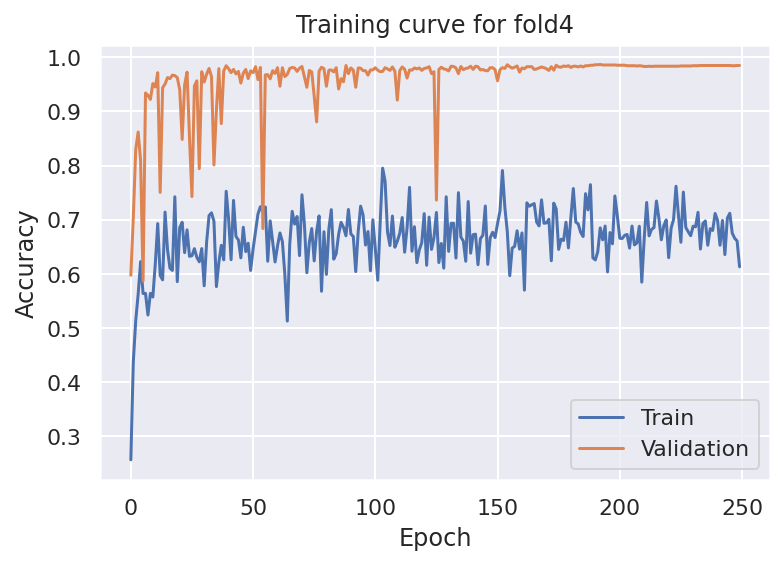

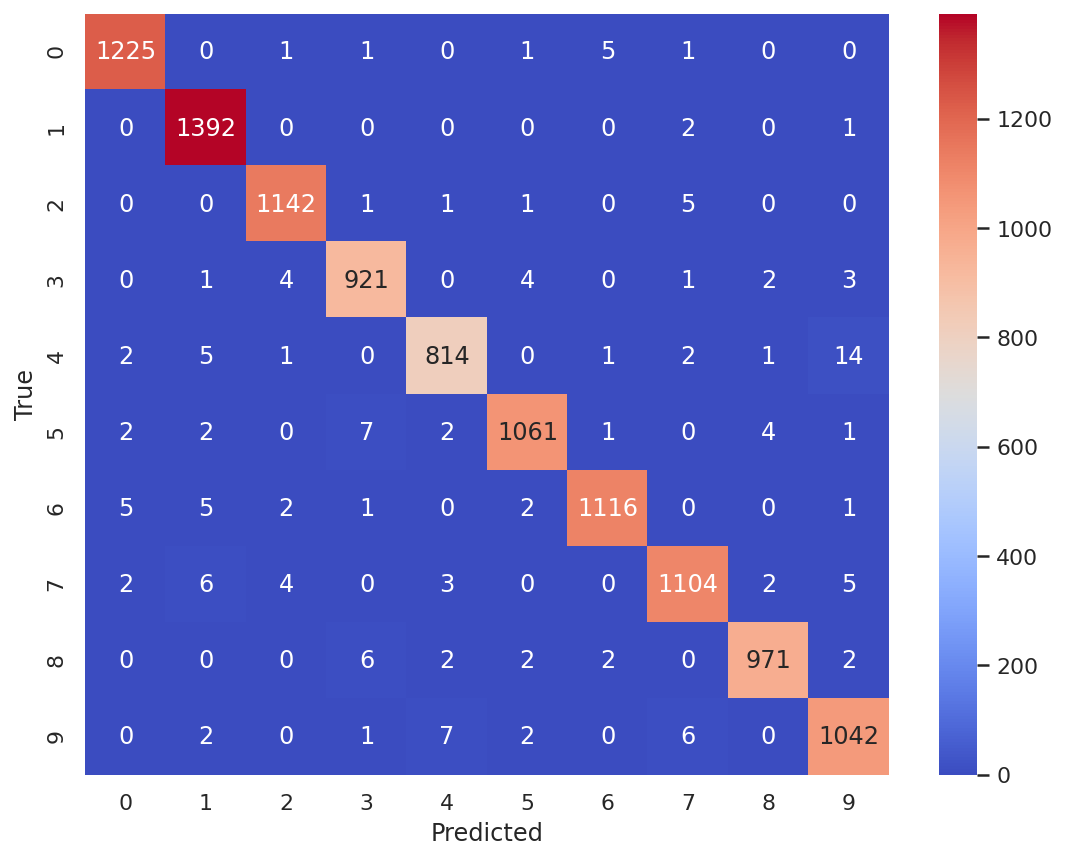

              precision    recall  f1-score   support

         0.0       0.99      0.99      0.99      1234
         1.0       0.99      1.00      0.99      1395
         2.0       0.99      0.99      0.99      1150
         3.0       0.98      0.98      0.98       936
         4.0       0.98      0.97      0.98       840
         5.0       0.99      0.98      0.99      1080
         6.0       0.99      0.99      0.99      1132
         7.0       0.98      0.98      0.98      1126
         8.0       0.99      0.99      0.99       985
         9.0       0.97      0.98      0.98      1060

    accuracy                           0.99     10938
   macro avg       0.99      0.99      0.99     10938
weighted avg       0.99      0.99      0.99     10938

CV Accuracy Score=0.986286341195831
model=resnet34, optimizer=adam, epochs=250, lr=0.0005, wd=0.0005
CPU times: user 1h 32min 46s, sys: 3min 50s, total: 1h 36min 37s
Wall time: 1h 37min 4s


<IPython.core.display.Javascript object>

In [67]:
%%time
SEED = 48
utils.seed_everything(SEED)

augs = A.Compose([
    A.ShiftScaleRotate(shift_limit=0.0625, scale_limit=0.1, rotate_limit=10, p=0.5),
    A.Normalize(mean=0.143, std=0.254, max_pixel_value=255.0, always_apply=True,),
])
model_name = "resnet34"
optim_name = "adam"
epochs = 250
lr = 5e-4
wd = 5e-4
swa_lr = 5e-5
batch_size = 128

oof, targs = run_pl_swa(pl_1_2, model_name, optim_name, epochs, lr, swa_lr, wd, batch_size, augs, label_smooth=True, mixup=False, cutmix=True, device=DEVICE, major=1, minor=2, seed=SEED,)
preds = np.argmax(oof, axis=1)
accuracy = metrics.accuracy_score(targs, preds)
print(f"CV Accuracy Score={accuracy}")
print(f"model={model_name}, optimizer={optim_name}, epochs={epochs}, lr={lr}, wd={wd}")

In [68]:
%%time
checkpoints = [f"./models/swa_resnet34_fold{fold}_pl_1_2_seed{SEED}.pth" for fold in range(5)]
model_names = ["resnet34"] * 5
test_df = pd.read_csv(DATA_PATH / "test.csv")
test_probs = engine.infer(model_names, checkpoints, test_df, device=DEVICE, augs=augs, tta=True)
test_preds = np.argmax(test_probs, axis=1)
np.save(f"swa_tta_pl_probs_resnet34_1_2_seed{SEED}.npy", test_probs)

CPU times: user 1min 39s, sys: 2.25 s, total: 1min 41s
Wall time: 1min 43s


<IPython.core.display.Javascript object>

### 49

Epoch=0, Train loss=3.06362, Valid loss=1.24017, Train Accuracy=0.26264, Validation Accuracy=0.57933
Epoch=10, Train loss=1.55322, Valid loss=0.56548, Train Accuracy=0.68519, Validation Accuracy=0.96342
Epoch=20, Train loss=1.74645, Valid loss=0.89214, Train Accuracy=0.61064, Validation Accuracy=0.86465
Epoch=30, Train loss=1.62939, Valid loss=0.43769, Train Accuracy=0.65439, Validation Accuracy=0.97302
Epoch=40, Train loss=1.70537, Valid loss=0.66744, Train Accuracy=0.62003, Validation Accuracy=0.96708
Epoch=50, Train loss=1.61379, Valid loss=0.61524, Train Accuracy=0.65452, Validation Accuracy=0.97119
Epoch=60, Train loss=1.66067, Valid loss=0.55509, Train Accuracy=0.63543, Validation Accuracy=0.97257
Epoch=70, Train loss=1.55970, Valid loss=0.62665, Train Accuracy=0.66877, Validation Accuracy=0.96296
Epoch=80, Train loss=1.53160, Valid loss=0.51792, Train Accuracy=0.68639, Validation Accuracy=0.97439
Epoch=90, Train loss=1.65139, Valid loss=0.59665, Train Accuracy=0.62980, Validatio

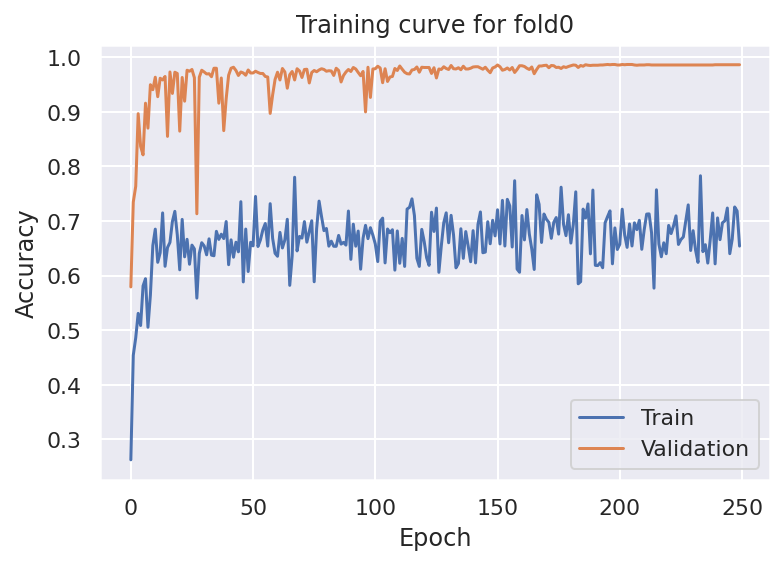

Epoch=0, Train loss=3.04555, Valid loss=1.40835, Train Accuracy=0.24465, Validation Accuracy=0.52422
Epoch=10, Train loss=1.73537, Valid loss=0.90936, Train Accuracy=0.61006, Validation Accuracy=0.87477
Epoch=20, Train loss=1.53075, Valid loss=0.41434, Train Accuracy=0.69461, Validation Accuracy=0.97303
Epoch=30, Train loss=1.56874, Valid loss=0.57086, Train Accuracy=0.67878, Validation Accuracy=0.97075
Epoch=40, Train loss=1.60490, Valid loss=0.73408, Train Accuracy=0.65615, Validation Accuracy=0.94059
Epoch=50, Train loss=1.51480, Valid loss=0.47446, Train Accuracy=0.69724, Validation Accuracy=0.97715
Epoch=60, Train loss=1.54857, Valid loss=0.49640, Train Accuracy=0.67515, Validation Accuracy=0.98172
Epoch=70, Train loss=1.58797, Valid loss=0.55341, Train Accuracy=0.66227, Validation Accuracy=0.97212
Epoch=80, Train loss=1.47986, Valid loss=0.59534, Train Accuracy=0.70043, Validation Accuracy=0.98080
Epoch=90, Train loss=1.63674, Valid loss=0.68410, Train Accuracy=0.63922, Validatio

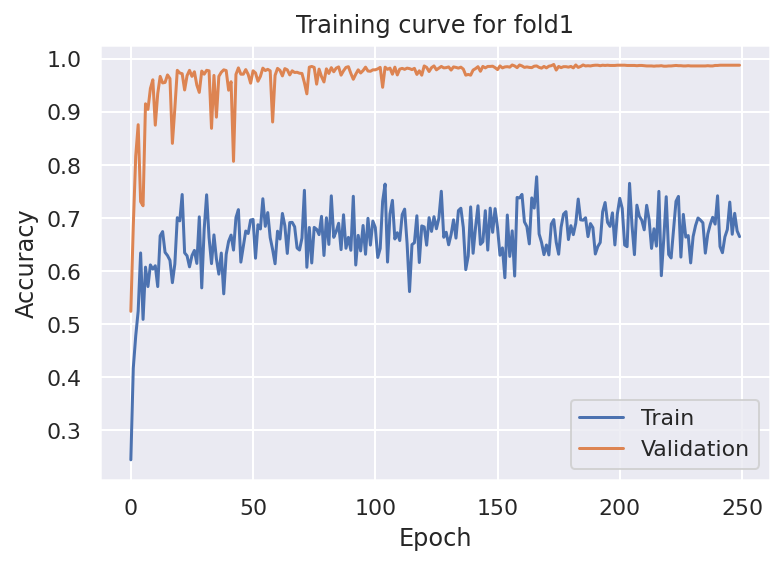

Epoch=0, Train loss=3.28686, Valid loss=1.54863, Train Accuracy=0.23131, Validation Accuracy=0.47234
Epoch=10, Train loss=1.73934, Valid loss=1.00132, Train Accuracy=0.61475, Validation Accuracy=0.89620
Epoch=20, Train loss=1.65345, Valid loss=0.58899, Train Accuracy=0.64588, Validation Accuracy=0.97165
Epoch=30, Train loss=1.60842, Valid loss=0.61274, Train Accuracy=0.66440, Validation Accuracy=0.96891
Epoch=40, Train loss=1.55624, Valid loss=0.44485, Train Accuracy=0.68513, Validation Accuracy=0.97897
Epoch=50, Train loss=1.64449, Valid loss=0.62963, Train Accuracy=0.64051, Validation Accuracy=0.97211
Epoch=60, Train loss=1.72415, Valid loss=0.53526, Train Accuracy=0.60535, Validation Accuracy=0.97165
Epoch=70, Train loss=1.70520, Valid loss=0.82890, Train Accuracy=0.60792, Validation Accuracy=0.95885
Epoch=80, Train loss=1.42045, Valid loss=0.48022, Train Accuracy=0.72439, Validation Accuracy=0.97805
Epoch=90, Train loss=1.73349, Valid loss=0.56500, Train Accuracy=0.59702, Validatio

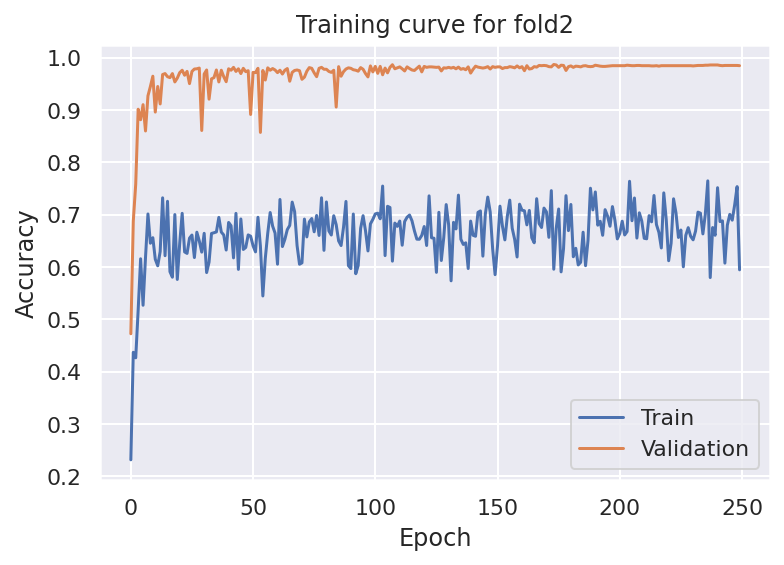

Epoch=0, Train loss=3.38731, Valid loss=1.52684, Train Accuracy=0.23092, Validation Accuracy=0.48629
Epoch=10, Train loss=1.70243, Valid loss=0.57862, Train Accuracy=0.62373, Validation Accuracy=0.94516
Epoch=20, Train loss=1.66335, Valid loss=0.91122, Train Accuracy=0.64748, Validation Accuracy=0.93601
Epoch=30, Train loss=1.66087, Valid loss=0.50022, Train Accuracy=0.63549, Validation Accuracy=0.97761
Epoch=40, Train loss=1.48926, Valid loss=0.55928, Train Accuracy=0.70589, Validation Accuracy=0.97075
Epoch=50, Train loss=1.63478, Valid loss=0.70754, Train Accuracy=0.64634, Validation Accuracy=0.97212
Epoch=60, Train loss=1.65963, Valid loss=0.37645, Train Accuracy=0.63498, Validation Accuracy=0.97898
Epoch=70, Train loss=1.62597, Valid loss=0.46957, Train Accuracy=0.64698, Validation Accuracy=0.98309
Epoch=80, Train loss=1.63206, Valid loss=0.67470, Train Accuracy=0.64285, Validation Accuracy=0.94516
Epoch=90, Train loss=1.57800, Valid loss=0.49839, Train Accuracy=0.65852, Validatio

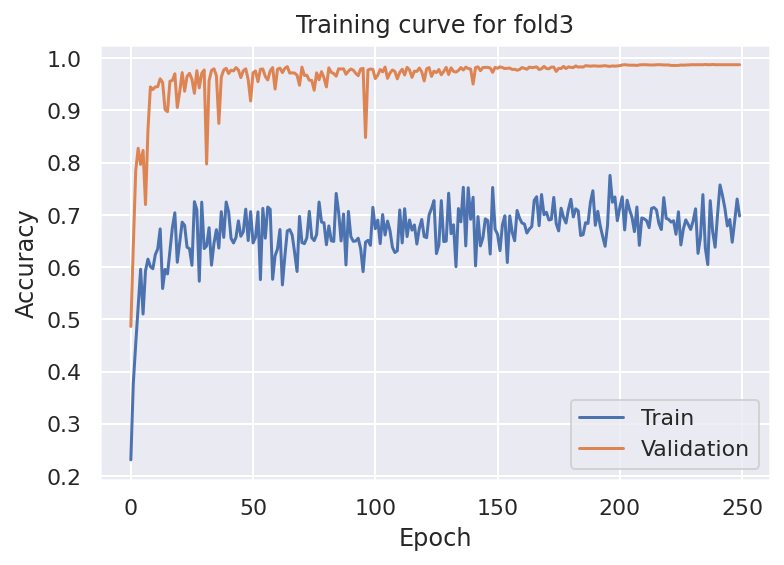

Epoch=0, Train loss=3.43387, Valid loss=1.59141, Train Accuracy=0.19228, Validation Accuracy=0.48172
Epoch=10, Train loss=1.63170, Valid loss=0.62267, Train Accuracy=0.65610, Validation Accuracy=0.96527
Epoch=20, Train loss=1.47092, Valid loss=0.51954, Train Accuracy=0.71523, Validation Accuracy=0.96481
Epoch=30, Train loss=1.63450, Valid loss=0.63957, Train Accuracy=0.65305, Validation Accuracy=0.91728
Epoch=40, Train loss=1.64426, Valid loss=0.48420, Train Accuracy=0.64972, Validation Accuracy=0.97898
Epoch=50, Train loss=1.43768, Valid loss=0.55461, Train Accuracy=0.72124, Validation Accuracy=0.95658
Epoch=60, Train loss=1.76354, Valid loss=0.80538, Train Accuracy=0.58463, Validation Accuracy=0.97943
Epoch=70, Train loss=1.37293, Valid loss=0.44254, Train Accuracy=0.74243, Validation Accuracy=0.98263
Epoch=80, Train loss=1.51911, Valid loss=0.49393, Train Accuracy=0.68786, Validation Accuracy=0.96481
Epoch=90, Train loss=1.64622, Valid loss=0.76407, Train Accuracy=0.62745, Validatio

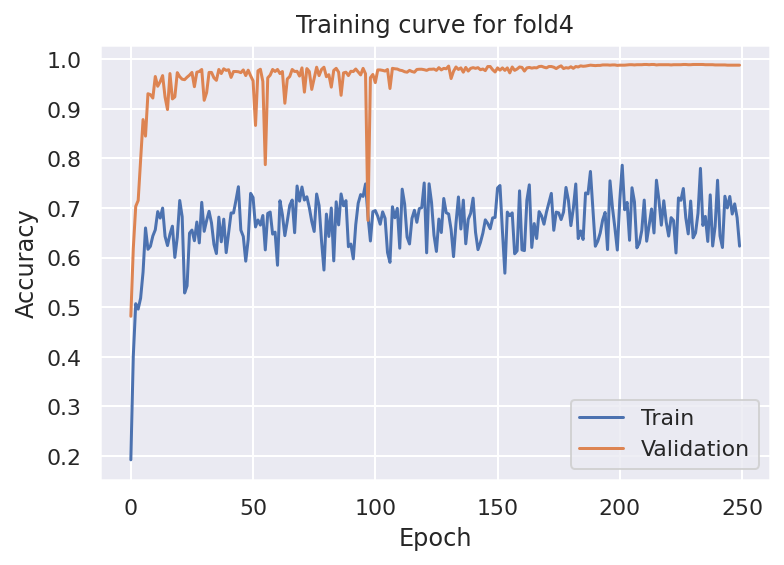

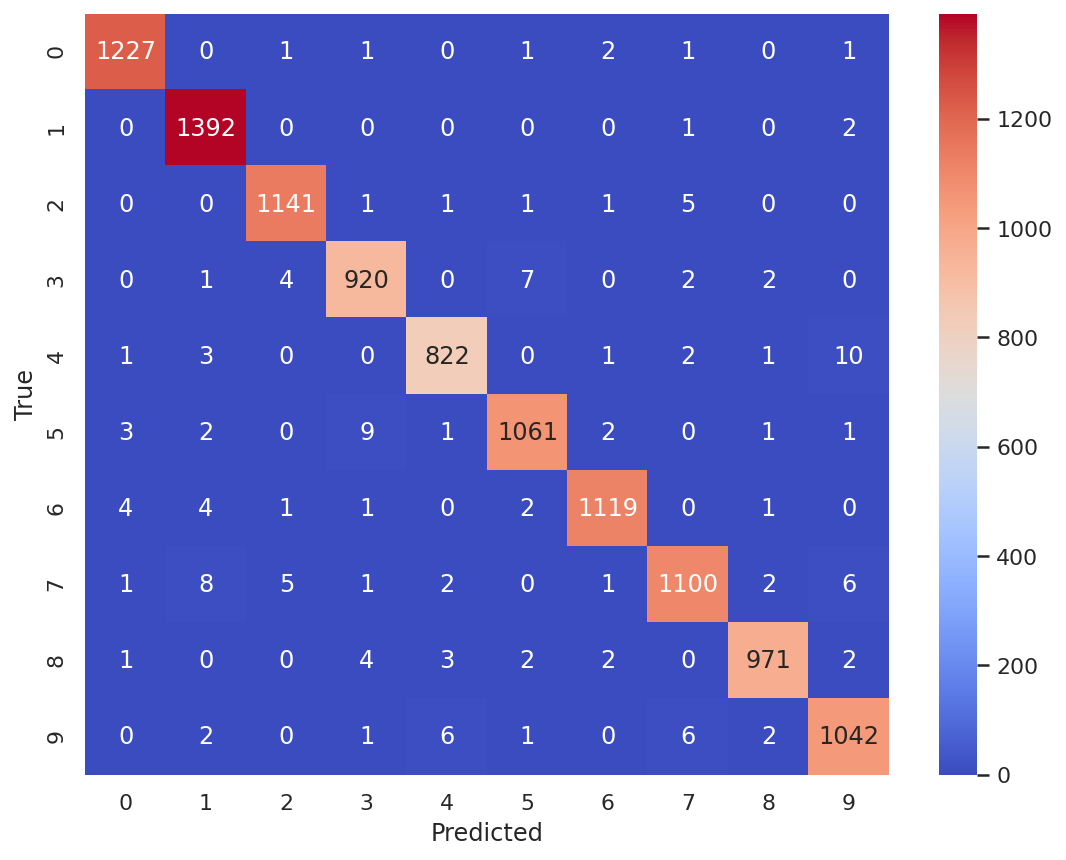

              precision    recall  f1-score   support

         0.0       0.99      0.99      0.99      1234
         1.0       0.99      1.00      0.99      1395
         2.0       0.99      0.99      0.99      1150
         3.0       0.98      0.98      0.98       936
         4.0       0.98      0.98      0.98       840
         5.0       0.99      0.98      0.98      1080
         6.0       0.99      0.99      0.99      1132
         7.0       0.98      0.98      0.98      1126
         8.0       0.99      0.99      0.99       985
         9.0       0.98      0.98      0.98      1060

    accuracy                           0.99     10938
   macro avg       0.99      0.99      0.99     10938
weighted avg       0.99      0.99      0.99     10938

CV Accuracy Score=0.9869263119400256
model=resnet34, optimizer=adam, epochs=250, lr=0.0005, wd=0.0005
CPU times: user 1h 32min 50s, sys: 3min 50s, total: 1h 36min 41s
Wall time: 1h 37min 8s


<IPython.core.display.Javascript object>

In [71]:
%%time
SEED = 49
utils.seed_everything(SEED)

augs = A.Compose([
    A.ShiftScaleRotate(shift_limit=0.0625, scale_limit=0.1, rotate_limit=10, p=0.5),
    A.Normalize(mean=0.143, std=0.254, max_pixel_value=255.0, always_apply=True,),
])
model_name = "resnet34"
optim_name = "adam"
epochs = 250
lr = 5e-4
wd = 5e-4
swa_lr = 5e-5
batch_size = 128

oof, targs = run_pl_swa(pl_1_2, model_name, optim_name, epochs, lr, swa_lr, wd, batch_size, augs, label_smooth=True, mixup=False, cutmix=True, device=DEVICE, major=1, minor=2, seed=SEED,)
preds = np.argmax(oof, axis=1)
accuracy = metrics.accuracy_score(targs, preds)
print(f"CV Accuracy Score={accuracy}")
print(f"model={model_name}, optimizer={optim_name}, epochs={epochs}, lr={lr}, wd={wd}")

In [72]:
%%time
checkpoints = [f"./models/swa_resnet34_fold{fold}_pl_1_2_seed{SEED}.pth" for fold in range(5)]
model_names = ["resnet34"] * 5
test_df = pd.read_csv(DATA_PATH / "test.csv")
test_probs = engine.infer(model_names, checkpoints, test_df, device=DEVICE, augs=augs, tta=True)
test_preds = np.argmax(test_probs, axis=1)
np.save(f"swa_tta_pl_probs_resnet34_1_2_seed{SEED}.npy", test_probs)

CPU times: user 1min 39s, sys: 2.26 s, total: 1min 41s
Wall time: 1min 43s


<IPython.core.display.Javascript object>

### Bagging

In [73]:
test_probs_lst = (
    ["swa_tta_pl_probs_resnet34_1_2.npy"]
    + [f"swa_tta_pl_probs_resnet34_1_2_seed{seed}.npy" for seed in range(43, 50)]
)

test_probs = np.zeros((len(test_df), 10))
for test_prob_path in test_probs_lst:
    test_probs += np.load(test_prob_path) / len(test_probs_lst)
np.save("ensemble_swa_tta_pl_probs_resnet34_1_2.npy", test_probs)

<IPython.core.display.Javascript object>

In [74]:
test_probs = np.load("ensemble_swa_tta_pl_probs_resnet34_1_2.npy")
test_preds = np.argmax(test_probs, axis=1)
submit = pd.DataFrame({"id": test_df.id.values, "digit": test_preds})
submit.to_csv("ensemble_swa_tta_pl_submit_resnet34_1_2.csv", index=False)

<IPython.core.display.Javascript object>